## Этап 1. Открываю данные и получаю общую информацию о датасете

### Импортирую библиотеки

In [105]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import OrdinalEncoder
from sklearn.metrics import make_scorer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
!pip install catboost
from catboost import CatBoostRegressor
!pip install lightgbm
import lightgbm as lgb

In [106]:
try:
    df = pd.read_csv('autos.csv')
except:
    df = pd.read_csv('/datasets/autos.csv')

In [107]:
df.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [108]:
#приводим названия столбцов к стандарту
df.columns = ['date_crawled', 'price', 'vehicle_type', 'registration_year', 
              'gearbox', 'power', 'model', 'kilometer', 'registration_month',
             'fuel_type', 'brand', 'repaired', 'date_created', 'number_of_pictures',
             'postal_code', 'last_seen']

In [109]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   date_crawled        354369 non-null  object
 1   price               354369 non-null  int64 
 2   vehicle_type        316879 non-null  object
 3   registration_year   354369 non-null  int64 
 4   gearbox             334536 non-null  object
 5   power               354369 non-null  int64 
 6   model               334664 non-null  object
 7   kilometer           354369 non-null  int64 
 8   registration_month  354369 non-null  int64 
 9   fuel_type           321474 non-null  object
 10  brand               354369 non-null  object
 11  repaired            283215 non-null  object
 12  date_created        354369 non-null  object
 13  number_of_pictures  354369 non-null  int64 
 14  postal_code         354369 non-null  int64 
 15  last_seen           354369 non-null  object
dtypes:

In [110]:
df.describe()

,price,registration_year,power,kilometer,registration_month,number_of_pictures,postal_code
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


### Оцениваю количество пропусков

In [111]:
def isna(data):
    data_isna = data.isna().sum()
    data_isna_percentage = ((data_isna / len(data)) * 100).round(2)
    data_isna_df = pd.DataFrame({
    'Количество пропусков': data_isna,
    'Процент пропусков': data_isna_percentage
}) 
    return data_isna_df[(data_isna_df['Количество пропусков'] > 0)].sort_values(
        by='Количество пропусков', ascending=False)

In [112]:
df_isna = isna(df)
df_isna

,Количество пропусков,Процент пропусков
repaired,71154,20.08
vehicle_type,37490,10.58
fuel_type,32895,9.28
gearbox,19833,5.60
model,19705,5.56


### Проверю датафрейм на наличие дубликатов

In [113]:
#подсчитываем явные дубликаты
df.duplicated().sum()

4

In [114]:
#удаляем дубликаты
df = df.drop_duplicates().reset_index(drop=True)

## Этап 2. Предобработка данных

### Рассмотрим количественные признаки

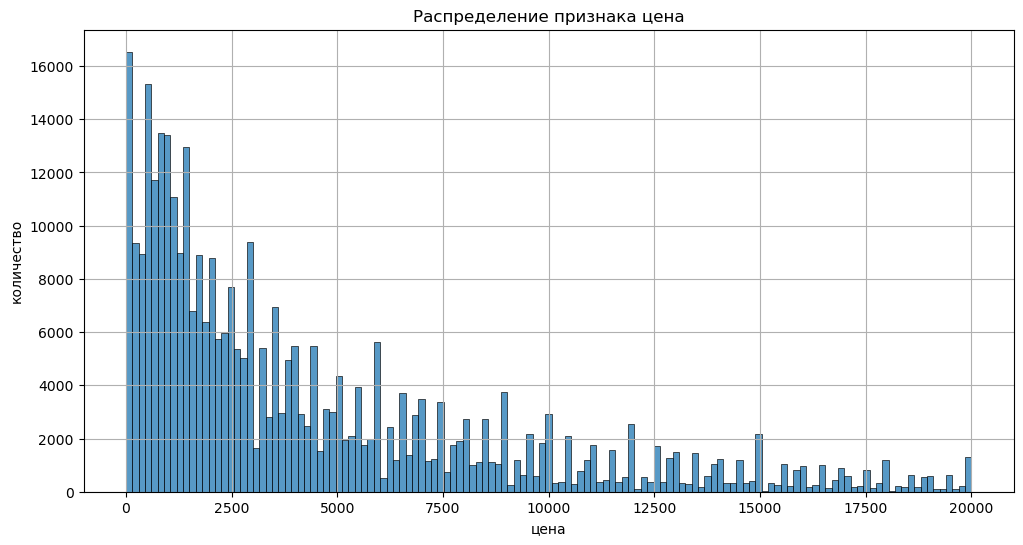

In [115]:
#строим гистограмму для анализа данных по ценам
plt.figure(figsize=(12, 6))
sns.histplot(data=df, x='price')
plt.title('Распределение признака цена')
plt.xlabel('цена')
plt.ylabel('количество')
plt.grid()
plt.show()

In [116]:
#считаем количество объектов с нулевой ценой
len(df[df['price'] == 0])

10772

Видим аномальное значение 0 для цены автомобиля у 10772 объектов. 

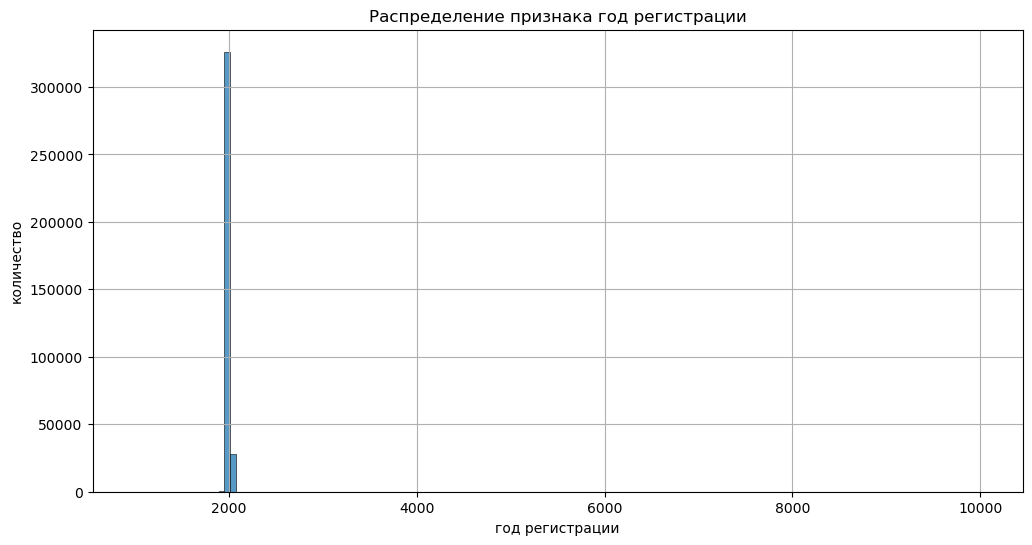

In [117]:
#строим гистограмму для анализа данных по годам регистрации
plt.figure(figsize=(12, 6))
sns.histplot(data=df, x='registration_year', 
             bins=len(df['registration_year'].sort_values().unique()))
plt.title('Распределение признака год регистрации')
plt.xlabel('год регистрации')
plt.ylabel('количество')
plt.grid()
plt.show()

In [118]:
#считаем количество объектов с аномальными годами регистрации
len(df[(df['registration_year'] <= 1950) | (df['registration_year'] >= 2023)])

369

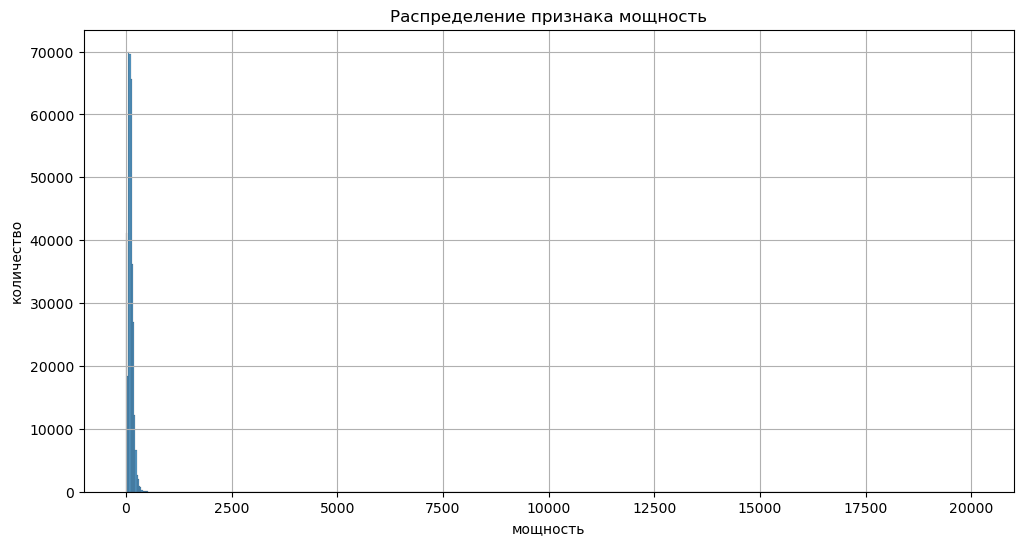

In [119]:
#строим гистограмму для анализа данных по мощности
plt.figure(figsize=(12, 6))
sns.histplot(data=df, x='power', bins=len(df['power'].sort_values().unique()))
plt.title('Распределение признака мощность')
plt.xlabel('мощность')
plt.ylabel('количество')
plt.grid()
plt.show()

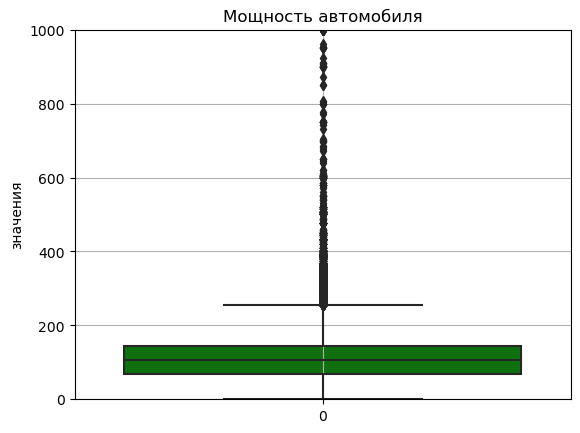

In [120]:
#строим boxplot для анализа данных по мощности
boxplot_power = sns.boxplot(data=df['power'], color='green')
boxplot_power.set_title('Мощность автомобиля')
boxplot_power.set_ylabel('значения')
boxplot_power.set_ylim([0, 1000])
plt.grid()
plt.show()

In [121]:
#считаем количество объектов с аномальной мощностью
len(df[(df['power'] >= 500)])

498

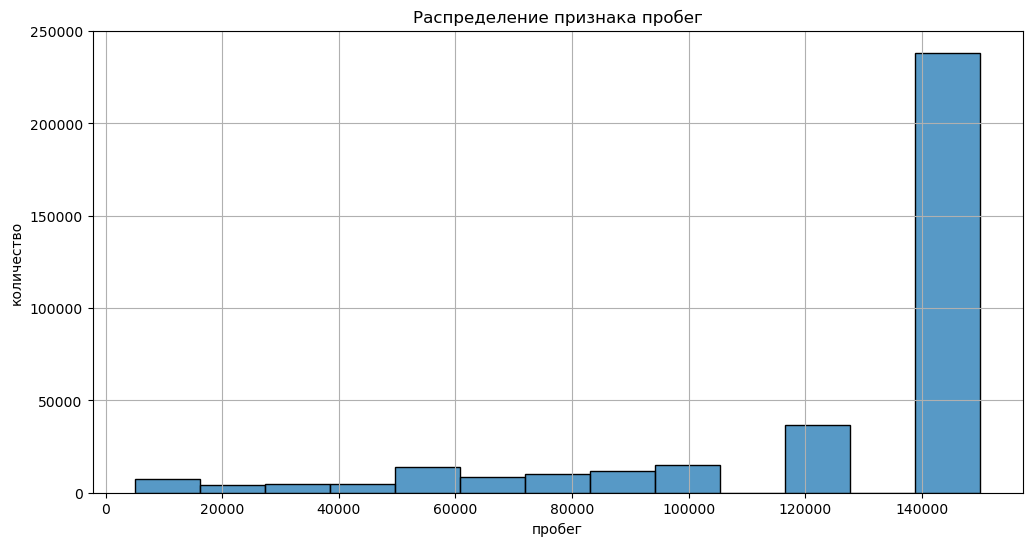

In [122]:
#строим гистограмму для анализа данных по пробегу
plt.figure(figsize=(12, 6))
sns.histplot(data=df, x='kilometer',
            bins=len(df['kilometer'].sort_values().unique()))
plt.title('Распределение признака пробег')
plt.xlabel('пробег')
plt.ylabel('количество')
plt.grid()
plt.show()

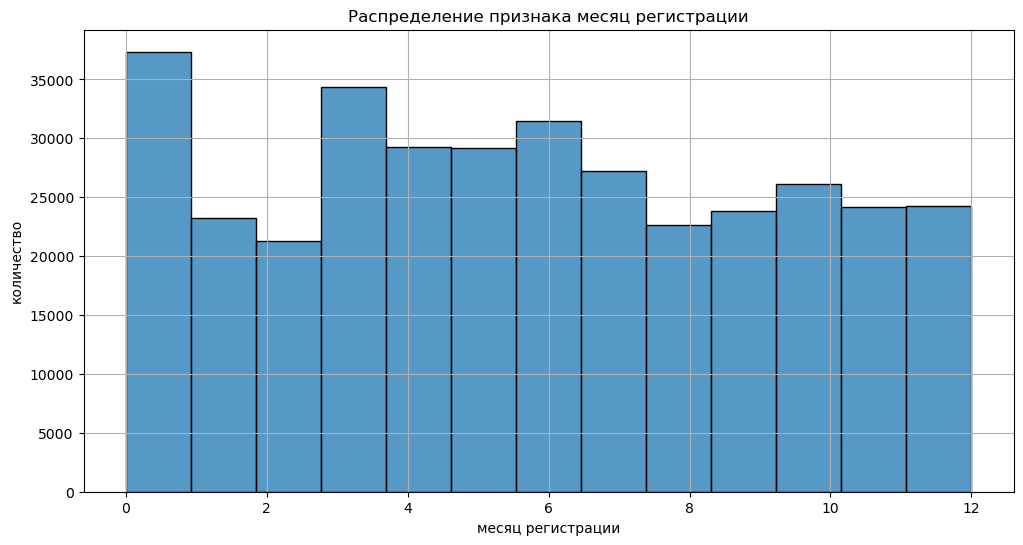

In [123]:
#строим гистограмму для анализа данных по месяцу регистрации
plt.figure(figsize=(12, 6))
sns.histplot(data=df, x='registration_month',
            bins=len(df['registration_month'].sort_values().unique()))
plt.title('Распределение признака месяц регистрации')
plt.xlabel('месяц регистрации')
plt.ylabel('количество')
plt.grid()
plt.show()

In [124]:
#проверяем какие значения встречаются для месяцев регистрации
df['registration_month'].sort_values().unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12])

Видим нарушение логики, в датафрейме 13 месяцев.

In [125]:
#проверяем какие значения встречаются в количестве фотографий
df['number_of_pictures'].sort_values().unique()

array([0])

In [126]:
#оцениваю количество уникальных данных в почтовом коде
len(df['postal_code'].unique())

8143

### Вывод

Для дальнейшего исследования мы можем исключить следующие признаки:
- date_crawled, т.к. дата скачивания анкеты не влияет на целевой признак (цену);
- date_created, исключаем по аналогичной причине;
- last_seen, также не влияет;
- registration_month, т.к. для исследования нам будет достаточно года регистрации;
- number_of_pictures, т.к. их значения для всех объектов равны 0
- postal_code, с одной стороны информация о регионе, которая зашита в почтовый код может быть полезной, с другой стороны в датафрейме слишком большое количество уникальных значений почтовых кодов, которая может быть излишней для цели обучения.


In [127]:
#исключаем нерелевантные цели исследования признаки
df = df.drop(columns=['date_crawled', 'date_created', 'last_seen', 'registration_month',
                     'number_of_pictures', 'postal_code'])

In [128]:
#исключаем объекты с аномальным значением цены, мощности, для года регистрации оставим более актуальный период
df = df[df['price'] > 0]
df = df[(df['power'] > 0) & (df['power'] <= 500)]
df = df[(df['registration_year'] >= 1980) & (df['registration_year'] <= 2016)]

### Рассмотрим категориальные признаки.

In [129]:
#рассмотрим уникальные значения признака тип кузова
df['vehicle_type'].sort_values().unique()

array(['bus', 'convertible', 'coupe', 'other', 'sedan', 'small', 'suv',
       'wagon', nan], dtype=object)

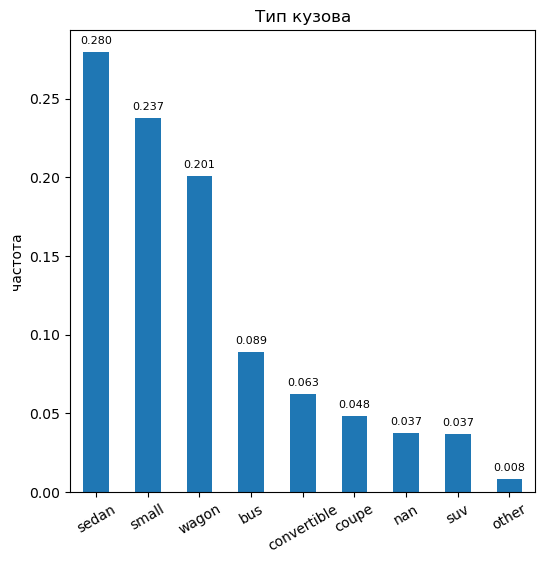

In [130]:
#посмотрим распределение
barplot1 = df['vehicle_type'].value_counts(normalize=True,
                                          dropna=False).plot(kind='bar', 
                                                       figsize=(6,6), 
                                                       title='Тип кузова')
plt.xticks(rotation=30)
plt.ylabel('частота')
for bar in barplot1.patches:
    barplot1.annotate(format(bar.get_height(), '.3f'),
                   (bar.get_x() + bar.get_width() / 2,
                    bar.get_height()), ha='center', va='center',
                   size=8, xytext=(0, 8),
                   textcoords='offset points')
    
plt.show()

In [131]:
#заменяем пропуски для тип кузова на unknown
df['vehicle_type'] = df['vehicle_type'].fillna('unknown')

In [132]:
#строим сводную таблицу по брендам
df_brand = df.pivot_table(index=['brand', 'model', 'vehicle_type'], 
                          values='price', aggfunc='count')

In [133]:
#сделаем срез, чтобы посмотреть на распределение значений внутри одной модели бренда
df_brand.loc['audi', 'tt']

,price
vehicle_type,
convertible,390
coupe,589
other,1
sedan,2
small,5
unknown,21


In [134]:
#сделаем срез, чтобы посмотреть на распределение значений внутри одной модели бренда
df_brand.loc['audi', 'a6']

,price
vehicle_type,
bus,1
other,3
sedan,1687
small,1
suv,7
unknown,72
wagon,3185


Оставляем на месте пропусков в типе кузова заглушку 'unknown', так как точное значение подобрать невозможно.

In [135]:
#рассмотрим уникальные значения по типу коробки передач
df['gearbox'].sort_values().unique()

array(['auto', 'manual', nan], dtype=object)

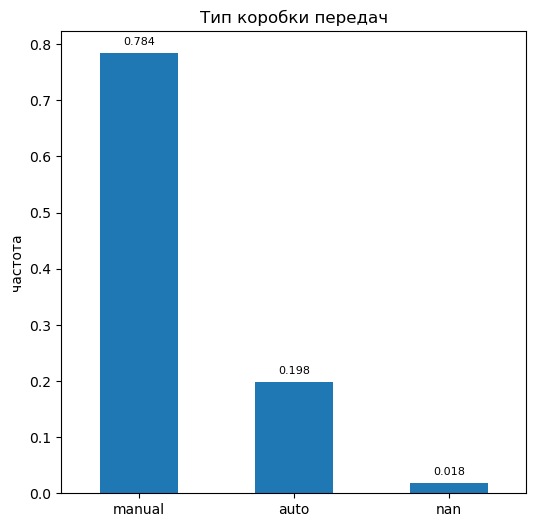

In [136]:
#посмотрим распределение
barplot2 = df['gearbox'].value_counts(normalize=True,
                                     dropna=False).plot(kind='bar', 
                                                       figsize=(6,6), 
                                                       title='Тип коробки передач')
plt.xticks(rotation=0)
plt.ylabel('частота')
for bar in barplot2.patches:
    barplot2.annotate(format(bar.get_height(), '.3f'),
                   (bar.get_x() + bar.get_width() / 2,
                    bar.get_height()), ha='center', va='center',
                   size=8, xytext=(0, 8),
                   textcoords='offset points')
    
plt.show()

In [137]:
#заменяем пропуски на unknown
df['gearbox'] = df['gearbox'].fillna('unknown')

In [138]:
#строим сводную таблицу по коробке передач
df_gearbox = df.pivot_table(index=['brand', 'model', 
                                   'registration_year', 'gearbox'], 
                            values='price', aggfunc='count')

In [139]:
#сделаем срез, чтобы посмотреть на распределение значений внутри одной модели бренда по годам
df_gearbox.loc['audi', 'tt']

price
registration_year gearbox       
1990              manual       1
1998              manual      24
1999              auto         1
                  manual     146
                  unknown      2
2000              manual     154
                  unknown      2
2001              manual      89
2002              manual      57
2003              auto        19
                  manual      38
2004              auto        20
                  manual      38
2005              auto         7
                  manual      32
2006              auto        22
                  manual      41
                  unknown      6
2007              auto        45
                  manual      93
2008              auto        22
                  manual      65
                  unknown      1
2009              auto         8
                  manual      31
2010              auto         1
                  manual      20
2011              manual      12
2012              manual       2
2014              manual       1
2015              auto         1
2016              auto         1
                  manual       5
                  unknown      1

В отдельные годы для определенных моделей можно найти наиболее вероятный тип коробки передач, но системно заполнить эти пропуски невозможно, поэтому оставляем заглушку 'unknown'.

In [140]:
#считаем количество уникальных значений в моделях
len(df['model'].sort_values().unique())

249

In [141]:
#заменяем пропуски на unknown
df['model'] = df['model'].fillna('unknown')

Заменить системно пропуски в названиях моделей по имеющимся данным невозможно.

In [142]:
#смотрим уникальные значения для типа топлива
df['fuel_type'].sort_values().unique()

array(['cng', 'electric', 'gasoline', 'hybrid', 'lpg', 'other', 'petrol',
       nan], dtype=object)

In [143]:
#объединяем gasoline и petrol, потому что это синонимы
df['fuel_type'] = df['fuel_type'].str.replace('gasoline', 'petrol', regex=True)

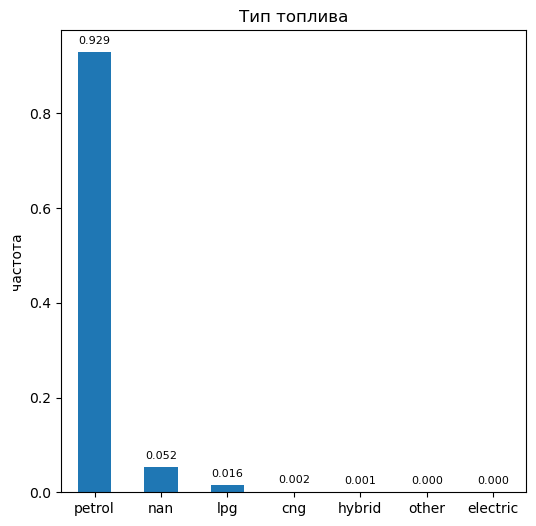

In [144]:
barplot3 = df['fuel_type'].value_counts(normalize=True,
                                     dropna=False).plot(kind='bar', 
                                                       figsize=(6,6), 
                                                       title='Тип топлива')
plt.xticks(rotation=0)
plt.ylabel('частота')
for bar in barplot3.patches:
    barplot3.annotate(format(bar.get_height(), '.3f'),
                   (bar.get_x() + bar.get_width() / 2,
                    bar.get_height()), ha='center', va='center',
                   size=8, xytext=(0, 8),
                   textcoords='offset points')
    
plt.show()

In [145]:
#Заменяем пропуски на other (возможно это дизель, но мы не можем точно утверждать)
df['fuel_type'] = df['fuel_type'].fillna('other')

In [146]:
#Также можем объединить все остальные значения кроме petrol в категорию other
other_fuel = ['cng', 'electric', 'hybrid', 'lpg']
for i in other_fuel:
    df['fuel_type'] = df['fuel_type'].str.replace(i, 'other', regex=True)

In [147]:
#получаем следующее распределение
df['fuel_type'].value_counts(normalize=True)

petrol    0.928864
other     0.071136
Name: fuel_type, dtype: float64

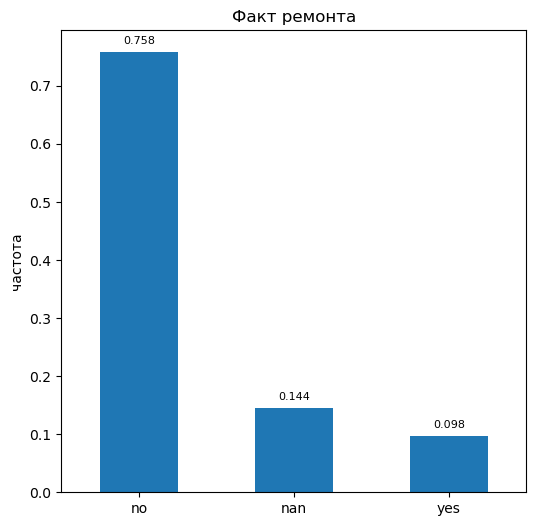

In [148]:
barplot4 = df['repaired'].value_counts(normalize=True,
                                     dropna=False).plot(kind='bar', 
                                                       figsize=(6,6), 
                                                       title='Факт ремонта')
plt.xticks(rotation=0)
plt.ylabel('частота')
for bar in barplot4.patches:
    barplot4.annotate(format(bar.get_height(), '.3f'),
                   (bar.get_x() + bar.get_width() / 2,
                    bar.get_height()), ha='center', va='center',
                   size=8, xytext=(0, 8),
                   textcoords='offset points')
    
plt.show()

In [149]:
#Заменяем пропуски на unknown 
df['repaired'] = df['repaired'].fillna('unknown')

In [150]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 294294 entries, 1 to 354364
Data columns (total 10 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   price              294294 non-null  int64 
 1   vehicle_type       294294 non-null  object
 2   registration_year  294294 non-null  int64 
 3   gearbox            294294 non-null  object
 4   power              294294 non-null  int64 
 5   model              294294 non-null  object
 6   kilometer          294294 non-null  int64 
 7   fuel_type          294294 non-null  object
 8   brand              294294 non-null  object
 9   repaired           294294 non-null  object
dtypes: int64(4), object(6)
memory usage: 24.7+ MB


In [151]:
df.head()

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,repaired
1,18300,coupe,2011,manual,190,unknown,125000,petrol,audi,yes
2,9800,suv,2004,auto,163,grand,125000,petrol,jeep,unknown
3,1500,small,2001,manual,75,golf,150000,petrol,volkswagen,no
4,3600,small,2008,manual,69,fabia,90000,petrol,skoda,no
5,650,sedan,1995,manual,102,3er,150000,petrol,bmw,yes


In [152]:
#применяем порядковое кодирование для категориальных признаков
encoder = OrdinalEncoder()
df_encodered = pd.DataFrame(encoder.fit_transform(df),
                            columns=df.columns)

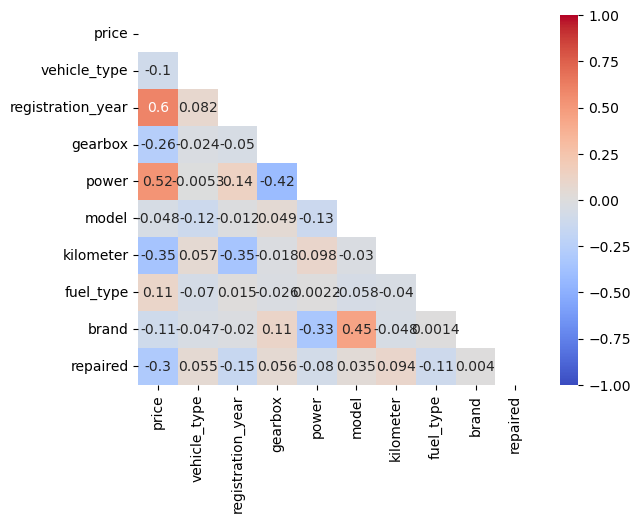

In [153]:
#строим тепловую карту корреляции
upp_mat_1 = np.triu(df_encodered.corr())
sns.heatmap(df_encodered.corr(), vmin =-1, vmax=1, annot=True, cmap='coolwarm', mask=upp_mat_1) 
plt.show()

Наиболее сильно выражена связь у параметров у целевого признака цена с признаками мощность и год регистрации.

## Этап 3. Обучение моделей

In [154]:
#функция целевой метрики RMSE
def rmse(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    return mse ** 0.5

In [155]:
#задаем метрику качества для моделей
rmse_scorer = make_scorer(rmse, greater_is_better=False)

In [156]:
#определяем признаки и целевой признак
features = df.drop('price', axis=1)
target = df['price']

In [157]:
#разделяем обучающую и тестовую выборки
features_train, features_test, target_train, target_test = train_test_split(
    features, target, test_size=0.25, random_state=12345)

In [158]:
#проверяем размеры выборок
print(features_train.shape)
print(features_test.shape)

(220720, 9)
(73574, 9)


Порядковое кодирование признаков.

In [159]:
encoder2 = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=5555)

In [160]:
#фитим порядковое кодинирование на обучающей выборке
encoder2.fit(features_train)

OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=5555)

In [161]:
features_train_enc = encoder2.transform(features_train)
features_test_enc = encoder2.transform(features_test)

In [162]:
features_train_enc = pd.DataFrame(features_train_enc, columns=features.columns)
features_test_enc = pd.DataFrame(features_test_enc, columns=features.columns)

Масштабирование признаков.

In [163]:
scaler = StandardScaler()

In [164]:
scaler.fit(features_train_enc)

StandardScaler()

In [165]:
features_train_scal = scaler.transform(features_train_enc)
features_test_scal = scaler.transform(features_test_enc)

In [166]:
features_train_scal = pd.DataFrame(features_train_scal, columns=features.columns)
features_test_scal = pd.DataFrame(features_test_scal, columns=features.columns)

### Random Forest 

In [167]:
%%time
model_1 = RandomForestRegressor(random_state=12345)
parametrs_1 = ({'max_depth': range(2,30,2),
              'n_estimators': range(5,55,10)})
grid_model_1 = GridSearchCV(model_1, parametrs_1, scoring=rmse_scorer)
grid_model_1.fit(features_train_scal, target_train)
grid_model_1.best_params_

CPU times: user 27min 46s, sys: 8.22 s, total: 27min 55s
Wall time: 27min 56s


{'max_depth': 18, 'n_estimators': 45}

In [168]:
%%time
best_rf_model = RandomForestRegressor(random_state=12345, max_depth=18,
                                           n_estimators=45)
best_rf_model.fit(features_train_scal, target_train)

CPU times: user 12.7 s, sys: 40.7 ms, total: 12.8 s
Wall time: 12.8 s


RandomForestRegressor(max_depth=18, n_estimators=45, random_state=12345)

In [169]:
%%time
pred1 = best_rf_model.predict(features_train_scal)

CPU times: user 1.49 s, sys: 5.2 ms, total: 1.5 s
Wall time: 1.5 s


In [170]:
model_1_score = abs(grid_model_1.best_score_)
print('RMSE модели', model_1_score)

RMSE модели 1570.5084287257419


In [171]:
best_model_1 = grid_model_1.best_estimator_

### CatBoost

In [172]:
category_features = ['vehicle_type', 'gearbox', 'model', 'fuel_type', 'brand', 'repaired']

In [173]:
%%time
model_2 = CatBoostRegressor(cat_features=category_features, random_state=12345)
parameters_2 = {'iterations': [100, 150, 200, 250, 300],
                'learning_rate': [0.03, 0.06, 0.09, 0.12],
                'depth': [2, 4, 6, 8, 10]}
grid_model_2 = GridSearchCV(estimator=model_2, param_grid=parameters_2, cv=2, n_jobs=-1,
                           scoring=rmse_scorer)
grid_model_2.fit(features_train, target_train)
grid_model_2.best_params_

0:	learn: 4451.6265853	total: 111ms	remaining: 11s
1:	learn: 4322.3675456	total: 158ms	remaining: 7.73s
2:	learn: 4204.1388165	total: 177ms	remaining: 5.73s
3:	learn: 4095.1034993	total: 228ms	remaining: 5.47s
4:	learn: 3990.4126431	total: 248ms	remaining: 4.7s
5:	learn: 3898.2552853	total: 271ms	remaining: 4.25s
6:	learn: 3807.4722353	total: 302ms	remaining: 4.01s
7:	learn: 3727.7469828	total: 342ms	remaining: 3.93s
8:	learn: 3650.5558893	total: 372ms	remaining: 3.76s
9:	learn: 3577.5448242	total: 385ms	remaining: 3.47s
10:	learn: 3514.3493196	total: 397ms	remaining: 3.21s
11:	learn: 3450.5336067	total: 420ms	remaining: 3.08s
12:	learn: 3396.4525532	total: 437ms	remaining: 2.93s
13:	learn: 3343.1447669	total: 457ms	remaining: 2.81s
14:	learn: 3292.0030815	total: 486ms	remaining: 2.75s
15:	learn: 3246.6408947	total: 504ms	remaining: 2.64s
16:	learn: 3198.9597706	total: 523ms	remaining: 2.55s
17:	learn: 3159.3196575	total: 544ms	remaining: 2.48s
18:	learn: 3117.8453867	total: 566ms	rema

0:	learn: 4521.6092730	total: 106ms	remaining: 10.5s
1:	learn: 4453.6186674	total: 130ms	remaining: 6.38s
2:	learn: 4387.8978025	total: 160ms	remaining: 5.18s
3:	learn: 4325.6936472	total: 184ms	remaining: 4.42s
4:	learn: 4265.9730024	total: 210ms	remaining: 3.98s
5:	learn: 4209.1040181	total: 228ms	remaining: 3.57s
6:	learn: 4152.0832431	total: 256ms	remaining: 3.4s
7:	learn: 4097.7965163	total: 275ms	remaining: 3.16s
8:	learn: 4046.2605862	total: 306ms	remaining: 3.09s
9:	learn: 3996.2905138	total: 334ms	remaining: 3.01s
10:	learn: 3949.4679218	total: 355ms	remaining: 2.87s
11:	learn: 3904.1155300	total: 380ms	remaining: 2.78s
12:	learn: 3860.9257846	total: 401ms	remaining: 2.68s
13:	learn: 3817.1797016	total: 419ms	remaining: 2.57s
14:	learn: 3775.1410934	total: 437ms	remaining: 2.47s
15:	learn: 3735.9387990	total: 455ms	remaining: 2.39s
16:	learn: 3697.6946699	total: 476ms	remaining: 2.32s
17:	learn: 3661.8705048	total: 498ms	remaining: 2.27s
18:	learn: 3627.1033237	total: 528ms	re

0:	learn: 4326.2578069	total: 142ms	remaining: 14.1s
1:	learn: 4091.1759448	total: 183ms	remaining: 8.97s
2:	learn: 3894.9966179	total: 197ms	remaining: 6.37s
3:	learn: 3718.5716831	total: 222ms	remaining: 5.32s
4:	learn: 3573.6903112	total: 242ms	remaining: 4.59s
5:	learn: 3441.1242957	total: 265ms	remaining: 4.14s
6:	learn: 3333.4817421	total: 288ms	remaining: 3.83s
7:	learn: 3235.0961697	total: 313ms	remaining: 3.6s
8:	learn: 3144.4030333	total: 346ms	remaining: 3.5s
9:	learn: 3071.7544216	total: 388ms	remaining: 3.49s
10:	learn: 2995.0217273	total: 407ms	remaining: 3.29s
11:	learn: 2936.4581020	total: 441ms	remaining: 3.23s
12:	learn: 2882.2550530	total: 477ms	remaining: 3.19s
13:	learn: 2819.6893240	total: 493ms	remaining: 3.03s
14:	learn: 2765.9780729	total: 526ms	remaining: 2.98s
15:	learn: 2721.4716513	total: 546ms	remaining: 2.87s
16:	learn: 2681.4032369	total: 578ms	remaining: 2.82s
17:	learn: 2640.3896313	total: 611ms	remaining: 2.78s
18:	learn: 2602.7143125	total: 640ms	rem

0:	learn: 4315.1140385	total: 130ms	remaining: 12.8s
1:	learn: 4083.2745725	total: 158ms	remaining: 7.76s
2:	learn: 3886.2469688	total: 202ms	remaining: 6.53s
3:	learn: 3707.5294628	total: 220ms	remaining: 5.29s
4:	learn: 3566.3614784	total: 254ms	remaining: 4.83s
5:	learn: 3431.7556020	total: 287ms	remaining: 4.5s
6:	learn: 3327.0293976	total: 312ms	remaining: 4.14s
7:	learn: 3219.4789702	total: 334ms	remaining: 3.84s
8:	learn: 3131.1728368	total: 357ms	remaining: 3.61s
9:	learn: 3062.2632564	total: 373ms	remaining: 3.35s
10:	learn: 2999.3516112	total: 417ms	remaining: 3.38s
11:	learn: 2931.5977305	total: 450ms	remaining: 3.3s
12:	learn: 2865.0657461	total: 469ms	remaining: 3.14s
13:	learn: 2811.7947211	total: 497ms	remaining: 3.05s
14:	learn: 2759.5284525	total: 518ms	remaining: 2.93s
15:	learn: 2720.5303936	total: 534ms	remaining: 2.8s
16:	learn: 2679.9012586	total: 555ms	remaining: 2.71s
17:	learn: 2643.5962004	total: 576ms	remaining: 2.62s
18:	learn: 2610.0895186	total: 607ms	rema

0:	learn: 4394.2514787	total: 106ms	remaining: 10.5s
1:	learn: 4208.4512102	total: 143ms	remaining: 7.02s
2:	learn: 4046.5323819	total: 168ms	remaining: 5.44s
3:	learn: 3896.9313297	total: 191ms	remaining: 4.59s
4:	learn: 3766.3339113	total: 222ms	remaining: 4.21s
5:	learn: 3645.4431166	total: 238ms	remaining: 3.73s
6:	learn: 3542.3102869	total: 259ms	remaining: 3.45s
7:	learn: 3450.7840199	total: 304ms	remaining: 3.5s
8:	learn: 3361.7236073	total: 337ms	remaining: 3.41s
9:	learn: 3289.0228124	total: 367ms	remaining: 3.3s
10:	learn: 3218.2225790	total: 404ms	remaining: 3.27s
11:	learn: 3159.7846058	total: 424ms	remaining: 3.11s
12:	learn: 3095.9766528	total: 453ms	remaining: 3.03s
13:	learn: 3035.9298062	total: 474ms	remaining: 2.91s
14:	learn: 2990.0714892	total: 501ms	remaining: 2.84s
15:	learn: 2942.8434636	total: 521ms	remaining: 2.73s
16:	learn: 2895.9965239	total: 541ms	remaining: 2.64s
17:	learn: 2851.3036141	total: 556ms	remaining: 2.53s
18:	learn: 2815.2979092	total: 579ms	rem

53:	learn: 2837.6802411	total: 1.81s	remaining: 4.89s
54:	learn: 2822.4563400	total: 1.84s	remaining: 4.86s
55:	learn: 2808.7094387	total: 1.86s	remaining: 4.79s
56:	learn: 2793.3870701	total: 1.9s	remaining: 4.76s
57:	learn: 2779.4153033	total: 1.94s	remaining: 4.75s
58:	learn: 2765.3110404	total: 1.97s	remaining: 4.71s
59:	learn: 2750.9035237	total: 1.99s	remaining: 4.65s
60:	learn: 2738.8468895	total: 2.02s	remaining: 4.61s
61:	learn: 2725.3628363	total: 2.04s	remaining: 4.54s
62:	learn: 2712.4205460	total: 2.07s	remaining: 4.5s
63:	learn: 2700.3849401	total: 2.12s	remaining: 4.51s
64:	learn: 2689.3582877	total: 2.16s	remaining: 4.48s
65:	learn: 2678.8898419	total: 2.19s	remaining: 4.46s
66:	learn: 2667.1717303	total: 2.23s	remaining: 4.43s
67:	learn: 2657.5888405	total: 2.26s	remaining: 4.38s
68:	learn: 2647.7858639	total: 2.28s	remaining: 4.34s
69:	learn: 2638.5560197	total: 2.35s	remaining: 4.36s
70:	learn: 2629.1795612	total: 2.39s	remaining: 4.34s
71:	learn: 2618.6820311	total:

53:	learn: 2352.1268908	total: 1.85s	remaining: 5.01s
54:	learn: 2342.1474866	total: 1.88s	remaining: 4.95s
55:	learn: 2333.4115878	total: 1.9s	remaining: 4.89s
56:	learn: 2325.9671246	total: 1.93s	remaining: 4.84s
57:	learn: 2317.6866789	total: 1.96s	remaining: 4.8s
58:	learn: 2309.7115679	total: 2s	remaining: 4.78s
59:	learn: 2303.0820556	total: 2.04s	remaining: 4.76s
60:	learn: 2289.1618418	total: 2.09s	remaining: 4.76s
61:	learn: 2281.6543122	total: 2.13s	remaining: 4.75s
62:	learn: 2271.9104574	total: 2.16s	remaining: 4.71s
63:	learn: 2265.5939917	total: 2.2s	remaining: 4.67s
64:	learn: 2259.5979932	total: 2.22s	remaining: 4.62s
65:	learn: 2253.2957545	total: 2.25s	remaining: 4.57s
66:	learn: 2244.0136713	total: 2.28s	remaining: 4.52s
67:	learn: 2238.2091640	total: 2.31s	remaining: 4.47s
68:	learn: 2232.6314106	total: 2.35s	remaining: 4.45s
69:	learn: 2227.7407002	total: 2.37s	remaining: 4.41s
70:	learn: 2218.9521618	total: 2.39s	remaining: 4.34s
71:	learn: 2212.4685548	total: 2.4

53:	learn: 2178.5489225	total: 1.85s	remaining: 5s
54:	learn: 2170.4460065	total: 1.88s	remaining: 4.95s
55:	learn: 2161.6243590	total: 1.91s	remaining: 4.91s
56:	learn: 2156.2488529	total: 1.93s	remaining: 4.85s
57:	learn: 2149.0452487	total: 1.95s	remaining: 4.77s
58:	learn: 2142.0255427	total: 1.99s	remaining: 4.76s
59:	learn: 2137.7061708	total: 2.04s	remaining: 4.77s
60:	learn: 2133.7333836	total: 2.07s	remaining: 4.73s
61:	learn: 2127.9413593	total: 2.13s	remaining: 4.75s
62:	learn: 2121.9073532	total: 2.16s	remaining: 4.7s
63:	learn: 2118.0590726	total: 2.2s	remaining: 4.68s
64:	learn: 2112.2779074	total: 2.22s	remaining: 4.62s
65:	learn: 2108.9189224	total: 2.26s	remaining: 4.58s
66:	learn: 2105.7026164	total: 2.3s	remaining: 4.57s
67:	learn: 2098.7747621	total: 2.34s	remaining: 4.55s
68:	learn: 2095.7166437	total: 2.37s	remaining: 4.5s
69:	learn: 2091.0243566	total: 2.41s	remaining: 4.48s
70:	learn: 2087.6025631	total: 2.44s	remaining: 4.44s
71:	learn: 2084.5193556	total: 2.49

53:	learn: 2173.9775083	total: 1.77s	remaining: 4.79s
54:	learn: 2167.4084258	total: 1.8s	remaining: 4.75s
55:	learn: 2162.0536843	total: 1.84s	remaining: 4.73s
56:	learn: 2157.5558573	total: 1.86s	remaining: 4.67s
57:	learn: 2152.6195174	total: 1.88s	remaining: 4.6s
58:	learn: 2148.0689268	total: 1.91s	remaining: 4.57s
59:	learn: 2140.4409359	total: 1.96s	remaining: 4.57s
60:	learn: 2134.7497012	total: 1.98s	remaining: 4.51s
61:	learn: 2128.8862101	total: 2.01s	remaining: 4.47s
62:	learn: 2125.3543809	total: 2.04s	remaining: 4.45s
63:	learn: 2120.6671786	total: 2.08s	remaining: 4.41s
64:	learn: 2117.1740321	total: 2.11s	remaining: 4.38s
65:	learn: 2111.9302205	total: 2.13s	remaining: 4.33s
66:	learn: 2105.6413948	total: 2.16s	remaining: 4.28s
67:	learn: 2102.2297452	total: 2.2s	remaining: 4.27s
68:	learn: 2097.5212905	total: 2.22s	remaining: 4.21s
69:	learn: 2094.5741590	total: 2.24s	remaining: 4.16s
70:	learn: 2091.6917095	total: 2.28s	remaining: 4.14s
71:	learn: 2088.9676727	total: 

53:	learn: 2077.3922574	total: 1.89s	remaining: 5.12s
54:	learn: 2074.1631949	total: 1.93s	remaining: 5.09s
55:	learn: 2070.4223706	total: 1.99s	remaining: 5.13s
56:	learn: 2067.1281357	total: 2.03s	remaining: 5.1s
57:	learn: 2060.0266197	total: 2.06s	remaining: 5.03s
58:	learn: 2055.2939363	total: 2.08s	remaining: 4.97s
59:	learn: 2052.4665085	total: 2.12s	remaining: 4.94s
60:	learn: 2048.1327772	total: 2.14s	remaining: 4.89s
61:	learn: 2045.5200206	total: 2.16s	remaining: 4.81s
62:	learn: 2043.0979012	total: 2.21s	remaining: 4.81s
63:	learn: 2039.2926868	total: 2.23s	remaining: 4.74s
64:	learn: 2034.6380636	total: 2.27s	remaining: 4.7s
65:	learn: 2031.7501372	total: 2.31s	remaining: 4.68s
66:	learn: 2029.6265461	total: 2.35s	remaining: 4.66s
67:	learn: 2027.6089825	total: 2.37s	remaining: 4.6s
68:	learn: 2025.8930093	total: 2.43s	remaining: 4.62s
69:	learn: 2023.3190084	total: 2.49s	remaining: 4.63s
70:	learn: 2019.7040468	total: 2.52s	remaining: 4.58s
71:	learn: 2017.9203153	total: 

53:	learn: 2079.9812865	total: 1.92s	remaining: 5.18s
54:	learn: 2073.1855849	total: 1.95s	remaining: 5.13s
55:	learn: 2067.1291550	total: 1.99s	remaining: 5.12s
56:	learn: 2062.0853745	total: 2s	remaining: 5.03s
57:	learn: 2058.4466275	total: 2.04s	remaining: 5s
58:	learn: 2053.5153502	total: 2.08s	remaining: 4.97s
59:	learn: 2050.8085491	total: 2.13s	remaining: 4.97s
60:	learn: 2045.0890031	total: 2.17s	remaining: 4.93s
61:	learn: 2042.7359023	total: 2.18s	remaining: 4.86s
62:	learn: 2040.5246813	total: 2.21s	remaining: 4.81s
63:	learn: 2038.4922105	total: 2.23s	remaining: 4.74s
64:	learn: 2036.0299190	total: 2.25s	remaining: 4.68s
65:	learn: 2032.4338301	total: 2.3s	remaining: 4.67s
66:	learn: 2030.1343100	total: 2.33s	remaining: 4.62s
67:	learn: 2024.6927791	total: 2.34s	remaining: 4.55s
68:	learn: 2022.4276827	total: 2.37s	remaining: 4.5s
69:	learn: 2020.6648767	total: 2.42s	remaining: 4.5s
70:	learn: 2018.6716644	total: 2.46s	remaining: 4.47s
71:	learn: 2015.6297121	total: 2.48s	

154:	learn: 2191.1170683	total: 5.4s	remaining: 3.31s
155:	learn: 2188.9830891	total: 5.44s	remaining: 3.28s
156:	learn: 2186.6424969	total: 5.46s	remaining: 3.23s
157:	learn: 2184.4870696	total: 5.48s	remaining: 3.19s
158:	learn: 2182.4523232	total: 5.52s	remaining: 3.16s
159:	learn: 2180.5552928	total: 5.54s	remaining: 3.12s
160:	learn: 2177.2678453	total: 5.57s	remaining: 3.08s
161:	learn: 2174.0657726	total: 5.6s	remaining: 3.04s
162:	learn: 2172.1857874	total: 5.63s	remaining: 3s
163:	learn: 2169.1685808	total: 5.65s	remaining: 2.96s
164:	learn: 2167.2389335	total: 5.67s	remaining: 2.92s
165:	learn: 2164.9382110	total: 5.71s	remaining: 2.89s
166:	learn: 2163.2774643	total: 5.76s	remaining: 2.86s
167:	learn: 2159.8641454	total: 5.8s	remaining: 2.83s
168:	learn: 2156.9085635	total: 5.83s	remaining: 2.79s
169:	learn: 2155.2327855	total: 5.85s	remaining: 2.75s
170:	learn: 2152.4357194	total: 5.87s	remaining: 2.71s
171:	learn: 2149.8005133	total: 5.93s	remaining: 2.69s
172:	learn: 2148

154:	learn: 2185.0533886	total: 5.1s	remaining: 3.13s
155:	learn: 2182.8401772	total: 5.13s	remaining: 3.09s
156:	learn: 2179.5819712	total: 5.2s	remaining: 3.08s
157:	learn: 2177.4786965	total: 5.24s	remaining: 3.05s
158:	learn: 2174.3231418	total: 5.26s	remaining: 3.01s
159:	learn: 2171.4993795	total: 5.28s	remaining: 2.97s
160:	learn: 2169.4761271	total: 5.32s	remaining: 2.94s
161:	learn: 2166.5411762	total: 5.36s	remaining: 2.91s
162:	learn: 2164.6604212	total: 5.38s	remaining: 2.87s
163:	learn: 2162.8309540	total: 5.41s	remaining: 2.84s
164:	learn: 2159.4299730	total: 5.44s	remaining: 2.8s
165:	learn: 2157.5031752	total: 5.48s	remaining: 2.77s
166:	learn: 2155.6916433	total: 5.53s	remaining: 2.75s
167:	learn: 2154.0349163	total: 5.55s	remaining: 2.71s
168:	learn: 2151.2121351	total: 5.58s	remaining: 2.67s
169:	learn: 2148.8023691	total: 5.6s	remaining: 2.63s
170:	learn: 2147.0970999	total: 5.62s	remaining: 2.6s
171:	learn: 2145.4649546	total: 5.65s	remaining: 2.56s
172:	learn: 214

154:	learn: 1956.1519718	total: 5.05s	remaining: 3.09s
155:	learn: 1955.5643017	total: 5.07s	remaining: 3.05s
156:	learn: 1955.1857487	total: 5.09s	remaining: 3.02s
157:	learn: 1954.5421430	total: 5.11s	remaining: 2.97s
158:	learn: 1954.0630713	total: 5.14s	remaining: 2.94s
159:	learn: 1953.6845007	total: 5.17s	remaining: 2.91s
160:	learn: 1953.0515190	total: 5.2s	remaining: 2.87s
161:	learn: 1951.8550720	total: 5.24s	remaining: 2.85s
162:	learn: 1951.5124086	total: 5.29s	remaining: 2.82s
163:	learn: 1951.3152154	total: 5.31s	remaining: 2.79s
164:	learn: 1950.7426577	total: 5.35s	remaining: 2.76s
165:	learn: 1948.9435592	total: 5.38s	remaining: 2.73s
166:	learn: 1948.6211733	total: 5.41s	remaining: 2.69s
167:	learn: 1948.1862611	total: 5.45s	remaining: 2.66s
168:	learn: 1947.4030744	total: 5.47s	remaining: 2.62s
169:	learn: 1946.9713980	total: 5.51s	remaining: 2.59s
170:	learn: 1944.6662249	total: 5.53s	remaining: 2.56s
171:	learn: 1944.2004654	total: 5.57s	remaining: 2.52s
172:	learn:

154:	learn: 1894.8248236	total: 5.43s	remaining: 3.33s
155:	learn: 1893.3612347	total: 5.46s	remaining: 3.29s
156:	learn: 1892.7015727	total: 5.49s	remaining: 3.25s
157:	learn: 1892.3953001	total: 5.52s	remaining: 3.21s
158:	learn: 1891.5948641	total: 5.54s	remaining: 3.17s
159:	learn: 1890.8226029	total: 5.58s	remaining: 3.14s
160:	learn: 1890.5037456	total: 5.63s	remaining: 3.11s
161:	learn: 1889.3342752	total: 5.65s	remaining: 3.07s
162:	learn: 1888.6452342	total: 5.68s	remaining: 3.03s
163:	learn: 1887.8438202	total: 5.77s	remaining: 3.02s
164:	learn: 1886.4250225	total: 5.8s	remaining: 2.99s
165:	learn: 1885.9973005	total: 5.83s	remaining: 2.95s
166:	learn: 1885.6012212	total: 5.85s	remaining: 2.91s
167:	learn: 1884.9420546	total: 5.89s	remaining: 2.87s
168:	learn: 1883.6992516	total: 5.93s	remaining: 2.84s
169:	learn: 1882.5039417	total: 5.97s	remaining: 2.81s
170:	learn: 1881.1547860	total: 5.99s	remaining: 2.77s
171:	learn: 1880.1919966	total: 6.01s	remaining: 2.73s
172:	learn:

154:	learn: 1996.1464969	total: 5.24s	remaining: 3.21s
155:	learn: 1995.3379047	total: 5.27s	remaining: 3.18s
156:	learn: 1994.4717122	total: 5.29s	remaining: 3.13s
157:	learn: 1993.2442687	total: 5.32s	remaining: 3.1s
158:	learn: 1991.7721136	total: 5.34s	remaining: 3.06s
159:	learn: 1989.3958483	total: 5.39s	remaining: 3.03s
160:	learn: 1987.3672546	total: 5.42s	remaining: 3s
161:	learn: 1986.0517149	total: 5.47s	remaining: 2.97s
162:	learn: 1985.3031740	total: 5.55s	remaining: 2.96s
163:	learn: 1984.3375195	total: 5.58s	remaining: 2.93s
164:	learn: 1983.4175566	total: 5.61s	remaining: 2.89s
165:	learn: 1982.6029042	total: 5.64s	remaining: 2.85s
166:	learn: 1981.7844388	total: 5.69s	remaining: 2.83s
167:	learn: 1980.7583026	total: 5.72s	remaining: 2.79s
168:	learn: 1979.9004196	total: 5.74s	remaining: 2.75s
169:	learn: 1979.3873684	total: 5.76s	remaining: 2.71s
170:	learn: 1978.7613849	total: 5.82s	remaining: 2.69s
171:	learn: 1978.0981075	total: 5.86s	remaining: 2.65s
172:	learn: 19

154:	learn: 1901.2983810	total: 5.5s	remaining: 3.37s
155:	learn: 1900.3171243	total: 5.53s	remaining: 3.33s
156:	learn: 1898.4530175	total: 5.56s	remaining: 3.29s
157:	learn: 1897.7834666	total: 5.6s	remaining: 3.26s
158:	learn: 1897.4277012	total: 5.66s	remaining: 3.24s
159:	learn: 1896.5045678	total: 5.68s	remaining: 3.19s
160:	learn: 1894.6194704	total: 5.74s	remaining: 3.17s
161:	learn: 1893.5933504	total: 5.77s	remaining: 3.13s
162:	learn: 1892.3061773	total: 5.81s	remaining: 3.1s
163:	learn: 1892.1094189	total: 5.84s	remaining: 3.06s
164:	learn: 1891.4294965	total: 5.89s	remaining: 3.03s
165:	learn: 1890.6763962	total: 5.91s	remaining: 2.99s
166:	learn: 1889.3230909	total: 5.94s	remaining: 2.95s
167:	learn: 1888.8714945	total: 5.97s	remaining: 2.91s
168:	learn: 1888.5583682	total: 6s	remaining: 2.87s
169:	learn: 1886.9729895	total: 6.05s	remaining: 2.85s
170:	learn: 1886.1798476	total: 6.07s	remaining: 2.8s
171:	learn: 1885.5382714	total: 6.13s	remaining: 2.78s
172:	learn: 1884.

204:	learn: 2089.6672049	total: 6.54s	remaining: 3.03s
205:	learn: 2088.0785039	total: 6.56s	remaining: 2.99s
206:	learn: 2087.1008898	total: 6.58s	remaining: 2.96s
207:	learn: 2085.9495232	total: 6.62s	remaining: 2.93s
208:	learn: 2084.0033421	total: 6.63s	remaining: 2.89s
209:	learn: 2082.9005181	total: 6.66s	remaining: 2.85s
210:	learn: 2081.2553416	total: 6.7s	remaining: 2.83s
211:	learn: 2079.5797126	total: 6.74s	remaining: 2.79s
212:	learn: 2078.5533536	total: 6.78s	remaining: 2.77s
213:	learn: 2077.5306729	total: 6.8s	remaining: 2.73s
214:	learn: 2075.9610509	total: 6.82s	remaining: 2.7s
215:	learn: 2074.4106455	total: 6.86s	remaining: 2.67s
216:	learn: 2072.8117690	total: 6.89s	remaining: 2.64s
217:	learn: 2071.7261015	total: 6.92s	remaining: 2.6s
218:	learn: 2070.3525170	total: 6.93s	remaining: 2.56s
219:	learn: 2069.4652122	total: 6.95s	remaining: 2.53s
220:	learn: 2068.6118473	total: 6.98s	remaining: 2.49s
221:	learn: 2067.7441129	total: 7.02s	remaining: 2.46s
222:	learn: 20

204:	learn: 2083.4914589	total: 6.57s	remaining: 3.05s
205:	learn: 2081.7286522	total: 6.6s	remaining: 3.01s
206:	learn: 2080.0550622	total: 6.62s	remaining: 2.98s
207:	learn: 2078.9573904	total: 6.65s	remaining: 2.94s
208:	learn: 2077.9239322	total: 6.68s	remaining: 2.91s
209:	learn: 2076.0753835	total: 6.71s	remaining: 2.88s
210:	learn: 2074.4119815	total: 6.72s	remaining: 2.84s
211:	learn: 2073.3377461	total: 6.79s	remaining: 2.82s
212:	learn: 2071.7997534	total: 6.82s	remaining: 2.79s
213:	learn: 2070.9077211	total: 6.85s	remaining: 2.75s
214:	learn: 2069.9119787	total: 6.87s	remaining: 2.72s
215:	learn: 2068.9182469	total: 6.92s	remaining: 2.69s
216:	learn: 2067.9852201	total: 6.94s	remaining: 2.65s
217:	learn: 2066.5760706	total: 6.95s	remaining: 2.61s
218:	learn: 2065.5726385	total: 6.97s	remaining: 2.58s
219:	learn: 2064.3948351	total: 7.01s	remaining: 2.55s
220:	learn: 2063.3265857	total: 7.05s	remaining: 2.52s
221:	learn: 2062.4436122	total: 7.09s	remaining: 2.49s
222:	learn:

204:	learn: 1958.1051570	total: 6.77s	remaining: 3.13s
205:	learn: 1957.7332881	total: 6.8s	remaining: 3.1s
206:	learn: 1957.2492650	total: 6.82s	remaining: 3.07s
207:	learn: 1956.7670278	total: 6.84s	remaining: 3.03s
208:	learn: 1956.2609593	total: 6.86s	remaining: 2.99s
209:	learn: 1955.8653308	total: 6.91s	remaining: 2.96s
210:	learn: 1955.3228313	total: 6.95s	remaining: 2.93s
211:	learn: 1955.0050198	total: 6.98s	remaining: 2.9s
212:	learn: 1954.4205242	total: 7.01s	remaining: 2.87s
213:	learn: 1952.4851441	total: 7.04s	remaining: 2.83s
214:	learn: 1951.2197220	total: 7.07s	remaining: 2.79s
215:	learn: 1950.5035692	total: 7.09s	remaining: 2.76s
216:	learn: 1950.0702253	total: 7.12s	remaining: 2.72s
217:	learn: 1949.4318018	total: 7.15s	remaining: 2.69s
218:	learn: 1949.0528239	total: 7.17s	remaining: 2.65s
219:	learn: 1948.4173666	total: 7.21s	remaining: 2.62s
220:	learn: 1948.0282406	total: 7.24s	remaining: 2.59s
221:	learn: 1947.6761314	total: 7.28s	remaining: 2.56s
222:	learn: 1

204:	learn: 1893.9355575	total: 6.44s	remaining: 2.98s
205:	learn: 1893.0034320	total: 6.49s	remaining: 2.96s
206:	learn: 1892.4249796	total: 6.51s	remaining: 2.93s
207:	learn: 1892.0592603	total: 6.54s	remaining: 2.89s
208:	learn: 1891.4497580	total: 6.55s	remaining: 2.85s
209:	learn: 1891.0486873	total: 6.58s	remaining: 2.82s
210:	learn: 1890.5275410	total: 6.61s	remaining: 2.79s
211:	learn: 1889.0840235	total: 6.63s	remaining: 2.75s
212:	learn: 1888.1957204	total: 6.67s	remaining: 2.73s
213:	learn: 1887.7502649	total: 6.7s	remaining: 2.69s
214:	learn: 1886.5347259	total: 6.72s	remaining: 2.66s
215:	learn: 1885.5516578	total: 6.76s	remaining: 2.63s
216:	learn: 1884.5238106	total: 6.79s	remaining: 2.6s
217:	learn: 1884.3083882	total: 6.81s	remaining: 2.56s
218:	learn: 1883.9779504	total: 6.83s	remaining: 2.53s
219:	learn: 1883.1741519	total: 6.86s	remaining: 2.49s
220:	learn: 1882.8176713	total: 6.89s	remaining: 2.46s
221:	learn: 1882.2051602	total: 6.92s	remaining: 2.43s
222:	learn: 

204:	learn: 1852.2383014	total: 6.65s	remaining: 3.08s
205:	learn: 1851.7257026	total: 6.68s	remaining: 3.05s
206:	learn: 1851.3166325	total: 6.71s	remaining: 3.02s
207:	learn: 1850.4855690	total: 6.74s	remaining: 2.98s
208:	learn: 1849.7271728	total: 6.78s	remaining: 2.95s
209:	learn: 1848.8433081	total: 6.8s	remaining: 2.92s
210:	learn: 1848.4486308	total: 6.82s	remaining: 2.88s
211:	learn: 1847.7177200	total: 6.85s	remaining: 2.84s
212:	learn: 1847.4135398	total: 6.89s	remaining: 2.81s
213:	learn: 1846.5861110	total: 6.91s	remaining: 2.78s
214:	learn: 1846.1464257	total: 6.94s	remaining: 2.74s
215:	learn: 1845.6093090	total: 6.97s	remaining: 2.71s
216:	learn: 1845.0570325	total: 7s	remaining: 2.67s
217:	learn: 1844.4229841	total: 7.04s	remaining: 2.65s
218:	learn: 1843.7508005	total: 7.1s	remaining: 2.63s
219:	learn: 1843.3495703	total: 7.12s	remaining: 2.59s
220:	learn: 1842.3977482	total: 7.15s	remaining: 2.56s
221:	learn: 1841.9973201	total: 7.17s	remaining: 2.52s
222:	learn: 184

204:	learn: 1915.9023855	total: 7.11s	remaining: 3.3s
205:	learn: 1915.4826587	total: 7.15s	remaining: 3.26s
206:	learn: 1915.2330817	total: 7.18s	remaining: 3.22s
207:	learn: 1914.9014544	total: 7.21s	remaining: 3.19s
208:	learn: 1914.5853489	total: 7.23s	remaining: 3.15s
209:	learn: 1913.5972081	total: 7.29s	remaining: 3.12s
210:	learn: 1913.2161577	total: 7.32s	remaining: 3.09s
211:	learn: 1910.5388632	total: 7.36s	remaining: 3.06s
212:	learn: 1908.8586702	total: 7.4s	remaining: 3.02s
213:	learn: 1908.1081727	total: 7.44s	remaining: 2.99s
214:	learn: 1907.6716604	total: 7.46s	remaining: 2.95s
215:	learn: 1906.8200816	total: 7.5s	remaining: 2.91s
216:	learn: 1904.4258228	total: 7.55s	remaining: 2.89s
217:	learn: 1903.1794398	total: 7.62s	remaining: 2.87s
218:	learn: 1901.7618104	total: 7.65s	remaining: 2.83s
219:	learn: 1900.7910043	total: 7.66s	remaining: 2.79s
220:	learn: 1900.0853617	total: 7.7s	remaining: 2.75s
221:	learn: 1899.6604073	total: 7.71s	remaining: 2.71s
222:	learn: 18

204:	learn: 1864.6502152	total: 7.26s	remaining: 3.36s
205:	learn: 1863.7400843	total: 7.29s	remaining: 3.32s
206:	learn: 1863.0047826	total: 7.31s	remaining: 3.29s
207:	learn: 1862.5677144	total: 7.33s	remaining: 3.24s
208:	learn: 1862.2614931	total: 7.37s	remaining: 3.21s
209:	learn: 1861.6954346	total: 7.39s	remaining: 3.17s
210:	learn: 1861.0646183	total: 7.41s	remaining: 3.12s
211:	learn: 1860.2261022	total: 7.45s	remaining: 3.09s
212:	learn: 1859.4397724	total: 7.48s	remaining: 3.05s
213:	learn: 1858.4643133	total: 7.52s	remaining: 3.02s
214:	learn: 1858.0284188	total: 7.55s	remaining: 2.98s
215:	learn: 1857.7355890	total: 7.59s	remaining: 2.95s
216:	learn: 1857.3353947	total: 7.63s	remaining: 2.92s
217:	learn: 1857.1131199	total: 7.66s	remaining: 2.88s
218:	learn: 1856.2836079	total: 7.68s	remaining: 2.84s
219:	learn: 1855.4351462	total: 7.7s	remaining: 2.8s
220:	learn: 1854.7299822	total: 7.73s	remaining: 2.76s
221:	learn: 1854.1714324	total: 7.76s	remaining: 2.73s
222:	learn: 

106:	learn: 2077.3109340	total: 3.64s	remaining: 1.46s
107:	learn: 2074.0180481	total: 3.66s	remaining: 1.42s
108:	learn: 2070.9444825	total: 3.68s	remaining: 1.39s
109:	learn: 2067.3550225	total: 3.71s	remaining: 1.35s
110:	learn: 2063.9353056	total: 3.75s	remaining: 1.32s
111:	learn: 2060.9794473	total: 3.79s	remaining: 1.28s
112:	learn: 2057.6644107	total: 3.81s	remaining: 1.25s
113:	learn: 2054.9757405	total: 3.85s	remaining: 1.22s
114:	learn: 2051.8071863	total: 3.87s	remaining: 1.18s
115:	learn: 2048.8435757	total: 3.92s	remaining: 1.15s
116:	learn: 2045.3576688	total: 3.94s	remaining: 1.11s
117:	learn: 2042.9997534	total: 3.98s	remaining: 1.08s
118:	learn: 2040.3037932	total: 4s	remaining: 1.04s
119:	learn: 2037.8001947	total: 4.02s	remaining: 1s
120:	learn: 2035.3967246	total: 4.06s	remaining: 974ms
121:	learn: 2032.2113973	total: 4.09s	remaining: 939ms
122:	learn: 2029.3800741	total: 4.15s	remaining: 911ms
123:	learn: 2026.4040880	total: 4.18s	remaining: 877ms
124:	learn: 2024

106:	learn: 2077.2325043	total: 3.54s	remaining: 1.42s
107:	learn: 2073.2315834	total: 3.56s	remaining: 1.38s
108:	learn: 2069.8475905	total: 3.59s	remaining: 1.35s
109:	learn: 2066.1344638	total: 3.63s	remaining: 1.32s
110:	learn: 2061.9751725	total: 3.65s	remaining: 1.28s
111:	learn: 2058.6917292	total: 3.7s	remaining: 1.25s
112:	learn: 2055.8356158	total: 3.73s	remaining: 1.22s
113:	learn: 2051.9165853	total: 3.78s	remaining: 1.19s
114:	learn: 2049.3308186	total: 3.81s	remaining: 1.16s
115:	learn: 2046.2406578	total: 3.83s	remaining: 1.12s
116:	learn: 2043.8102647	total: 3.88s	remaining: 1.09s
117:	learn: 2040.4843142	total: 3.92s	remaining: 1.06s
118:	learn: 2037.2136366	total: 3.95s	remaining: 1.03s
119:	learn: 2034.2393968	total: 3.98s	remaining: 995ms
120:	learn: 2031.0336229	total: 4s	remaining: 960ms
121:	learn: 2028.7707754	total: 4.04s	remaining: 927ms
122:	learn: 2025.9336068	total: 4.07s	remaining: 893ms
123:	learn: 2023.3139701	total: 4.11s	remaining: 861ms
124:	learn: 20

106:	learn: 1897.3311323	total: 3.72s	remaining: 1.5s
107:	learn: 1896.2777088	total: 3.75s	remaining: 1.46s
108:	learn: 1894.9616979	total: 3.78s	remaining: 1.42s
109:	learn: 1893.5312870	total: 3.81s	remaining: 1.39s
110:	learn: 1891.9604770	total: 3.83s	remaining: 1.35s
111:	learn: 1890.7002830	total: 3.87s	remaining: 1.31s
112:	learn: 1889.5227321	total: 3.91s	remaining: 1.28s
113:	learn: 1888.5471952	total: 3.94s	remaining: 1.25s
114:	learn: 1886.8874147	total: 3.99s	remaining: 1.21s
115:	learn: 1885.8198216	total: 4.03s	remaining: 1.18s
116:	learn: 1883.9646007	total: 4.06s	remaining: 1.14s
117:	learn: 1882.9058960	total: 4.08s	remaining: 1.11s
118:	learn: 1881.7136710	total: 4.12s	remaining: 1.07s
119:	learn: 1880.7614395	total: 4.14s	remaining: 1.03s
120:	learn: 1879.9980942	total: 4.17s	remaining: 1000ms
121:	learn: 1876.7748024	total: 4.2s	remaining: 964ms
122:	learn: 1873.9757370	total: 4.23s	remaining: 928ms
123:	learn: 1871.3740397	total: 4.27s	remaining: 895ms
124:	learn:

106:	learn: 1894.9625112	total: 3.55s	remaining: 1.43s
107:	learn: 1893.1625962	total: 3.59s	remaining: 1.39s
108:	learn: 1891.7933735	total: 3.63s	remaining: 1.36s
109:	learn: 1890.3341317	total: 3.65s	remaining: 1.33s
110:	learn: 1888.0114853	total: 3.69s	remaining: 1.29s
111:	learn: 1886.8607967	total: 3.72s	remaining: 1.26s
112:	learn: 1885.3201680	total: 3.75s	remaining: 1.23s
113:	learn: 1884.0257539	total: 3.8s	remaining: 1.2s
114:	learn: 1883.0165929	total: 3.83s	remaining: 1.17s
115:	learn: 1881.3756226	total: 3.88s	remaining: 1.14s
116:	learn: 1880.0394272	total: 3.92s	remaining: 1.11s
117:	learn: 1877.6848572	total: 3.95s	remaining: 1.07s
118:	learn: 1875.7325555	total: 4s	remaining: 1.04s
119:	learn: 1873.2035134	total: 4.05s	remaining: 1.01s
120:	learn: 1871.1426912	total: 4.08s	remaining: 978ms
121:	learn: 1869.5492152	total: 4.14s	remaining: 951ms
122:	learn: 1867.4584065	total: 4.18s	remaining: 919ms
123:	learn: 1865.5330035	total: 4.21s	remaining: 884ms
124:	learn: 186

106:	learn: 1828.6323863	total: 3.96s	remaining: 1.59s
107:	learn: 1826.6730674	total: 4s	remaining: 1.55s
108:	learn: 1824.6100001	total: 4.05s	remaining: 1.52s
109:	learn: 1823.4623154	total: 4.08s	remaining: 1.48s
110:	learn: 1821.6021262	total: 4.12s	remaining: 1.45s
111:	learn: 1820.2048863	total: 4.16s	remaining: 1.41s
112:	learn: 1818.8269980	total: 4.19s	remaining: 1.37s
113:	learn: 1817.6541741	total: 4.23s	remaining: 1.34s
114:	learn: 1816.3902729	total: 4.28s	remaining: 1.3s
115:	learn: 1815.4487516	total: 4.31s	remaining: 1.26s
116:	learn: 1814.0704630	total: 4.35s	remaining: 1.23s
117:	learn: 1812.7199008	total: 4.38s	remaining: 1.19s
118:	learn: 1812.0370003	total: 4.42s	remaining: 1.15s
119:	learn: 1811.2429487	total: 4.46s	remaining: 1.11s
120:	learn: 1810.0876604	total: 4.52s	remaining: 1.08s
121:	learn: 1808.9578773	total: 4.59s	remaining: 1.05s
122:	learn: 1807.6745296	total: 4.61s	remaining: 1.01s
123:	learn: 1806.8118741	total: 4.64s	remaining: 974ms
124:	learn: 18

106:	learn: 1788.4869185	total: 3.79s	remaining: 1.52s
107:	learn: 1786.9627826	total: 3.83s	remaining: 1.49s
108:	learn: 1785.8692542	total: 3.87s	remaining: 1.46s
109:	learn: 1784.7865093	total: 3.9s	remaining: 1.42s
110:	learn: 1783.6372692	total: 3.95s	remaining: 1.39s
111:	learn: 1783.0713448	total: 3.98s	remaining: 1.35s
112:	learn: 1782.1935987	total: 4s	remaining: 1.31s
113:	learn: 1780.9978927	total: 4.06s	remaining: 1.28s
114:	learn: 1779.8016139	total: 4.1s	remaining: 1.25s
115:	learn: 1779.2307012	total: 4.14s	remaining: 1.21s
116:	learn: 1777.6283420	total: 4.17s	remaining: 1.18s
117:	learn: 1777.1916050	total: 4.24s	remaining: 1.15s
118:	learn: 1776.0387710	total: 4.31s	remaining: 1.12s
119:	learn: 1774.9864786	total: 4.35s	remaining: 1.09s
120:	learn: 1774.0682902	total: 4.38s	remaining: 1.05s
121:	learn: 1773.2848379	total: 4.43s	remaining: 1.02s
122:	learn: 1772.1431841	total: 4.48s	remaining: 983ms
123:	learn: 1770.8970891	total: 4.54s	remaining: 953ms
124:	learn: 177

106:	learn: 1790.3074742	total: 4.33s	remaining: 1.74s
107:	learn: 1789.3176797	total: 4.38s	remaining: 1.7s
108:	learn: 1788.1468877	total: 4.41s	remaining: 1.66s
109:	learn: 1786.7265961	total: 4.44s	remaining: 1.61s
110:	learn: 1785.6380662	total: 4.49s	remaining: 1.57s
111:	learn: 1784.3757907	total: 4.52s	remaining: 1.53s
112:	learn: 1783.4724136	total: 4.58s	remaining: 1.5s
113:	learn: 1782.6739081	total: 4.62s	remaining: 1.46s
114:	learn: 1782.0410372	total: 4.64s	remaining: 1.41s
115:	learn: 1780.7642331	total: 4.69s	remaining: 1.38s
116:	learn: 1779.3782237	total: 4.75s	remaining: 1.34s
117:	learn: 1777.9971180	total: 4.78s	remaining: 1.3s
118:	learn: 1777.5423278	total: 4.82s	remaining: 1.26s
119:	learn: 1776.1816241	total: 4.86s	remaining: 1.21s
120:	learn: 1775.3784007	total: 4.92s	remaining: 1.18s
121:	learn: 1774.8319308	total: 4.96s	remaining: 1.14s
122:	learn: 1773.2447197	total: 5s	remaining: 1.1s
123:	learn: 1772.2717243	total: 5.05s	remaining: 1.06s
124:	learn: 1771.

58:	learn: 2397.7946371	total: 4.04s	remaining: 13.1s
59:	learn: 2384.7567729	total: 4.11s	remaining: 13s
60:	learn: 2372.3200020	total: 4.15s	remaining: 12.9s
61:	learn: 2360.1221919	total: 4.21s	remaining: 12.8s
62:	learn: 2347.7111905	total: 4.29s	remaining: 12.7s
63:	learn: 2335.5658350	total: 4.36s	remaining: 12.7s
64:	learn: 2324.1364495	total: 4.42s	remaining: 12.6s
65:	learn: 2311.4325182	total: 4.49s	remaining: 12.5s
66:	learn: 2301.1532438	total: 4.56s	remaining: 12.5s
67:	learn: 2291.2053461	total: 4.62s	remaining: 12.4s
68:	learn: 2281.9305140	total: 4.67s	remaining: 12.2s
69:	learn: 2271.9960369	total: 4.73s	remaining: 12.2s
70:	learn: 2262.4026238	total: 4.78s	remaining: 12s
71:	learn: 2253.1531537	total: 4.85s	remaining: 12s
72:	learn: 2244.2009457	total: 4.93s	remaining: 12s
73:	learn: 2236.0078574	total: 4.96s	remaining: 11.8s
74:	learn: 2226.8249547	total: 5.03s	remaining: 11.7s
75:	learn: 2218.1148128	total: 5.08s	remaining: 11.6s
76:	learn: 2210.2031333	total: 5.12s

58:	learn: 2394.5997193	total: 3.91s	remaining: 12.7s
59:	learn: 2381.3790673	total: 3.97s	remaining: 12.6s
60:	learn: 2368.8221293	total: 4.03s	remaining: 12.5s
61:	learn: 2355.4671909	total: 4.09s	remaining: 12.4s
62:	learn: 2345.0155863	total: 4.18s	remaining: 12.4s
63:	learn: 2332.3667827	total: 4.26s	remaining: 12.4s
64:	learn: 2320.6483446	total: 4.34s	remaining: 12.4s
65:	learn: 2310.0339992	total: 4.42s	remaining: 12.3s
66:	learn: 2300.1309363	total: 4.48s	remaining: 12.2s
67:	learn: 2289.8916406	total: 4.56s	remaining: 12.2s
68:	learn: 2279.3994518	total: 4.6s	remaining: 12.1s
69:	learn: 2268.1255330	total: 4.68s	remaining: 12s
70:	learn: 2258.8401090	total: 4.73s	remaining: 11.9s
71:	learn: 2249.9430750	total: 4.81s	remaining: 11.9s
72:	learn: 2241.2061565	total: 4.85s	remaining: 11.8s
73:	learn: 2232.4137969	total: 4.92s	remaining: 11.7s
74:	learn: 2223.1110410	total: 4.98s	remaining: 11.6s
75:	learn: 2214.6818319	total: 5.06s	remaining: 11.6s
76:	learn: 2206.8466174	total: 

58:	learn: 2012.4302959	total: 3.84s	remaining: 12.4s
59:	learn: 2008.2555168	total: 3.9s	remaining: 12.4s
60:	learn: 2003.2737672	total: 3.98s	remaining: 12.3s
61:	learn: 1998.2578350	total: 4.03s	remaining: 12.2s
62:	learn: 1992.5953181	total: 4.09s	remaining: 12.1s
63:	learn: 1988.5011892	total: 4.15s	remaining: 12.1s
64:	learn: 1983.7485010	total: 4.22s	remaining: 12s
65:	learn: 1979.6887194	total: 4.28s	remaining: 11.9s
66:	learn: 1975.9915977	total: 4.33s	remaining: 11.8s
67:	learn: 1972.1046743	total: 4.38s	remaining: 11.7s
68:	learn: 1967.7492159	total: 4.43s	remaining: 11.6s
69:	learn: 1963.9126767	total: 4.5s	remaining: 11.6s
70:	learn: 1960.1100286	total: 4.57s	remaining: 11.5s
71:	learn: 1956.5874396	total: 4.61s	remaining: 11.4s
72:	learn: 1952.6130885	total: 4.65s	remaining: 11.3s
73:	learn: 1948.7901087	total: 4.71s	remaining: 11.2s
74:	learn: 1945.5443044	total: 4.75s	remaining: 11.1s
75:	learn: 1943.2369922	total: 4.81s	remaining: 11s
76:	learn: 1940.9436074	total: 4.8

57:	learn: 1911.7486757	total: 3.88s	remaining: 12.8s
58:	learn: 1907.4016005	total: 3.95s	remaining: 12.8s
59:	learn: 1904.0309986	total: 4.01s	remaining: 12.7s
60:	learn: 1901.2254056	total: 4.06s	remaining: 12.6s
61:	learn: 1898.8571250	total: 4.11s	remaining: 12.5s
62:	learn: 1895.8061272	total: 4.19s	remaining: 12.4s
63:	learn: 1893.3156868	total: 4.22s	remaining: 12.3s
64:	learn: 1889.5634841	total: 4.28s	remaining: 12.2s
65:	learn: 1887.5653148	total: 4.38s	remaining: 12.2s
66:	learn: 1885.8370634	total: 4.45s	remaining: 12.2s
67:	learn: 1883.1104522	total: 4.52s	remaining: 12.1s
68:	learn: 1881.0389155	total: 4.61s	remaining: 12.1s
69:	learn: 1879.0034499	total: 4.67s	remaining: 12s
70:	learn: 1877.3848940	total: 4.73s	remaining: 11.9s
71:	learn: 1875.5084440	total: 4.78s	remaining: 11.8s
72:	learn: 1872.5712035	total: 4.83s	remaining: 11.7s
73:	learn: 1870.6185525	total: 4.92s	remaining: 11.7s
74:	learn: 1868.0218097	total: 4.98s	remaining: 11.6s
75:	learn: 1866.6642736	total:

57:	learn: 1909.7611049	total: 3.63s	remaining: 12s
58:	learn: 1905.7527029	total: 3.73s	remaining: 12.1s
59:	learn: 1902.3834732	total: 3.79s	remaining: 12s
60:	learn: 1900.4017127	total: 3.86s	remaining: 12s
61:	learn: 1897.3371025	total: 3.95s	remaining: 12s
62:	learn: 1894.4960091	total: 4.02s	remaining: 11.9s
63:	learn: 1891.8535947	total: 4.08s	remaining: 11.9s
64:	learn: 1887.6660048	total: 4.16s	remaining: 11.8s
65:	learn: 1885.0573263	total: 4.22s	remaining: 11.8s
66:	learn: 1880.7768671	total: 4.28s	remaining: 11.7s
67:	learn: 1878.5980401	total: 4.37s	remaining: 11.7s
68:	learn: 1875.9709734	total: 4.41s	remaining: 11.6s
69:	learn: 1874.6123200	total: 4.48s	remaining: 11.5s
70:	learn: 1871.8670343	total: 4.54s	remaining: 11.4s
71:	learn: 1867.8914187	total: 4.61s	remaining: 11.4s
72:	learn: 1865.6704207	total: 4.68s	remaining: 11.3s
73:	learn: 1863.0385205	total: 4.74s	remaining: 11.3s
74:	learn: 1861.6079254	total: 4.82s	remaining: 11.3s
75:	learn: 1860.1237747	total: 4.88s

57:	learn: 1857.9312680	total: 3.96s	remaining: 13.1s
58:	learn: 1853.7739842	total: 4.01s	remaining: 13s
59:	learn: 1851.0588540	total: 4.09s	remaining: 13s
60:	learn: 1848.0319054	total: 4.15s	remaining: 12.9s
61:	learn: 1845.5752861	total: 4.25s	remaining: 12.9s
62:	learn: 1843.6135946	total: 4.32s	remaining: 12.8s
63:	learn: 1841.0815916	total: 4.37s	remaining: 12.7s
64:	learn: 1839.2766670	total: 4.43s	remaining: 12.6s
65:	learn: 1837.8286074	total: 4.49s	remaining: 12.5s
66:	learn: 1835.9658004	total: 4.55s	remaining: 12.4s
67:	learn: 1832.9728791	total: 4.62s	remaining: 12.4s
68:	learn: 1829.9339973	total: 4.68s	remaining: 12.3s
69:	learn: 1827.7577727	total: 4.75s	remaining: 12.2s
70:	learn: 1826.3350232	total: 4.82s	remaining: 12.1s
71:	learn: 1824.3574919	total: 4.9s	remaining: 12.1s
72:	learn: 1822.6746065	total: 4.98s	remaining: 12.1s
73:	learn: 1821.3314176	total: 5.05s	remaining: 12s
74:	learn: 1820.0190899	total: 5.11s	remaining: 11.9s
75:	learn: 1818.2492223	total: 5.17

58:	learn: 1861.6218326	total: 3.95s	remaining: 12.8s
59:	learn: 1858.4937933	total: 4.02s	remaining: 12.7s
60:	learn: 1856.5371210	total: 4.06s	remaining: 12.6s
61:	learn: 1854.3503822	total: 4.12s	remaining: 12.5s
62:	learn: 1852.6158710	total: 4.19s	remaining: 12.4s
63:	learn: 1850.1590403	total: 4.25s	remaining: 12.4s
64:	learn: 1848.3331906	total: 4.31s	remaining: 12.3s
65:	learn: 1845.1876263	total: 4.4s	remaining: 12.3s
66:	learn: 1843.9178271	total: 4.52s	remaining: 12.3s
67:	learn: 1841.6623575	total: 4.63s	remaining: 12.4s
68:	learn: 1839.5119275	total: 4.68s	remaining: 12.3s
69:	learn: 1837.5582756	total: 4.74s	remaining: 12.2s
70:	learn: 1834.9883393	total: 4.81s	remaining: 12.1s
71:	learn: 1831.2120843	total: 4.86s	remaining: 12s
72:	learn: 1830.4134055	total: 4.95s	remaining: 12s
73:	learn: 1828.7067142	total: 5.01s	remaining: 11.9s
74:	learn: 1827.4007037	total: 5.07s	remaining: 11.8s
75:	learn: 1823.3523457	total: 5.16s	remaining: 11.8s
76:	learn: 1821.6175845	total: 5.

109:	learn: 2039.7399410	total: 7.05s	remaining: 12.2s
110:	learn: 2036.1134306	total: 7.09s	remaining: 12.1s
111:	learn: 2032.4340958	total: 7.17s	remaining: 12s
112:	learn: 2028.7799860	total: 7.23s	remaining: 12s
113:	learn: 2025.0111860	total: 7.32s	remaining: 11.9s
114:	learn: 2021.3348701	total: 7.37s	remaining: 11.9s
115:	learn: 2018.7004860	total: 7.43s	remaining: 11.8s
116:	learn: 2015.7439401	total: 7.48s	remaining: 11.7s
117:	learn: 2012.8531679	total: 7.54s	remaining: 11.6s
118:	learn: 2009.4833690	total: 7.59s	remaining: 11.5s
119:	learn: 2007.0980410	total: 7.69s	remaining: 11.5s
120:	learn: 2004.6096548	total: 7.75s	remaining: 11.5s
121:	learn: 2002.6160709	total: 7.82s	remaining: 11.4s
122:	learn: 1999.9306949	total: 7.9s	remaining: 11.4s
123:	learn: 1997.4853713	total: 7.99s	remaining: 11.3s
124:	learn: 1995.2845386	total: 8.07s	remaining: 11.3s
125:	learn: 1992.9904073	total: 8.14s	remaining: 11.2s
126:	learn: 1990.6104190	total: 8.19s	remaining: 11.2s
127:	learn: 198

109:	learn: 2032.7027355	total: 7.22s	remaining: 12.5s
110:	learn: 2029.6249045	total: 7.29s	remaining: 12.4s
111:	learn: 2026.0681946	total: 7.35s	remaining: 12.3s
112:	learn: 2023.5487864	total: 7.41s	remaining: 12.3s
113:	learn: 2020.0612992	total: 7.47s	remaining: 12.2s
114:	learn: 2017.4463461	total: 7.5s	remaining: 12.1s
115:	learn: 2014.5436173	total: 7.55s	remaining: 12s
116:	learn: 2011.5965946	total: 7.62s	remaining: 11.9s
117:	learn: 2008.8129171	total: 7.67s	remaining: 11.8s
118:	learn: 2006.3564345	total: 7.74s	remaining: 11.8s
119:	learn: 2003.3749221	total: 7.85s	remaining: 11.8s
120:	learn: 2001.0585023	total: 7.88s	remaining: 11.7s
121:	learn: 1999.0654425	total: 7.91s	remaining: 11.5s
122:	learn: 1996.4868308	total: 7.96s	remaining: 11.5s
123:	learn: 1994.5205045	total: 8.02s	remaining: 11.4s
124:	learn: 1992.3098589	total: 8.06s	remaining: 11.3s
125:	learn: 1989.5521239	total: 8.13s	remaining: 11.2s
126:	learn: 1987.7006486	total: 8.22s	remaining: 11.2s
127:	learn: 1

109:	learn: 1871.0153503	total: 7.25s	remaining: 12.5s
110:	learn: 1869.9334819	total: 7.3s	remaining: 12.4s
111:	learn: 1867.9704623	total: 7.36s	remaining: 12.4s
112:	learn: 1867.0537141	total: 7.41s	remaining: 12.3s
113:	learn: 1865.8780506	total: 7.49s	remaining: 12.2s
114:	learn: 1864.2925734	total: 7.55s	remaining: 12.1s
115:	learn: 1863.2420143	total: 7.61s	remaining: 12.1s
116:	learn: 1861.8371314	total: 7.66s	remaining: 12s
117:	learn: 1860.5531673	total: 7.72s	remaining: 11.9s
118:	learn: 1858.9876112	total: 7.79s	remaining: 11.8s
119:	learn: 1857.8642101	total: 7.87s	remaining: 11.8s
120:	learn: 1856.7759516	total: 7.93s	remaining: 11.7s
121:	learn: 1854.9949945	total: 7.96s	remaining: 11.6s
122:	learn: 1854.1133643	total: 8.04s	remaining: 11.6s
123:	learn: 1852.6213566	total: 8.09s	remaining: 11.5s
124:	learn: 1850.4429599	total: 8.15s	remaining: 11.4s
125:	learn: 1848.9309267	total: 8.22s	remaining: 11.4s
126:	learn: 1848.1463844	total: 8.29s	remaining: 11.3s
127:	learn: 1

108:	learn: 1866.3846592	total: 7.23s	remaining: 12.7s
109:	learn: 1865.2393302	total: 7.29s	remaining: 12.6s
110:	learn: 1863.9215537	total: 7.36s	remaining: 12.5s
111:	learn: 1862.2587715	total: 7.42s	remaining: 12.5s
112:	learn: 1860.5624405	total: 7.48s	remaining: 12.4s
113:	learn: 1858.9322501	total: 7.57s	remaining: 12.4s
114:	learn: 1857.4781114	total: 7.65s	remaining: 12.3s
115:	learn: 1856.3104459	total: 7.74s	remaining: 12.3s
116:	learn: 1855.3572057	total: 7.79s	remaining: 12.2s
117:	learn: 1853.9992872	total: 7.87s	remaining: 12.1s
118:	learn: 1852.4527625	total: 7.96s	remaining: 12.1s
119:	learn: 1851.3614071	total: 8s	remaining: 12s
120:	learn: 1850.6201649	total: 8.07s	remaining: 11.9s
121:	learn: 1849.5121805	total: 8.13s	remaining: 11.9s
122:	learn: 1847.9178747	total: 8.18s	remaining: 11.8s
123:	learn: 1846.5483880	total: 8.25s	remaining: 11.7s
124:	learn: 1845.6235864	total: 8.31s	remaining: 11.6s
125:	learn: 1844.4078794	total: 8.41s	remaining: 11.6s
126:	learn: 184

108:	learn: 1809.9243648	total: 7.42s	remaining: 13s
109:	learn: 1808.9297179	total: 7.48s	remaining: 12.9s
110:	learn: 1807.7443885	total: 7.57s	remaining: 12.9s
111:	learn: 1806.1232480	total: 7.64s	remaining: 12.8s
112:	learn: 1804.8111487	total: 7.68s	remaining: 12.7s
113:	learn: 1804.0742583	total: 7.74s	remaining: 12.6s
114:	learn: 1802.7728436	total: 7.83s	remaining: 12.6s
115:	learn: 1801.6479900	total: 7.88s	remaining: 12.5s
116:	learn: 1800.4992610	total: 7.94s	remaining: 12.4s
117:	learn: 1799.3915283	total: 8s	remaining: 12.3s
118:	learn: 1798.3754128	total: 8.06s	remaining: 12.3s
119:	learn: 1797.4207139	total: 8.15s	remaining: 12.2s
120:	learn: 1796.3559971	total: 8.22s	remaining: 12.2s
121:	learn: 1795.5431439	total: 8.3s	remaining: 12.1s
122:	learn: 1794.4598074	total: 8.37s	remaining: 12.1s
123:	learn: 1793.5496268	total: 8.46s	remaining: 12s
124:	learn: 1792.4351199	total: 8.55s	remaining: 12s
125:	learn: 1791.7167926	total: 8.6s	remaining: 11.9s
126:	learn: 1789.5306

108:	learn: 1773.3661049	total: 7.33s	remaining: 12.8s
109:	learn: 1772.1903298	total: 7.4s	remaining: 12.8s
110:	learn: 1771.1701769	total: 7.47s	remaining: 12.7s
111:	learn: 1769.7966473	total: 7.53s	remaining: 12.6s
112:	learn: 1768.1597788	total: 7.6s	remaining: 12.6s
113:	learn: 1766.7635178	total: 7.69s	remaining: 12.6s
114:	learn: 1766.0301857	total: 7.76s	remaining: 12.5s
115:	learn: 1764.3847762	total: 7.85s	remaining: 12.5s
116:	learn: 1762.6654636	total: 7.93s	remaining: 12.4s
117:	learn: 1761.8196696	total: 8.03s	remaining: 12.4s
118:	learn: 1760.7377309	total: 8.1s	remaining: 12.3s
119:	learn: 1760.0477916	total: 8.19s	remaining: 12.3s
120:	learn: 1759.2347803	total: 8.27s	remaining: 12.2s
121:	learn: 1757.7452668	total: 8.32s	remaining: 12.1s
122:	learn: 1756.4082399	total: 8.39s	remaining: 12.1s
123:	learn: 1755.6739129	total: 8.48s	remaining: 12s
124:	learn: 1754.7458434	total: 8.56s	remaining: 12s
125:	learn: 1753.8899902	total: 8.61s	remaining: 11.9s
126:	learn: 1753.

109:	learn: 1776.2260058	total: 7.88s	remaining: 13.6s
110:	learn: 1775.0640367	total: 7.93s	remaining: 13.5s
111:	learn: 1773.9252196	total: 8s	remaining: 13.4s
112:	learn: 1772.6384081	total: 8.09s	remaining: 13.4s
113:	learn: 1771.6519049	total: 8.16s	remaining: 13.3s
114:	learn: 1770.9154781	total: 8.24s	remaining: 13.3s
115:	learn: 1769.8865676	total: 8.32s	remaining: 13.2s
116:	learn: 1767.8829498	total: 8.38s	remaining: 13.1s
117:	learn: 1766.4481646	total: 8.46s	remaining: 13s
118:	learn: 1765.5877726	total: 8.55s	remaining: 13s
119:	learn: 1763.8521649	total: 8.6s	remaining: 12.9s
120:	learn: 1763.2584874	total: 8.68s	remaining: 12.8s
121:	learn: 1762.4628756	total: 8.74s	remaining: 12.7s
122:	learn: 1761.5407865	total: 8.82s	remaining: 12.7s
123:	learn: 1760.6365091	total: 8.91s	remaining: 12.6s
124:	learn: 1760.0067135	total: 8.99s	remaining: 12.6s
125:	learn: 1758.9248573	total: 9.05s	remaining: 12.5s
126:	learn: 1758.1355373	total: 9.14s	remaining: 12.5s
127:	learn: 1756.8

9:	learn: 2555.2377143	total: 403ms	remaining: 3.63s
10:	learn: 2463.5630397	total: 454ms	remaining: 3.67s
11:	learn: 2388.3292244	total: 485ms	remaining: 3.56s
12:	learn: 2326.7289523	total: 510ms	remaining: 3.41s
13:	learn: 2271.0715093	total: 541ms	remaining: 3.32s
14:	learn: 2219.3251759	total: 576ms	remaining: 3.27s
15:	learn: 2177.4172058	total: 609ms	remaining: 3.2s
16:	learn: 2137.8871917	total: 649ms	remaining: 3.17s
17:	learn: 2101.9730674	total: 683ms	remaining: 3.11s
18:	learn: 2073.3338896	total: 733ms	remaining: 3.13s
19:	learn: 2049.0228288	total: 784ms	remaining: 3.14s
20:	learn: 2024.0417751	total: 836ms	remaining: 3.14s
21:	learn: 1999.7248572	total: 875ms	remaining: 3.1s
22:	learn: 1979.8805426	total: 927ms	remaining: 3.1s
23:	learn: 1963.0987122	total: 982ms	remaining: 3.11s
24:	learn: 1948.7238930	total: 1.02s	remaining: 3.07s
25:	learn: 1935.6131338	total: 1.06s	remaining: 3.02s
26:	learn: 1925.1972514	total: 1.1s	remaining: 2.98s
27:	learn: 1914.2207542	total: 1.

9:	learn: 3805.5376615	total: 453ms	remaining: 6.34s
10:	learn: 3739.3066762	total: 506ms	remaining: 6.4s
11:	learn: 3674.6482744	total: 570ms	remaining: 6.56s
12:	learn: 3614.1141880	total: 606ms	remaining: 6.38s
13:	learn: 3553.6343652	total: 642ms	remaining: 6.23s
14:	learn: 3497.2371523	total: 681ms	remaining: 6.13s
15:	learn: 3441.9210427	total: 761ms	remaining: 6.37s
16:	learn: 3389.7979078	total: 814ms	remaining: 6.37s
17:	learn: 3338.4325653	total: 858ms	remaining: 6.29s
18:	learn: 3290.5102965	total: 903ms	remaining: 6.23s
19:	learn: 3242.3406011	total: 953ms	remaining: 6.19s
20:	learn: 3197.5723750	total: 987ms	remaining: 6.07s
21:	learn: 3153.2935158	total: 1.02s	remaining: 5.94s
22:	learn: 3110.7171163	total: 1.07s	remaining: 5.93s
23:	learn: 3068.9678650	total: 1.12s	remaining: 5.86s
24:	learn: 3029.9057588	total: 1.15s	remaining: 5.76s
25:	learn: 2991.6487828	total: 1.2s	remaining: 5.72s
26:	learn: 2955.4410567	total: 1.24s	remaining: 5.65s
27:	learn: 2918.7093193	total: 

8:	learn: 3322.0901029	total: 499ms	remaining: 7.82s
9:	learn: 3226.5670993	total: 590ms	remaining: 8.26s
10:	learn: 3137.8839459	total: 634ms	remaining: 8.02s
11:	learn: 3054.2778516	total: 698ms	remaining: 8.02s
12:	learn: 2975.8960910	total: 733ms	remaining: 7.73s
13:	learn: 2907.5193404	total: 766ms	remaining: 7.44s
14:	learn: 2840.3195267	total: 828ms	remaining: 7.45s
15:	learn: 2777.9268167	total: 859ms	remaining: 7.2s
16:	learn: 2721.8230089	total: 891ms	remaining: 6.97s
17:	learn: 2670.0287833	total: 936ms	remaining: 6.87s
18:	learn: 2616.9065180	total: 984ms	remaining: 6.78s
19:	learn: 2565.2464509	total: 1.02s	remaining: 6.63s
20:	learn: 2517.5497851	total: 1.08s	remaining: 6.66s
21:	learn: 2471.8021781	total: 1.13s	remaining: 6.59s
22:	learn: 2431.2476441	total: 1.18s	remaining: 6.51s
23:	learn: 2396.5792473	total: 1.22s	remaining: 6.41s
24:	learn: 2361.6914259	total: 1.27s	remaining: 6.33s
25:	learn: 2330.7347170	total: 1.3s	remaining: 6.21s
26:	learn: 2302.3640084	total: 1

9:	learn: 3241.4946048	total: 533ms	remaining: 7.46s
10:	learn: 3152.1716782	total: 585ms	remaining: 7.39s
11:	learn: 3067.2028006	total: 606ms	remaining: 6.97s
12:	learn: 2989.8711904	total: 656ms	remaining: 6.91s
13:	learn: 2914.5312028	total: 702ms	remaining: 6.82s
14:	learn: 2848.4640977	total: 743ms	remaining: 6.69s
15:	learn: 2789.0619703	total: 775ms	remaining: 6.49s
16:	learn: 2732.6120944	total: 834ms	remaining: 6.52s
17:	learn: 2673.9716341	total: 895ms	remaining: 6.56s
18:	learn: 2620.7154995	total: 927ms	remaining: 6.39s
19:	learn: 2568.8633584	total: 964ms	remaining: 6.27s
20:	learn: 2519.5824946	total: 1s	remaining: 6.17s
21:	learn: 2476.5205315	total: 1.05s	remaining: 6.09s
22:	learn: 2436.8362931	total: 1.09s	remaining: 6.05s
23:	learn: 2399.5588946	total: 1.16s	remaining: 6.11s
24:	learn: 2362.9379618	total: 1.21s	remaining: 6.07s
25:	learn: 2330.0348658	total: 1.24s	remaining: 5.93s
26:	learn: 2302.0270378	total: 1.29s	remaining: 5.88s
27:	learn: 2274.9837351	total: 1

8:	learn: 2936.9402918	total: 408ms	remaining: 6.39s
9:	learn: 2832.4518430	total: 467ms	remaining: 6.54s
10:	learn: 2745.3113178	total: 493ms	remaining: 6.23s
11:	learn: 2662.7765754	total: 529ms	remaining: 6.08s
12:	learn: 2580.3729675	total: 576ms	remaining: 6.07s
13:	learn: 2511.0114009	total: 623ms	remaining: 6.05s
14:	learn: 2450.7626237	total: 665ms	remaining: 5.98s
15:	learn: 2397.1542843	total: 706ms	remaining: 5.91s
16:	learn: 2345.5409545	total: 750ms	remaining: 5.87s
17:	learn: 2302.7741208	total: 793ms	remaining: 5.81s
18:	learn: 2264.2674626	total: 870ms	remaining: 6s
19:	learn: 2228.1825468	total: 925ms	remaining: 6.01s
20:	learn: 2195.5590112	total: 960ms	remaining: 5.9s
21:	learn: 2163.6282675	total: 991ms	remaining: 5.77s
22:	learn: 2134.7677347	total: 1.03s	remaining: 5.67s
23:	learn: 2106.9015756	total: 1.06s	remaining: 5.59s
24:	learn: 2083.9475493	total: 1.12s	remaining: 5.6s
25:	learn: 2064.5067021	total: 1.21s	remaining: 5.78s
26:	learn: 2043.4269311	total: 1.26

8:	learn: 2653.2752311	total: 524ms	remaining: 8.21s
9:	learn: 2548.9463261	total: 575ms	remaining: 8.04s
10:	learn: 2462.0736636	total: 627ms	remaining: 7.93s
11:	learn: 2383.0088165	total: 691ms	remaining: 7.94s
12:	learn: 2321.6108110	total: 733ms	remaining: 7.72s
13:	learn: 2264.2596028	total: 770ms	remaining: 7.48s
14:	learn: 2217.7844599	total: 804ms	remaining: 7.24s
15:	learn: 2175.4536369	total: 836ms	remaining: 7s
16:	learn: 2136.9077644	total: 880ms	remaining: 6.88s
17:	learn: 2104.0669388	total: 916ms	remaining: 6.72s
18:	learn: 2075.7006009	total: 982ms	remaining: 6.77s
19:	learn: 2050.9175755	total: 1.02s	remaining: 6.66s
20:	learn: 2024.1309195	total: 1.06s	remaining: 6.53s
21:	learn: 2002.4700892	total: 1.12s	remaining: 6.5s
22:	learn: 1983.1312268	total: 1.18s	remaining: 6.5s
23:	learn: 1966.0014589	total: 1.2s	remaining: 6.3s
24:	learn: 1950.4155911	total: 1.24s	remaining: 6.18s
25:	learn: 1937.9199095	total: 1.28s	remaining: 6.11s
26:	learn: 1925.8796863	total: 1.34s	

109:	learn: 1920.7005070	total: 4.86s	remaining: 1.77s
110:	learn: 1918.2674442	total: 4.9s	remaining: 1.72s
111:	learn: 1915.6465746	total: 4.94s	remaining: 1.68s
112:	learn: 1912.9811055	total: 4.98s	remaining: 1.63s
113:	learn: 1910.5857370	total: 5.04s	remaining: 1.59s
114:	learn: 1908.2589283	total: 5.1s	remaining: 1.55s
115:	learn: 1905.5180591	total: 5.13s	remaining: 1.5s
116:	learn: 1902.7227612	total: 5.17s	remaining: 1.46s
117:	learn: 1900.3426632	total: 5.22s	remaining: 1.42s
118:	learn: 1898.1966899	total: 5.27s	remaining: 1.37s
119:	learn: 1896.0934922	total: 5.32s	remaining: 1.33s
120:	learn: 1894.1658951	total: 5.35s	remaining: 1.28s
121:	learn: 1892.2010499	total: 5.45s	remaining: 1.25s
122:	learn: 1890.0292608	total: 5.53s	remaining: 1.21s
123:	learn: 1887.9628727	total: 5.58s	remaining: 1.17s
124:	learn: 1885.8875766	total: 5.62s	remaining: 1.12s
125:	learn: 1883.5772333	total: 5.67s	remaining: 1.08s
126:	learn: 1881.4706833	total: 5.71s	remaining: 1.03s
127:	learn: 1

62:	learn: 1749.4463625	total: 6.13s	remaining: 13.3s
63:	learn: 1747.7578745	total: 6.21s	remaining: 13.2s
64:	learn: 1744.3951844	total: 6.29s	remaining: 13.1s
65:	learn: 1742.1158347	total: 6.41s	remaining: 13s
66:	learn: 1739.6796945	total: 6.5s	remaining: 12.9s
67:	learn: 1737.1953462	total: 6.59s	remaining: 12.8s
68:	learn: 1734.7109630	total: 6.67s	remaining: 12.7s
69:	learn: 1732.5102564	total: 6.77s	remaining: 12.6s
70:	learn: 1731.2945639	total: 6.87s	remaining: 12.5s
71:	learn: 1729.6866867	total: 6.95s	remaining: 12.3s
72:	learn: 1727.5412472	total: 7.04s	remaining: 12.3s
73:	learn: 1726.3272125	total: 7.17s	remaining: 12.2s
74:	learn: 1725.3958831	total: 7.24s	remaining: 12.1s
75:	learn: 1724.0648503	total: 7.34s	remaining: 12s
76:	learn: 1722.5375102	total: 7.43s	remaining: 11.9s
77:	learn: 1721.3777309	total: 7.5s	remaining: 11.7s
78:	learn: 1719.8335872	total: 7.61s	remaining: 11.7s
79:	learn: 1718.4054866	total: 7.69s	remaining: 11.5s
80:	learn: 1716.3162562	total: 7.7

161:	learn: 1815.0216187	total: 15s	remaining: 3.51s
162:	learn: 1813.8236198	total: 15.1s	remaining: 3.42s
163:	learn: 1812.6378006	total: 15.2s	remaining: 3.33s
164:	learn: 1811.6611809	total: 15.3s	remaining: 3.24s
165:	learn: 1810.7206900	total: 15.4s	remaining: 3.15s
166:	learn: 1809.8454322	total: 15.5s	remaining: 3.06s
167:	learn: 1808.9428862	total: 15.6s	remaining: 2.97s
168:	learn: 1807.9710296	total: 15.7s	remaining: 2.88s
169:	learn: 1806.5795533	total: 15.8s	remaining: 2.79s
170:	learn: 1805.8586485	total: 15.9s	remaining: 2.69s
171:	learn: 1804.9603751	total: 16s	remaining: 2.6s
172:	learn: 1803.9028622	total: 16.1s	remaining: 2.51s
173:	learn: 1802.9038909	total: 16.1s	remaining: 2.41s
174:	learn: 1801.7971634	total: 16.2s	remaining: 2.32s
175:	learn: 1801.1511980	total: 16.4s	remaining: 2.23s
176:	learn: 1800.3064005	total: 16.5s	remaining: 2.14s
177:	learn: 1799.3483568	total: 16.5s	remaining: 2.04s
178:	learn: 1798.3634425	total: 16.7s	remaining: 1.96s
179:	learn: 179

160:	learn: 1715.8338027	total: 15.7s	remaining: 3.81s
161:	learn: 1715.1064766	total: 15.8s	remaining: 3.71s
162:	learn: 1714.8372345	total: 15.9s	remaining: 3.61s
163:	learn: 1714.1503973	total: 16s	remaining: 3.52s
164:	learn: 1713.5349893	total: 16.1s	remaining: 3.42s
165:	learn: 1712.6826696	total: 16.2s	remaining: 3.32s
166:	learn: 1711.8972646	total: 16.3s	remaining: 3.23s
167:	learn: 1711.1823239	total: 16.4s	remaining: 3.13s
168:	learn: 1710.3692828	total: 16.6s	remaining: 3.04s
169:	learn: 1709.7184966	total: 16.6s	remaining: 2.94s
170:	learn: 1709.1116945	total: 16.7s	remaining: 2.84s
171:	learn: 1708.5862057	total: 16.8s	remaining: 2.74s
172:	learn: 1707.8606026	total: 16.9s	remaining: 2.64s
173:	learn: 1707.3894625	total: 17s	remaining: 2.54s
174:	learn: 1706.7777122	total: 17.1s	remaining: 2.44s
175:	learn: 1706.2634321	total: 17.2s	remaining: 2.35s
176:	learn: 1705.4964637	total: 17.3s	remaining: 2.25s
177:	learn: 1704.8461799	total: 17.4s	remaining: 2.15s
178:	learn: 17

160:	learn: 1671.4120294	total: 15.6s	remaining: 3.78s
161:	learn: 1670.4223445	total: 15.7s	remaining: 3.68s
162:	learn: 1669.4642570	total: 15.8s	remaining: 3.58s
163:	learn: 1668.4526888	total: 15.9s	remaining: 3.48s
164:	learn: 1667.6504993	total: 16s	remaining: 3.39s
165:	learn: 1666.7506485	total: 16.1s	remaining: 3.3s
166:	learn: 1665.8133152	total: 16.2s	remaining: 3.19s
167:	learn: 1664.8729085	total: 16.2s	remaining: 3.09s
168:	learn: 1664.2496538	total: 16.3s	remaining: 2.99s
169:	learn: 1663.4117035	total: 16.4s	remaining: 2.9s
170:	learn: 1662.6377506	total: 16.5s	remaining: 2.8s
171:	learn: 1661.8753305	total: 16.6s	remaining: 2.71s
172:	learn: 1661.0112765	total: 16.7s	remaining: 2.61s
173:	learn: 1660.3024129	total: 16.8s	remaining: 2.51s
174:	learn: 1659.6554055	total: 16.9s	remaining: 2.42s
175:	learn: 1658.7999758	total: 17s	remaining: 2.32s
176:	learn: 1658.1712370	total: 17.1s	remaining: 2.22s
177:	learn: 1657.4328477	total: 17.2s	remaining: 2.12s
178:	learn: 1657.

161:	learn: 1720.3292941	total: 16s	remaining: 3.76s
162:	learn: 1719.2090507	total: 16.1s	remaining: 3.65s
163:	learn: 1718.4405119	total: 16.2s	remaining: 3.55s
164:	learn: 1717.9567062	total: 16.3s	remaining: 3.45s
165:	learn: 1716.9211928	total: 16.4s	remaining: 3.35s
166:	learn: 1716.2644342	total: 16.5s	remaining: 3.26s
167:	learn: 1715.2509881	total: 16.6s	remaining: 3.16s
168:	learn: 1714.6089226	total: 16.7s	remaining: 3.06s
169:	learn: 1713.5619682	total: 16.8s	remaining: 2.96s
170:	learn: 1713.0381900	total: 16.9s	remaining: 2.87s
171:	learn: 1712.4380359	total: 17s	remaining: 2.76s
172:	learn: 1711.5958815	total: 17.1s	remaining: 2.67s
173:	learn: 1710.9738777	total: 17.2s	remaining: 2.56s
174:	learn: 1710.4364419	total: 17.2s	remaining: 2.46s
175:	learn: 1710.0803575	total: 17.3s	remaining: 2.37s
176:	learn: 1709.4245658	total: 17.4s	remaining: 2.26s
177:	learn: 1708.4197939	total: 17.5s	remaining: 2.17s
178:	learn: 1707.6856849	total: 17.6s	remaining: 2.07s
179:	learn: 17

160:	learn: 1664.0236541	total: 16.2s	remaining: 3.93s
161:	learn: 1663.6367893	total: 16.4s	remaining: 3.84s
162:	learn: 1662.9942388	total: 16.5s	remaining: 3.74s
163:	learn: 1662.2407746	total: 16.6s	remaining: 3.63s
164:	learn: 1661.5061949	total: 16.7s	remaining: 3.54s
165:	learn: 1660.9616942	total: 16.8s	remaining: 3.44s
166:	learn: 1660.4838371	total: 16.9s	remaining: 3.33s
167:	learn: 1659.9802001	total: 16.9s	remaining: 3.22s
168:	learn: 1659.4670213	total: 17s	remaining: 3.12s
169:	learn: 1658.5679714	total: 17.2s	remaining: 3.03s
170:	learn: 1657.7211763	total: 17.2s	remaining: 2.92s
171:	learn: 1657.1313304	total: 17.3s	remaining: 2.82s
172:	learn: 1656.2451213	total: 17.4s	remaining: 2.72s
173:	learn: 1655.8744155	total: 17.5s	remaining: 2.61s
174:	learn: 1655.4823876	total: 17.6s	remaining: 2.51s
175:	learn: 1654.7786822	total: 17.7s	remaining: 2.41s
176:	learn: 1654.1340553	total: 17.8s	remaining: 2.32s
177:	learn: 1653.7374520	total: 17.9s	remaining: 2.21s
178:	learn: 

160:	learn: 1640.4028016	total: 15.9s	remaining: 3.86s
161:	learn: 1639.7964486	total: 16.1s	remaining: 3.78s
162:	learn: 1639.1584371	total: 16.2s	remaining: 3.67s
163:	learn: 1638.3606627	total: 16.3s	remaining: 3.58s
164:	learn: 1637.8466851	total: 16.5s	remaining: 3.49s
165:	learn: 1636.9910166	total: 16.5s	remaining: 3.39s
166:	learn: 1636.6951890	total: 16.6s	remaining: 3.29s
167:	learn: 1636.2679494	total: 16.7s	remaining: 3.19s
168:	learn: 1635.5602348	total: 16.8s	remaining: 3.09s
169:	learn: 1635.0667814	total: 16.9s	remaining: 2.99s
170:	learn: 1634.4466697	total: 17.1s	remaining: 2.89s
171:	learn: 1633.6852993	total: 17.2s	remaining: 2.8s
172:	learn: 1633.3237872	total: 17.3s	remaining: 2.69s
173:	learn: 1632.2958715	total: 17.4s	remaining: 2.6s
174:	learn: 1631.9275500	total: 17.5s	remaining: 2.5s
175:	learn: 1631.5601373	total: 17.6s	remaining: 2.39s
176:	learn: 1630.8567969	total: 17.6s	remaining: 2.29s
177:	learn: 1630.2639905	total: 17.7s	remaining: 2.19s
178:	learn: 1

61:	learn: 2185.7357240	total: 6.5s	remaining: 19.7s
62:	learn: 2174.4748124	total: 6.62s	remaining: 19.6s
63:	learn: 2165.3040362	total: 6.73s	remaining: 19.6s
64:	learn: 2154.4252244	total: 6.86s	remaining: 19.5s
65:	learn: 2144.0170611	total: 7s	remaining: 19.5s
66:	learn: 2133.6728783	total: 7.13s	remaining: 19.5s
67:	learn: 2124.7244072	total: 7.25s	remaining: 19.4s
68:	learn: 2115.4306754	total: 7.32s	remaining: 19.2s
69:	learn: 2107.6071646	total: 7.46s	remaining: 19.2s
70:	learn: 2099.9315411	total: 7.58s	remaining: 19.1s
71:	learn: 2090.8434900	total: 7.68s	remaining: 19s
72:	learn: 2082.7735755	total: 7.8s	remaining: 18.9s
73:	learn: 2074.4992798	total: 7.89s	remaining: 18.8s
74:	learn: 2067.1645475	total: 8s	remaining: 18.7s
75:	learn: 2059.6840577	total: 8.08s	remaining: 18.5s
76:	learn: 2051.5923690	total: 8.17s	remaining: 18.4s
77:	learn: 2044.1623133	total: 8.3s	remaining: 18.3s
78:	learn: 2036.8296458	total: 8.4s	remaining: 18.2s
79:	learn: 2030.3252937	total: 8.49s	rem

164:	learn: 1635.4895519	total: 17s	remaining: 8.75s
165:	learn: 1634.7130129	total: 17.1s	remaining: 8.65s
166:	learn: 1634.0189072	total: 17.2s	remaining: 8.55s
167:	learn: 1633.4016986	total: 17.3s	remaining: 8.46s
168:	learn: 1633.1038859	total: 17.4s	remaining: 8.34s
169:	learn: 1632.1958032	total: 17.5s	remaining: 8.24s
170:	learn: 1631.7885017	total: 17.6s	remaining: 8.12s
171:	learn: 1631.1646388	total: 17.7s	remaining: 8.02s
172:	learn: 1630.8131829	total: 17.8s	remaining: 7.91s
173:	learn: 1630.2975414	total: 17.9s	remaining: 7.8s
174:	learn: 1629.9605699	total: 18s	remaining: 7.7s
175:	learn: 1629.5644248	total: 18.1s	remaining: 7.6s
176:	learn: 1629.2026154	total: 18.1s	remaining: 7.49s
177:	learn: 1628.7483909	total: 18.2s	remaining: 7.38s
178:	learn: 1628.4179975	total: 18.3s	remaining: 7.27s
179:	learn: 1628.2542250	total: 18.4s	remaining: 7.17s
180:	learn: 1627.3085161	total: 18.5s	remaining: 7.06s
181:	learn: 1627.0136504	total: 18.6s	remaining: 6.96s
182:	learn: 1626.

12:	learn: 3614.4155726	total: 1.42s	remaining: 31.4s
13:	learn: 3555.8159293	total: 1.56s	remaining: 32s
14:	learn: 3498.1230566	total: 1.65s	remaining: 31.3s
15:	learn: 3440.4002164	total: 1.73s	remaining: 30.6s
16:	learn: 3386.9412816	total: 1.82s	remaining: 30.2s
17:	learn: 3336.1424842	total: 1.88s	remaining: 29.5s
18:	learn: 3285.1841038	total: 1.98s	remaining: 29.2s
19:	learn: 3237.5359041	total: 2.05s	remaining: 28.6s
20:	learn: 3192.2539995	total: 2.13s	remaining: 28.2s
21:	learn: 3148.2085205	total: 2.25s	remaining: 28.4s
22:	learn: 3106.5506060	total: 2.36s	remaining: 28.4s
23:	learn: 3066.1236906	total: 2.44s	remaining: 28.1s
24:	learn: 3025.7166067	total: 2.57s	remaining: 28.3s
25:	learn: 2985.7254560	total: 2.71s	remaining: 28.5s
26:	learn: 2948.7922085	total: 2.82s	remaining: 28.5s
27:	learn: 2911.2467175	total: 2.88s	remaining: 27.9s
28:	learn: 2876.3687247	total: 2.99s	remaining: 28s
29:	learn: 2842.4604780	total: 3.09s	remaining: 27.8s
30:	learn: 2809.3467944	total: 3

11:	learn: 3052.4986349	total: 1.39s	remaining: 33.4s
12:	learn: 2970.5335010	total: 1.49s	remaining: 33s
13:	learn: 2897.8561289	total: 1.59s	remaining: 32.5s
14:	learn: 2831.2324964	total: 1.67s	remaining: 31.8s
15:	learn: 2764.8816234	total: 1.77s	remaining: 31.4s
16:	learn: 2710.8791997	total: 1.89s	remaining: 31.5s
17:	learn: 2653.7371702	total: 2s	remaining: 31.4s
18:	learn: 2602.6484824	total: 2.13s	remaining: 31.4s
19:	learn: 2555.7375501	total: 2.27s	remaining: 31.8s
20:	learn: 2507.5653699	total: 2.34s	remaining: 31.1s
21:	learn: 2464.0480731	total: 2.46s	remaining: 31.1s
22:	learn: 2426.7610066	total: 2.56s	remaining: 30.9s
23:	learn: 2385.0908346	total: 2.68s	remaining: 30.8s
24:	learn: 2352.2309868	total: 2.8s	remaining: 30.8s
25:	learn: 2323.7293746	total: 2.9s	remaining: 30.5s
26:	learn: 2295.9803106	total: 2.98s	remaining: 30.1s
27:	learn: 2268.1677563	total: 3.05s	remaining: 29.7s
28:	learn: 2241.0417672	total: 3.16s	remaining: 29.5s
29:	learn: 2213.5712410	total: 3.27

11:	learn: 3036.0109437	total: 1.42s	remaining: 34.1s
12:	learn: 2955.3281588	total: 1.57s	remaining: 34.7s
13:	learn: 2883.4025675	total: 1.66s	remaining: 33.8s
14:	learn: 2818.4830697	total: 1.74s	remaining: 33.1s
15:	learn: 2757.4150226	total: 1.83s	remaining: 32.5s
16:	learn: 2699.3637276	total: 1.94s	remaining: 32.4s
17:	learn: 2646.5555926	total: 2.08s	remaining: 32.7s
18:	learn: 2596.5562467	total: 2.17s	remaining: 32.1s
19:	learn: 2545.9313426	total: 2.28s	remaining: 31.9s
20:	learn: 2502.9448199	total: 2.38s	remaining: 31.6s
21:	learn: 2457.6653042	total: 2.5s	remaining: 31.6s
22:	learn: 2419.7044228	total: 2.6s	remaining: 31.3s
23:	learn: 2379.9939045	total: 2.68s	remaining: 30.9s
24:	learn: 2345.6903130	total: 2.79s	remaining: 30.7s
25:	learn: 2311.4389674	total: 2.88s	remaining: 30.3s
26:	learn: 2278.8597326	total: 3.03s	remaining: 30.7s
27:	learn: 2250.4899463	total: 3.14s	remaining: 30.5s
28:	learn: 2221.7149627	total: 3.22s	remaining: 30.1s
29:	learn: 2199.1051771	total:

12:	learn: 2566.8705635	total: 1.43s	remaining: 31.5s
13:	learn: 2497.1069211	total: 1.58s	remaining: 32.3s
14:	learn: 2437.8328366	total: 1.72s	remaining: 32.7s
15:	learn: 2377.8947179	total: 1.84s	remaining: 32.7s
16:	learn: 2322.3102325	total: 1.94s	remaining: 32.3s
17:	learn: 2278.6361567	total: 2.06s	remaining: 32.3s
18:	learn: 2235.2574952	total: 2.17s	remaining: 32.1s
19:	learn: 2195.8232750	total: 2.25s	remaining: 31.6s
20:	learn: 2165.3526463	total: 2.35s	remaining: 31.3s
21:	learn: 2135.0020839	total: 2.43s	remaining: 30.7s
22:	learn: 2106.7944838	total: 2.51s	remaining: 30.3s
23:	learn: 2084.1823524	total: 2.62s	remaining: 30.2s
24:	learn: 2061.0579183	total: 2.72s	remaining: 29.9s
25:	learn: 2040.7618071	total: 2.82s	remaining: 29.7s
26:	learn: 2021.0589197	total: 2.96s	remaining: 29.9s
27:	learn: 2001.7092538	total: 3.01s	remaining: 29.2s
28:	learn: 1986.4957957	total: 3.1s	remaining: 29s
29:	learn: 1973.1351519	total: 3.17s	remaining: 28.6s
30:	learn: 1957.4576772	total: 

11:	learn: 2623.2596364	total: 1.25s	remaining: 30.1s
12:	learn: 2552.1159985	total: 1.33s	remaining: 29.5s
13:	learn: 2484.1623305	total: 1.44s	remaining: 29.5s
14:	learn: 2422.3987804	total: 1.56s	remaining: 29.6s
15:	learn: 2364.2371680	total: 1.67s	remaining: 29.7s
16:	learn: 2309.2690199	total: 1.73s	remaining: 28.8s
17:	learn: 2260.3353316	total: 1.83s	remaining: 28.6s
18:	learn: 2222.7172456	total: 1.94s	remaining: 28.7s
19:	learn: 2184.3445291	total: 2.04s	remaining: 28.5s
20:	learn: 2148.5175346	total: 2.13s	remaining: 28.3s
21:	learn: 2117.1507776	total: 2.2s	remaining: 27.8s
22:	learn: 2090.2683408	total: 2.33s	remaining: 28s
23:	learn: 2068.3193727	total: 2.45s	remaining: 28.2s
24:	learn: 2048.9218795	total: 2.54s	remaining: 27.9s
25:	learn: 2025.6503204	total: 2.63s	remaining: 27.7s
26:	learn: 2006.6104933	total: 2.71s	remaining: 27.4s
27:	learn: 1991.0130079	total: 2.77s	remaining: 26.9s
28:	learn: 1975.8618147	total: 2.9s	remaining: 27.1s
29:	learn: 1961.0391608	total: 2

11:	learn: 2369.5965395	total: 1.35s	remaining: 32.5s
12:	learn: 2299.2173405	total: 1.46s	remaining: 32.2s
13:	learn: 2239.4082917	total: 1.55s	remaining: 31.7s
14:	learn: 2193.0562494	total: 1.64s	remaining: 31.2s
15:	learn: 2146.7418712	total: 1.75s	remaining: 31s
16:	learn: 2107.3832087	total: 1.86s	remaining: 31s
17:	learn: 2077.1335865	total: 1.97s	remaining: 30.9s
18:	learn: 2051.9542367	total: 2.08s	remaining: 30.8s
19:	learn: 2025.9198321	total: 2.19s	remaining: 30.6s
20:	learn: 2005.8820369	total: 2.31s	remaining: 30.6s
21:	learn: 1983.0180697	total: 2.39s	remaining: 30.2s
22:	learn: 1963.6141653	total: 2.46s	remaining: 29.6s
23:	learn: 1947.5866735	total: 2.51s	remaining: 28.9s
24:	learn: 1932.0667268	total: 2.61s	remaining: 28.7s
25:	learn: 1918.1889726	total: 2.72s	remaining: 28.7s
26:	learn: 1904.8826385	total: 2.8s	remaining: 28.3s
27:	learn: 1895.0571221	total: 2.9s	remaining: 28.2s
28:	learn: 1885.4890923	total: 2.97s	remaining: 27.8s
29:	learn: 1877.5277442	total: 3.0

113:	learn: 1892.5402240	total: 11.5s	remaining: 18.8s
114:	learn: 1889.8569137	total: 11.6s	remaining: 18.7s
115:	learn: 1887.6486535	total: 11.7s	remaining: 18.6s
116:	learn: 1885.5145078	total: 11.8s	remaining: 18.5s
117:	learn: 1883.0259400	total: 11.9s	remaining: 18.4s
118:	learn: 1880.8959832	total: 12s	remaining: 18.3s
119:	learn: 1878.4611679	total: 12.2s	remaining: 18.3s
120:	learn: 1876.2907336	total: 12.3s	remaining: 18.2s
121:	learn: 1873.9556070	total: 12.4s	remaining: 18.1s
122:	learn: 1872.2392082	total: 12.5s	remaining: 18s
123:	learn: 1870.2014189	total: 12.7s	remaining: 18s
124:	learn: 1868.3438725	total: 12.8s	remaining: 17.9s
125:	learn: 1866.4499740	total: 12.9s	remaining: 17.8s
126:	learn: 1864.8038721	total: 13s	remaining: 17.7s
127:	learn: 1863.3144214	total: 13.1s	remaining: 17.6s
128:	learn: 1861.6362655	total: 13.3s	remaining: 17.6s
129:	learn: 1859.9175682	total: 13.4s	remaining: 17.5s
130:	learn: 1858.0717556	total: 13.5s	remaining: 17.4s
131:	learn: 1855.9

215:	learn: 1612.2404340	total: 21.2s	remaining: 8.25s
216:	learn: 1611.7433736	total: 21.3s	remaining: 8.14s
217:	learn: 1610.9365134	total: 21.4s	remaining: 8.04s
218:	learn: 1610.9266087	total: 21.5s	remaining: 7.94s
219:	learn: 1610.3127720	total: 21.6s	remaining: 7.85s
220:	learn: 1610.1183092	total: 21.7s	remaining: 7.75s
221:	learn: 1609.3191502	total: 21.8s	remaining: 7.66s
222:	learn: 1608.9962580	total: 21.9s	remaining: 7.56s
223:	learn: 1608.5231803	total: 22s	remaining: 7.47s
224:	learn: 1608.1852367	total: 22.1s	remaining: 7.37s
225:	learn: 1607.8098566	total: 22.2s	remaining: 7.27s
226:	learn: 1607.1339647	total: 22.3s	remaining: 7.17s
227:	learn: 1606.2763844	total: 22.4s	remaining: 7.08s
228:	learn: 1606.0654360	total: 22.5s	remaining: 6.98s
229:	learn: 1605.7375969	total: 22.6s	remaining: 6.89s
230:	learn: 1605.2620184	total: 22.7s	remaining: 6.79s
231:	learn: 1604.5504243	total: 22.9s	remaining: 6.7s
232:	learn: 1604.1717279	total: 23s	remaining: 6.61s
233:	learn: 160

13:	learn: 3500.4556693	total: 997ms	remaining: 6.12s
14:	learn: 3440.0588686	total: 1.06s	remaining: 5.99s
15:	learn: 3382.9538214	total: 1.13s	remaining: 5.94s
16:	learn: 3327.4758409	total: 1.18s	remaining: 5.78s
17:	learn: 3273.6133574	total: 1.29s	remaining: 5.86s
18:	learn: 3222.2957804	total: 1.36s	remaining: 5.79s
19:	learn: 3173.0598324	total: 1.41s	remaining: 5.66s
20:	learn: 3125.3475748	total: 1.46s	remaining: 5.48s
21:	learn: 3080.7845067	total: 1.51s	remaining: 5.34s
22:	learn: 3036.3951917	total: 1.56s	remaining: 5.22s
23:	learn: 2994.3269994	total: 1.62s	remaining: 5.13s
24:	learn: 2953.0807774	total: 1.67s	remaining: 5.01s
25:	learn: 2914.2732598	total: 1.73s	remaining: 4.92s
26:	learn: 2876.4560955	total: 1.81s	remaining: 4.89s
27:	learn: 2841.9163912	total: 1.85s	remaining: 4.77s
28:	learn: 2807.6367481	total: 1.91s	remaining: 4.67s
29:	learn: 2774.5185696	total: 1.97s	remaining: 4.6s
30:	learn: 2742.4429006	total: 2.02s	remaining: 4.5s
31:	learn: 2711.5477831	total:

12:	learn: 2900.4701312	total: 786ms	remaining: 5.26s
13:	learn: 2828.5512466	total: 846ms	remaining: 5.2s
14:	learn: 2761.0733241	total: 883ms	remaining: 5s
15:	learn: 2699.0024322	total: 951ms	remaining: 4.99s
16:	learn: 2641.9308636	total: 1.01s	remaining: 4.96s
17:	learn: 2587.3620648	total: 1.07s	remaining: 4.86s
18:	learn: 2530.9607490	total: 1.14s	remaining: 4.84s
19:	learn: 2478.9333203	total: 1.18s	remaining: 4.72s
20:	learn: 2431.5107342	total: 1.25s	remaining: 4.72s
21:	learn: 2387.4701209	total: 1.3s	remaining: 4.62s
22:	learn: 2348.1396475	total: 1.34s	remaining: 4.48s
23:	learn: 2310.1565384	total: 1.4s	remaining: 4.42s
24:	learn: 2276.4475333	total: 1.44s	remaining: 4.32s
25:	learn: 2247.0071128	total: 1.52s	remaining: 4.32s
26:	learn: 2217.8242774	total: 1.55s	remaining: 4.21s
27:	learn: 2191.4190222	total: 1.59s	remaining: 4.1s
28:	learn: 2166.4234163	total: 1.63s	remaining: 3.98s
29:	learn: 2139.7675174	total: 1.68s	remaining: 3.91s
30:	learn: 2114.7747724	total: 1.74

12:	learn: 2891.7683590	total: 815ms	remaining: 5.46s
13:	learn: 2816.4391650	total: 869ms	remaining: 5.34s
14:	learn: 2747.2324984	total: 943ms	remaining: 5.34s
15:	learn: 2685.8265511	total: 1s	remaining: 5.26s
16:	learn: 2629.4031119	total: 1.04s	remaining: 5.1s
17:	learn: 2574.0711262	total: 1.1s	remaining: 5.03s
18:	learn: 2523.8732226	total: 1.16s	remaining: 4.96s
19:	learn: 2470.2189035	total: 1.25s	remaining: 4.99s
20:	learn: 2421.4476925	total: 1.3s	remaining: 4.88s
21:	learn: 2376.4695603	total: 1.38s	remaining: 4.89s
22:	learn: 2335.4963483	total: 1.46s	remaining: 4.88s
23:	learn: 2297.7562873	total: 1.5s	remaining: 4.76s
24:	learn: 2263.8272575	total: 1.55s	remaining: 4.64s
25:	learn: 2232.5515555	total: 1.63s	remaining: 4.64s
26:	learn: 2203.9053102	total: 1.68s	remaining: 4.54s
27:	learn: 2178.1872675	total: 1.75s	remaining: 4.51s
28:	learn: 2154.1601874	total: 1.79s	remaining: 4.39s
29:	learn: 2128.1149033	total: 1.83s	remaining: 4.28s
30:	learn: 2103.4665439	total: 1.91

13:	learn: 2399.8836461	total: 920ms	remaining: 5.65s
14:	learn: 2339.5343692	total: 967ms	remaining: 5.48s
15:	learn: 2282.7092477	total: 1.04s	remaining: 5.45s
16:	learn: 2235.2055533	total: 1.07s	remaining: 5.24s
17:	learn: 2192.5925061	total: 1.13s	remaining: 5.14s
18:	learn: 2149.5560832	total: 1.19s	remaining: 5.06s
19:	learn: 2111.2386909	total: 1.22s	remaining: 4.9s
20:	learn: 2077.8145510	total: 1.27s	remaining: 4.79s
21:	learn: 2049.2427492	total: 1.32s	remaining: 4.7s
22:	learn: 2024.3028099	total: 1.36s	remaining: 4.54s
23:	learn: 2002.4546782	total: 1.41s	remaining: 4.47s
24:	learn: 1982.4109281	total: 1.45s	remaining: 4.36s
25:	learn: 1965.5693313	total: 1.5s	remaining: 4.29s
26:	learn: 1951.5363429	total: 1.55s	remaining: 4.19s
27:	learn: 1935.3951090	total: 1.61s	remaining: 4.16s
28:	learn: 1917.7632094	total: 1.68s	remaining: 4.11s
29:	learn: 1902.5331836	total: 1.73s	remaining: 4.03s
30:	learn: 1887.2674650	total: 1.77s	remaining: 3.93s
31:	learn: 1875.4915497	total: 

13:	learn: 2419.7310979	total: 821ms	remaining: 5.04s
14:	learn: 2354.9914199	total: 882ms	remaining: 5s
15:	learn: 2297.7359392	total: 919ms	remaining: 4.82s
16:	learn: 2251.0015895	total: 956ms	remaining: 4.67s
17:	learn: 2207.1475560	total: 1.02s	remaining: 4.63s
18:	learn: 2169.5835406	total: 1.07s	remaining: 4.55s
19:	learn: 2137.7667220	total: 1.12s	remaining: 4.49s
20:	learn: 2107.8914469	total: 1.18s	remaining: 4.42s
21:	learn: 2075.1612047	total: 1.23s	remaining: 4.35s
22:	learn: 2047.6741597	total: 1.32s	remaining: 4.41s
23:	learn: 2023.5323232	total: 1.36s	remaining: 4.31s
24:	learn: 1998.9183520	total: 1.42s	remaining: 4.25s
25:	learn: 1979.8613755	total: 1.45s	remaining: 4.14s
26:	learn: 1960.2133249	total: 1.52s	remaining: 4.12s
27:	learn: 1941.9085140	total: 1.56s	remaining: 4.02s
28:	learn: 1924.7570772	total: 1.61s	remaining: 3.94s
29:	learn: 1912.0049837	total: 1.66s	remaining: 3.86s
30:	learn: 1897.8346116	total: 1.7s	remaining: 3.78s
31:	learn: 1885.5947641	total: 1

12:	learn: 2222.1424116	total: 771ms	remaining: 5.16s
13:	learn: 2169.3335860	total: 821ms	remaining: 5.04s
14:	learn: 2123.5298321	total: 880ms	remaining: 4.98s
15:	learn: 2086.8351727	total: 947ms	remaining: 4.97s
16:	learn: 2046.7056929	total: 1.03s	remaining: 5.02s
17:	learn: 2011.9915091	total: 1.09s	remaining: 4.97s
18:	learn: 1983.5747582	total: 1.27s	remaining: 5.42s
19:	learn: 1960.1239914	total: 1.43s	remaining: 5.72s
20:	learn: 1932.7199700	total: 1.56s	remaining: 5.86s
21:	learn: 1911.4840591	total: 1.63s	remaining: 5.79s
22:	learn: 1892.7798428	total: 1.68s	remaining: 5.63s
23:	learn: 1878.2155231	total: 1.73s	remaining: 5.49s
24:	learn: 1864.1043146	total: 1.78s	remaining: 5.34s
25:	learn: 1851.7811787	total: 1.82s	remaining: 5.18s
26:	learn: 1841.1527931	total: 1.87s	remaining: 5.06s
27:	learn: 1831.4549073	total: 1.92s	remaining: 4.95s
28:	learn: 1823.6426679	total: 1.96s	remaining: 4.81s
29:	learn: 1816.8320420	total: 2.02s	remaining: 4.72s
30:	learn: 1810.1560519	tota

14:	learn: 3433.8009435	total: 813ms	remaining: 7.32s
15:	learn: 3375.5749004	total: 870ms	remaining: 7.29s
16:	learn: 3320.8181156	total: 936ms	remaining: 7.32s
17:	learn: 3268.0440329	total: 993ms	remaining: 7.28s
18:	learn: 3217.2598863	total: 1.03s	remaining: 7.11s
19:	learn: 3168.5809656	total: 1.07s	remaining: 6.96s
20:	learn: 3120.8201320	total: 1.13s	remaining: 6.94s
21:	learn: 3075.7756380	total: 1.19s	remaining: 6.9s
22:	learn: 3031.8589647	total: 1.23s	remaining: 6.81s
23:	learn: 2989.4997484	total: 1.31s	remaining: 6.86s
24:	learn: 2949.0204073	total: 1.38s	remaining: 6.91s
25:	learn: 2909.4148794	total: 1.44s	remaining: 6.88s
26:	learn: 2871.1702305	total: 1.5s	remaining: 6.83s
27:	learn: 2835.0413219	total: 1.55s	remaining: 6.74s
28:	learn: 2800.0134451	total: 1.63s	remaining: 6.81s
29:	learn: 2767.7500053	total: 1.68s	remaining: 6.73s
30:	learn: 2735.5716864	total: 1.74s	remaining: 6.68s
31:	learn: 2704.0540297	total: 1.78s	remaining: 6.57s
32:	learn: 2674.0814863	total:

118:	learn: 1606.7359974	total: 7.61s	remaining: 1.98s
119:	learn: 1605.5531115	total: 7.67s	remaining: 1.92s
120:	learn: 1605.0776320	total: 7.74s	remaining: 1.86s
121:	learn: 1603.7048948	total: 7.81s	remaining: 1.79s
122:	learn: 1602.4739970	total: 7.9s	remaining: 1.73s
123:	learn: 1601.9651198	total: 7.96s	remaining: 1.67s
124:	learn: 1600.3948338	total: 8.03s	remaining: 1.6s
125:	learn: 1599.1095074	total: 8.12s	remaining: 1.55s
126:	learn: 1597.3280290	total: 8.17s	remaining: 1.48s
127:	learn: 1596.1144502	total: 8.25s	remaining: 1.42s
128:	learn: 1595.6713309	total: 8.32s	remaining: 1.35s
129:	learn: 1594.7743267	total: 8.42s	remaining: 1.29s
130:	learn: 1593.5973081	total: 8.48s	remaining: 1.23s
131:	learn: 1592.7361441	total: 8.58s	remaining: 1.17s
132:	learn: 1592.2637371	total: 8.64s	remaining: 1.1s
133:	learn: 1591.4487868	total: 8.73s	remaining: 1.04s
134:	learn: 1590.7078775	total: 8.8s	remaining: 978ms
135:	learn: 1589.8479947	total: 8.9s	remaining: 916ms
136:	learn: 158

66:	learn: 2038.7845972	total: 8.68s	remaining: 17.2s
67:	learn: 2030.7574454	total: 8.8s	remaining: 17.1s
68:	learn: 2021.9251296	total: 8.95s	remaining: 17s
69:	learn: 2012.9710241	total: 9.1s	remaining: 16.9s
70:	learn: 2005.8805633	total: 9.26s	remaining: 16.8s
71:	learn: 1998.6613102	total: 9.37s	remaining: 16.7s
72:	learn: 1991.4595217	total: 9.5s	remaining: 16.5s
73:	learn: 1984.5901158	total: 9.66s	remaining: 16.4s
74:	learn: 1976.5123673	total: 9.8s	remaining: 16.3s
75:	learn: 1968.9861016	total: 9.88s	remaining: 16.1s
76:	learn: 1961.5213569	total: 9.99s	remaining: 16s
77:	learn: 1954.6823554	total: 10.1s	remaining: 15.8s
78:	learn: 1947.8645139	total: 10.2s	remaining: 15.7s
79:	learn: 1941.9962932	total: 10.4s	remaining: 15.7s
80:	learn: 1936.1670291	total: 10.6s	remaining: 15.5s
81:	learn: 1929.9049334	total: 10.7s	remaining: 15.4s
82:	learn: 1924.7340052	total: 10.9s	remaining: 15.3s
83:	learn: 1919.5308857	total: 11s	remaining: 15.2s
84:	learn: 1914.4669770	total: 11.2s	r

65:	learn: 1775.8554417	total: 8.71s	remaining: 17.7s
66:	learn: 1773.2869316	total: 8.88s	remaining: 17.6s
67:	learn: 1771.1239322	total: 9.06s	remaining: 17.6s
68:	learn: 1767.7674466	total: 9.14s	remaining: 17.3s
69:	learn: 1765.0591154	total: 9.28s	remaining: 17.2s
70:	learn: 1762.7942499	total: 9.42s	remaining: 17.1s
71:	learn: 1760.3696782	total: 9.49s	remaining: 16.9s
72:	learn: 1757.3888254	total: 9.66s	remaining: 16.8s
73:	learn: 1754.2867448	total: 9.94s	remaining: 16.9s
74:	learn: 1751.3182578	total: 10.1s	remaining: 16.8s
75:	learn: 1748.9597863	total: 10.2s	remaining: 16.7s
76:	learn: 1747.3659102	total: 10.4s	remaining: 16.7s
77:	learn: 1745.5492855	total: 10.6s	remaining: 16.5s
78:	learn: 1743.1517423	total: 10.7s	remaining: 16.4s
79:	learn: 1741.2554559	total: 10.9s	remaining: 16.3s
80:	learn: 1739.5422731	total: 11.1s	remaining: 16.2s
81:	learn: 1737.8090909	total: 11.2s	remaining: 16.1s
82:	learn: 1736.6787054	total: 11.3s	remaining: 15.9s
83:	learn: 1735.5582321	tota

66:	learn: 1717.0441613	total: 9.38s	remaining: 18.6s
67:	learn: 1713.8451951	total: 9.47s	remaining: 18.4s
68:	learn: 1711.5536344	total: 9.53s	remaining: 18.1s
69:	learn: 1710.5231163	total: 9.63s	remaining: 17.9s
70:	learn: 1708.3780303	total: 9.71s	remaining: 17.6s
71:	learn: 1706.1019119	total: 9.78s	remaining: 17.4s
72:	learn: 1704.0885509	total: 9.94s	remaining: 17.3s
73:	learn: 1702.4353187	total: 10s	remaining: 17.1s
74:	learn: 1699.9671777	total: 10.1s	remaining: 16.9s
75:	learn: 1697.7513838	total: 10.3s	remaining: 16.8s
76:	learn: 1696.2534208	total: 10.4s	remaining: 16.6s
77:	learn: 1694.2410908	total: 10.5s	remaining: 16.4s
78:	learn: 1693.1358669	total: 10.6s	remaining: 16.3s
79:	learn: 1691.0252474	total: 10.8s	remaining: 16.1s
80:	learn: 1689.6357435	total: 10.9s	remaining: 16s
81:	learn: 1688.3832265	total: 11s	remaining: 15.8s
82:	learn: 1686.5637381	total: 11.1s	remaining: 15.7s
83:	learn: 1684.4248717	total: 11.3s	remaining: 15.6s
84:	learn: 1683.1157107	total: 11.

65:	learn: 1781.6597299	total: 9.33s	remaining: 19s
66:	learn: 1779.6759950	total: 9.43s	remaining: 18.7s
67:	learn: 1776.9818409	total: 9.58s	remaining: 18.6s
68:	learn: 1773.0799612	total: 9.72s	remaining: 18.5s
69:	learn: 1770.8403211	total: 9.88s	remaining: 18.3s
70:	learn: 1768.7964011	total: 10s	remaining: 18.2s
71:	learn: 1766.7497624	total: 10.2s	remaining: 18.1s
72:	learn: 1764.6155933	total: 10.4s	remaining: 18s
73:	learn: 1761.9423797	total: 10.5s	remaining: 17.8s
74:	learn: 1759.7806067	total: 10.6s	remaining: 17.7s
75:	learn: 1756.7352195	total: 10.7s	remaining: 17.5s
76:	learn: 1752.8220816	total: 10.8s	remaining: 17.3s
77:	learn: 1750.3518228	total: 11s	remaining: 17.2s
78:	learn: 1748.1515845	total: 11.1s	remaining: 17s
79:	learn: 1744.8145022	total: 11.3s	remaining: 16.9s
80:	learn: 1742.5840207	total: 11.4s	remaining: 16.8s
81:	learn: 1740.6465366	total: 11.5s	remaining: 16.6s
82:	learn: 1738.8948979	total: 11.7s	remaining: 16.4s
83:	learn: 1737.2525887	total: 11.9s	r

66:	learn: 1712.8364272	total: 9.32s	remaining: 18.5s
67:	learn: 1710.9977532	total: 9.47s	remaining: 18.4s
68:	learn: 1707.8605873	total: 9.6s	remaining: 18.2s
69:	learn: 1705.5234271	total: 9.78s	remaining: 18.2s
70:	learn: 1703.6188995	total: 9.95s	remaining: 18.1s
71:	learn: 1701.7068660	total: 10.1s	remaining: 18s
72:	learn: 1699.2304536	total: 10.3s	remaining: 17.9s
73:	learn: 1696.4421096	total: 10.5s	remaining: 17.8s
74:	learn: 1693.7881271	total: 10.6s	remaining: 17.6s
75:	learn: 1691.6799390	total: 10.7s	remaining: 17.4s
76:	learn: 1689.6916022	total: 10.8s	remaining: 17.3s
77:	learn: 1688.1019219	total: 11s	remaining: 17.1s
78:	learn: 1685.8440996	total: 11.1s	remaining: 17s
79:	learn: 1684.6300527	total: 11.3s	remaining: 17s
80:	learn: 1683.2695251	total: 11.4s	remaining: 16.8s
81:	learn: 1681.3714549	total: 11.6s	remaining: 16.7s
82:	learn: 1680.5116787	total: 11.7s	remaining: 16.5s
83:	learn: 1679.0284877	total: 11.8s	remaining: 16.3s
84:	learn: 1677.3561327	total: 11.9s	

65:	learn: 1678.5255185	total: 9.44s	remaining: 19.2s
66:	learn: 1677.3975494	total: 9.59s	remaining: 19s
67:	learn: 1674.5929381	total: 9.72s	remaining: 18.9s
68:	learn: 1672.5998501	total: 9.83s	remaining: 18.7s
69:	learn: 1671.3863068	total: 10s	remaining: 18.6s
70:	learn: 1669.7629129	total: 10.2s	remaining: 18.5s
71:	learn: 1667.2143210	total: 10.3s	remaining: 18.4s
72:	learn: 1665.1187746	total: 10.4s	remaining: 18.2s
73:	learn: 1663.1617818	total: 10.6s	remaining: 18.1s
74:	learn: 1661.1512514	total: 10.8s	remaining: 18s
75:	learn: 1659.6019610	total: 10.9s	remaining: 17.9s
76:	learn: 1657.8692512	total: 11s	remaining: 17.6s
77:	learn: 1656.0415409	total: 11.2s	remaining: 17.5s
78:	learn: 1654.2111709	total: 11.3s	remaining: 17.4s
79:	learn: 1652.8805741	total: 11.5s	remaining: 17.2s
80:	learn: 1651.8858579	total: 11.6s	remaining: 17s
81:	learn: 1650.4610883	total: 11.7s	remaining: 16.9s
82:	learn: 1649.4573017	total: 11.9s	remaining: 16.8s
83:	learn: 1647.5595737	total: 12s	rem

166:	learn: 1732.2244435	total: 23s	remaining: 4.55s
167:	learn: 1731.3952212	total: 23.2s	remaining: 4.41s
168:	learn: 1730.5248475	total: 23.3s	remaining: 4.28s
169:	learn: 1729.4529441	total: 23.4s	remaining: 4.13s
170:	learn: 1728.6365147	total: 23.6s	remaining: 3.99s
171:	learn: 1727.4912990	total: 23.6s	remaining: 3.85s
172:	learn: 1726.6648656	total: 23.8s	remaining: 3.71s
173:	learn: 1725.7875543	total: 23.9s	remaining: 3.57s
174:	learn: 1724.5482161	total: 24.1s	remaining: 3.44s
175:	learn: 1723.6583648	total: 24.2s	remaining: 3.3s
176:	learn: 1722.5199575	total: 24.4s	remaining: 3.16s
177:	learn: 1721.6362003	total: 24.5s	remaining: 3.03s
178:	learn: 1720.8539895	total: 24.6s	remaining: 2.88s
179:	learn: 1719.8687669	total: 24.7s	remaining: 2.75s
180:	learn: 1718.9261531	total: 24.9s	remaining: 2.61s
181:	learn: 1718.1437826	total: 25s	remaining: 2.47s
182:	learn: 1717.5061220	total: 25.2s	remaining: 2.34s
183:	learn: 1716.8643475	total: 25.4s	remaining: 2.21s
184:	learn: 171

70:	learn: 1662.7592577	total: 9.38s	remaining: 23.6s
71:	learn: 1661.4368098	total: 9.48s	remaining: 23.4s
72:	learn: 1659.6988322	total: 9.63s	remaining: 23.3s
73:	learn: 1656.5741368	total: 9.75s	remaining: 23.2s
74:	learn: 1653.1634048	total: 9.88s	remaining: 23s
75:	learn: 1652.1078726	total: 10s	remaining: 22.9s
76:	learn: 1650.3859309	total: 10.2s	remaining: 22.8s
77:	learn: 1648.2381847	total: 10.3s	remaining: 22.7s
78:	learn: 1646.2823845	total: 10.4s	remaining: 22.6s
79:	learn: 1645.1049949	total: 10.6s	remaining: 22.6s
80:	learn: 1643.1292574	total: 10.7s	remaining: 22.4s
81:	learn: 1641.0872756	total: 10.9s	remaining: 22.3s
82:	learn: 1639.5546748	total: 11s	remaining: 22.1s
83:	learn: 1637.6969562	total: 11.1s	remaining: 22s
84:	learn: 1636.5994395	total: 11.3s	remaining: 21.9s
85:	learn: 1635.0673944	total: 11.4s	remaining: 21.8s
86:	learn: 1632.5613830	total: 11.6s	remaining: 21.7s
87:	learn: 1631.2766704	total: 11.7s	remaining: 21.6s
88:	learn: 1629.7461416	total: 11.8s

167:	learn: 1735.7249168	total: 22.7s	remaining: 11.1s
168:	learn: 1735.0149668	total: 22.9s	remaining: 11s
169:	learn: 1734.2230912	total: 23s	remaining: 10.8s
170:	learn: 1733.0823768	total: 23.1s	remaining: 10.7s
171:	learn: 1732.0537275	total: 23.2s	remaining: 10.5s
172:	learn: 1731.2977485	total: 23.3s	remaining: 10.4s
173:	learn: 1730.5343721	total: 23.5s	remaining: 10.3s
174:	learn: 1729.2996202	total: 23.6s	remaining: 10.1s
175:	learn: 1728.4220188	total: 23.7s	remaining: 9.97s
176:	learn: 1727.1025373	total: 23.8s	remaining: 9.83s
177:	learn: 1726.1618978	total: 24s	remaining: 9.69s
178:	learn: 1725.2433502	total: 24.1s	remaining: 9.56s
179:	learn: 1724.4560450	total: 24.3s	remaining: 9.43s
180:	learn: 1723.6538406	total: 24.4s	remaining: 9.3s
181:	learn: 1722.6800413	total: 24.5s	remaining: 9.15s
182:	learn: 1721.9380905	total: 24.6s	remaining: 9.01s
183:	learn: 1721.2964981	total: 24.7s	remaining: 8.87s
184:	learn: 1720.5691586	total: 24.9s	remaining: 8.74s
185:	learn: 1720.

166:	learn: 1640.8099798	total: 22.1s	remaining: 11s
167:	learn: 1639.7295109	total: 22.2s	remaining: 10.8s
168:	learn: 1638.9279854	total: 22.3s	remaining: 10.7s
169:	learn: 1638.4278654	total: 22.5s	remaining: 10.6s
170:	learn: 1638.1104027	total: 22.6s	remaining: 10.4s
171:	learn: 1637.1390923	total: 22.8s	remaining: 10.3s
172:	learn: 1635.9348726	total: 22.9s	remaining: 10.2s
173:	learn: 1634.8449497	total: 23s	remaining: 10.1s
174:	learn: 1634.1798485	total: 23.1s	remaining: 9.92s
175:	learn: 1633.4439419	total: 23.3s	remaining: 9.79s
176:	learn: 1632.9542709	total: 23.4s	remaining: 9.66s
177:	learn: 1632.2306634	total: 23.5s	remaining: 9.52s
178:	learn: 1631.3821316	total: 23.6s	remaining: 9.38s
179:	learn: 1630.4959566	total: 23.8s	remaining: 9.26s
180:	learn: 1630.1833914	total: 23.9s	remaining: 9.12s
181:	learn: 1629.2714524	total: 24s	remaining: 8.98s
182:	learn: 1628.7179887	total: 24.2s	remaining: 8.85s
183:	learn: 1628.2340458	total: 24.3s	remaining: 8.7s
184:	learn: 1627.

166:	learn: 1640.1434967	total: 22.2s	remaining: 11s
167:	learn: 1638.9351457	total: 22.3s	remaining: 10.9s
168:	learn: 1638.1610657	total: 22.4s	remaining: 10.7s
169:	learn: 1637.1859260	total: 22.6s	remaining: 10.6s
170:	learn: 1636.0639384	total: 22.6s	remaining: 10.5s
171:	learn: 1635.3711620	total: 22.7s	remaining: 10.3s
172:	learn: 1634.6999901	total: 22.9s	remaining: 10.2s
173:	learn: 1633.4651441	total: 23s	remaining: 10s
174:	learn: 1632.6811004	total: 23.1s	remaining: 9.89s
175:	learn: 1631.6848735	total: 23.2s	remaining: 9.76s
176:	learn: 1630.9928643	total: 23.3s	remaining: 9.62s
177:	learn: 1630.1962270	total: 23.5s	remaining: 9.5s
178:	learn: 1629.3072173	total: 23.6s	remaining: 9.37s
179:	learn: 1628.6595545	total: 23.7s	remaining: 9.23s
180:	learn: 1627.7482289	total: 23.8s	remaining: 9.07s
181:	learn: 1627.4718501	total: 23.9s	remaining: 8.94s
182:	learn: 1626.9450361	total: 24.1s	remaining: 8.81s
183:	learn: 1626.0924840	total: 24.2s	remaining: 8.66s
184:	learn: 1625.

167:	learn: 1587.1816259	total: 21.9s	remaining: 10.7s
168:	learn: 1586.3993205	total: 22s	remaining: 10.6s
169:	learn: 1585.8757716	total: 22.1s	remaining: 10.4s
170:	learn: 1584.9448133	total: 22.2s	remaining: 10.3s
171:	learn: 1584.1104108	total: 22.4s	remaining: 10.1s
172:	learn: 1583.2938595	total: 22.5s	remaining: 10s
173:	learn: 1582.0005544	total: 22.7s	remaining: 9.89s
174:	learn: 1581.5222237	total: 22.8s	remaining: 9.77s
175:	learn: 1580.9946725	total: 22.9s	remaining: 9.64s
176:	learn: 1580.1855908	total: 23.1s	remaining: 9.53s
177:	learn: 1579.3393566	total: 23.2s	remaining: 9.4s
178:	learn: 1578.8592848	total: 23.3s	remaining: 9.26s
179:	learn: 1578.5064232	total: 23.5s	remaining: 9.12s
180:	learn: 1577.4341339	total: 23.6s	remaining: 8.99s
181:	learn: 1576.7589313	total: 23.7s	remaining: 8.86s
182:	learn: 1575.9742818	total: 23.9s	remaining: 8.74s
183:	learn: 1575.6567489	total: 24s	remaining: 8.6s
184:	learn: 1574.9419187	total: 24.1s	remaining: 8.47s
185:	learn: 1574.0

168:	learn: 1586.8181083	total: 21.6s	remaining: 10.3s
169:	learn: 1585.9215853	total: 21.7s	remaining: 10.2s
170:	learn: 1585.2091140	total: 21.9s	remaining: 10.1s
171:	learn: 1584.0573354	total: 22s	remaining: 9.98s
172:	learn: 1583.8823564	total: 22.2s	remaining: 9.86s
173:	learn: 1583.6426926	total: 22.3s	remaining: 9.75s
174:	learn: 1583.0441558	total: 22.4s	remaining: 9.61s
175:	learn: 1582.9399685	total: 22.5s	remaining: 9.48s
176:	learn: 1581.8769891	total: 22.7s	remaining: 9.36s
177:	learn: 1580.4600778	total: 22.9s	remaining: 9.24s
178:	learn: 1579.9535297	total: 23s	remaining: 9.12s
179:	learn: 1579.0497420	total: 23.1s	remaining: 8.99s
180:	learn: 1578.6064270	total: 23.3s	remaining: 8.87s
181:	learn: 1577.7223053	total: 23.4s	remaining: 8.74s
182:	learn: 1577.0184836	total: 23.5s	remaining: 8.62s
183:	learn: 1576.4311216	total: 23.6s	remaining: 8.48s
184:	learn: 1575.9139739	total: 23.8s	remaining: 8.37s
185:	learn: 1575.0613234	total: 23.9s	remaining: 8.23s
186:	learn: 15

218:	learn: 1603.8770154	total: 28.4s	remaining: 10.5s
219:	learn: 1603.6630364	total: 28.6s	remaining: 10.4s
220:	learn: 1602.9484267	total: 28.7s	remaining: 10.3s
221:	learn: 1602.6339109	total: 28.8s	remaining: 10.1s
222:	learn: 1601.9312487	total: 29s	remaining: 10s
223:	learn: 1601.6531181	total: 29.1s	remaining: 9.88s
224:	learn: 1601.1424470	total: 29.3s	remaining: 9.75s
225:	learn: 1600.7293417	total: 29.4s	remaining: 9.63s
226:	learn: 1600.0328079	total: 29.5s	remaining: 9.5s
227:	learn: 1599.7399586	total: 29.7s	remaining: 9.37s
228:	learn: 1599.3365818	total: 29.8s	remaining: 9.24s
229:	learn: 1598.9403332	total: 29.9s	remaining: 9.11s
230:	learn: 1598.1339205	total: 30.1s	remaining: 8.99s
231:	learn: 1597.2656093	total: 30.3s	remaining: 8.87s
232:	learn: 1596.6398492	total: 30.5s	remaining: 8.77s
233:	learn: 1596.0143673	total: 30.6s	remaining: 8.64s
234:	learn: 1595.3644982	total: 30.8s	remaining: 8.53s
235:	learn: 1595.0764466	total: 31s	remaining: 8.41s
236:	learn: 1594.

/Users/anton_baranovskii/opt/anaconda3/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


167:	learn: 1554.1163507	total: 22.4s	remaining: 10.9s
168:	learn: 1553.1708875	total: 22.5s	remaining: 10.8s
169:	learn: 1552.5038826	total: 22.7s	remaining: 10.7s
170:	learn: 1551.9894627	total: 22.8s	remaining: 10.5s
171:	learn: 1551.5023343	total: 22.9s	remaining: 10.4s
172:	learn: 1550.8152133	total: 23s	remaining: 10.2s
173:	learn: 1550.3468875	total: 23.1s	remaining: 10.1s
174:	learn: 1549.8636527	total: 23.3s	remaining: 9.96s
175:	learn: 1549.2746913	total: 23.4s	remaining: 9.82s
176:	learn: 1548.8004580	total: 23.5s	remaining: 9.67s
177:	learn: 1548.4642152	total: 23.6s	remaining: 9.54s
178:	learn: 1548.0460003	total: 23.8s	remaining: 9.43s
179:	learn: 1547.6017604	total: 23.9s	remaining: 9.29s
180:	learn: 1546.9453200	total: 24s	remaining: 9.15s
181:	learn: 1545.9511416	total: 24.2s	remaining: 9.03s
182:	learn: 1545.4103665	total: 24.3s	remaining: 8.89s
183:	learn: 1544.8713878	total: 24.4s	remaining: 8.76s
184:	learn: 1544.2879821	total: 24.6s	remaining: 8.63s
185:	learn: 15

17:	learn: 2540.4454958	total: 2.73s	remaining: 42.7s
18:	learn: 2485.7596759	total: 2.92s	remaining: 43.1s
19:	learn: 2435.0061715	total: 3.08s	remaining: 43.1s
20:	learn: 2389.4694495	total: 3.23s	remaining: 42.9s
21:	learn: 2346.3923753	total: 3.38s	remaining: 42.7s
22:	learn: 2308.1114682	total: 3.53s	remaining: 42.5s
23:	learn: 2271.6755763	total: 3.66s	remaining: 42.1s
24:	learn: 2237.4126134	total: 3.78s	remaining: 41.6s
25:	learn: 2207.0061336	total: 3.92s	remaining: 41.3s
26:	learn: 2180.4459082	total: 4.07s	remaining: 41.2s
27:	learn: 2154.7046375	total: 4.21s	remaining: 40.9s
28:	learn: 2127.8601829	total: 4.34s	remaining: 40.6s
29:	learn: 2106.4797779	total: 4.46s	remaining: 40.2s
30:	learn: 2085.2031696	total: 4.6s	remaining: 39.9s
31:	learn: 2067.8845893	total: 4.75s	remaining: 39.8s
32:	learn: 2047.9606512	total: 4.87s	remaining: 39.4s
33:	learn: 2030.0768521	total: 5.03s	remaining: 39.3s
34:	learn: 2012.5902759	total: 5.15s	remaining: 39s
35:	learn: 1997.7131979	total: 

218:	learn: 1696.8055830	total: 28.9s	remaining: 10.7s
219:	learn: 1696.1568399	total: 29s	remaining: 10.5s
220:	learn: 1695.5752083	total: 29.1s	remaining: 10.4s
221:	learn: 1694.7457585	total: 29.3s	remaining: 10.3s
222:	learn: 1694.2546984	total: 29.5s	remaining: 10.2s
223:	learn: 1693.9670403	total: 29.6s	remaining: 10.1s
224:	learn: 1693.2540440	total: 29.8s	remaining: 9.93s
225:	learn: 1692.3467456	total: 29.9s	remaining: 9.8s
226:	learn: 1691.9603746	total: 30.1s	remaining: 9.67s
227:	learn: 1691.3386801	total: 30.2s	remaining: 9.54s
228:	learn: 1690.5526697	total: 30.3s	remaining: 9.4s
229:	learn: 1689.8413316	total: 30.4s	remaining: 9.26s
230:	learn: 1689.2332861	total: 30.6s	remaining: 9.13s
231:	learn: 1688.4969801	total: 30.7s	remaining: 9s
232:	learn: 1687.5950202	total: 30.8s	remaining: 8.87s
233:	learn: 1686.9888536	total: 30.9s	remaining: 8.73s
234:	learn: 1686.6762141	total: 31.1s	remaining: 8.6s
235:	learn: 1686.0335568	total: 31.2s	remaining: 8.47s
236:	learn: 1685.2

122:	learn: 1594.0064640	total: 16s	remaining: 23s
123:	learn: 1592.9596734	total: 16.1s	remaining: 22.9s
124:	learn: 1592.3236766	total: 16.2s	remaining: 22.7s
125:	learn: 1590.7937800	total: 16.4s	remaining: 22.6s
126:	learn: 1589.5725827	total: 16.5s	remaining: 22.5s
127:	learn: 1588.0998783	total: 16.7s	remaining: 22.4s
128:	learn: 1587.6650199	total: 16.8s	remaining: 22.2s
129:	learn: 1586.9191185	total: 16.9s	remaining: 22.1s
130:	learn: 1585.8163159	total: 17s	remaining: 22s
131:	learn: 1585.0978669	total: 17.2s	remaining: 21.8s
132:	learn: 1584.5939946	total: 17.3s	remaining: 21.7s
133:	learn: 1584.0211671	total: 17.4s	remaining: 21.5s
134:	learn: 1583.2724402	total: 17.5s	remaining: 21.4s
135:	learn: 1582.1712254	total: 17.6s	remaining: 21.2s
136:	learn: 1581.6044501	total: 17.7s	remaining: 21.1s
137:	learn: 1581.0928958	total: 17.8s	remaining: 20.9s
138:	learn: 1580.3234277	total: 17.9s	remaining: 20.8s
139:	learn: 1578.2024873	total: 18.1s	remaining: 20.7s
140:	learn: 1577.3

217:	learn: 1692.4368495	total: 28.7s	remaining: 10.8s
218:	learn: 1691.9051350	total: 28.8s	remaining: 10.6s
219:	learn: 1691.3386996	total: 28.9s	remaining: 10.5s
220:	learn: 1690.7037822	total: 29.1s	remaining: 10.4s
221:	learn: 1690.2340353	total: 29.2s	remaining: 10.2s
222:	learn: 1689.5051909	total: 29.3s	remaining: 10.1s
223:	learn: 1688.9776429	total: 29.4s	remaining: 9.97s
224:	learn: 1688.6596669	total: 29.5s	remaining: 9.83s
225:	learn: 1687.9462810	total: 29.6s	remaining: 9.68s
226:	learn: 1687.4587043	total: 29.7s	remaining: 9.56s
227:	learn: 1687.1133181	total: 29.9s	remaining: 9.43s
228:	learn: 1686.5252714	total: 30s	remaining: 9.29s
229:	learn: 1685.9317343	total: 30.1s	remaining: 9.16s
230:	learn: 1685.5111229	total: 30.2s	remaining: 9.02s
231:	learn: 1684.8068327	total: 30.3s	remaining: 8.88s
232:	learn: 1684.0419146	total: 30.5s	remaining: 8.76s
233:	learn: 1683.4371240	total: 30.6s	remaining: 8.62s
234:	learn: 1683.0265555	total: 30.7s	remaining: 8.5s
235:	learn: 1

217:	learn: 1555.2025290	total: 28.4s	remaining: 10.7s
218:	learn: 1555.0342981	total: 28.5s	remaining: 10.6s
219:	learn: 1554.8546549	total: 28.7s	remaining: 10.4s
220:	learn: 1554.5677460	total: 28.8s	remaining: 10.3s
221:	learn: 1554.2602051	total: 28.9s	remaining: 10.2s
222:	learn: 1553.5989863	total: 29s	remaining: 10s
223:	learn: 1553.1784616	total: 29.2s	remaining: 9.89s
224:	learn: 1552.6479684	total: 29.3s	remaining: 9.77s
225:	learn: 1552.4089773	total: 29.5s	remaining: 9.65s
226:	learn: 1551.6898850	total: 29.6s	remaining: 9.52s
227:	learn: 1550.8224323	total: 29.7s	remaining: 9.38s
228:	learn: 1550.4418461	total: 29.8s	remaining: 9.25s
229:	learn: 1550.3178375	total: 30s	remaining: 9.12s
230:	learn: 1549.4154910	total: 30.1s	remaining: 8.99s
231:	learn: 1548.8697941	total: 30.3s	remaining: 8.87s
232:	learn: 1548.2972546	total: 30.4s	remaining: 8.74s
233:	learn: 1547.8212767	total: 30.6s	remaining: 8.62s
234:	learn: 1547.3586094	total: 30.7s	remaining: 8.5s
235:	learn: 1547.

219:	learn: 1555.6922551	total: 28.5s	remaining: 10.4s
220:	learn: 1554.8751344	total: 28.7s	remaining: 10.2s
221:	learn: 1554.4229492	total: 28.8s	remaining: 10.1s
222:	learn: 1553.8963438	total: 28.9s	remaining: 9.99s
223:	learn: 1553.2687866	total: 29.1s	remaining: 9.86s
224:	learn: 1552.5001840	total: 29.2s	remaining: 9.73s
225:	learn: 1551.8317999	total: 29.3s	remaining: 9.6s
226:	learn: 1551.1026034	total: 29.4s	remaining: 9.47s
227:	learn: 1550.7647055	total: 29.6s	remaining: 9.34s
228:	learn: 1550.4423354	total: 29.8s	remaining: 9.23s
229:	learn: 1550.1368767	total: 29.9s	remaining: 9.1s
230:	learn: 1549.5254283	total: 30s	remaining: 8.96s
231:	learn: 1549.1501154	total: 30.2s	remaining: 8.84s
232:	learn: 1548.9115514	total: 30.3s	remaining: 8.71s
233:	learn: 1548.7809363	total: 30.4s	remaining: 8.59s
234:	learn: 1548.3848739	total: 30.6s	remaining: 8.45s
235:	learn: 1547.8538140	total: 30.7s	remaining: 8.32s
236:	learn: 1546.8565415	total: 30.8s	remaining: 8.2s
237:	learn: 154

18:	learn: 2488.6194774	total: 1.59s	remaining: 6.77s
19:	learn: 2435.2748652	total: 1.66s	remaining: 6.63s
20:	learn: 2387.7672787	total: 1.7s	remaining: 6.39s
21:	learn: 2342.6429098	total: 1.76s	remaining: 6.25s
22:	learn: 2298.6186753	total: 1.83s	remaining: 6.13s
23:	learn: 2259.2300422	total: 1.89s	remaining: 5.98s
24:	learn: 2223.3892279	total: 1.96s	remaining: 5.88s
25:	learn: 2187.3704505	total: 2s	remaining: 5.71s
26:	learn: 2153.4597621	total: 2.08s	remaining: 5.63s
27:	learn: 2123.3442401	total: 2.15s	remaining: 5.54s
28:	learn: 2096.6987339	total: 2.21s	remaining: 5.42s
29:	learn: 2070.8585716	total: 2.28s	remaining: 5.31s
30:	learn: 2046.1878106	total: 2.39s	remaining: 5.33s
31:	learn: 2023.1760906	total: 2.48s	remaining: 5.26s
32:	learn: 2003.0604224	total: 2.55s	remaining: 5.18s
33:	learn: 1984.3813878	total: 2.62s	remaining: 5.09s
34:	learn: 1968.2981667	total: 2.67s	remaining: 4.97s
35:	learn: 1951.9534574	total: 2.75s	remaining: 4.9s
36:	learn: 1937.0494666	total: 2.

218:	learn: 1524.5907457	total: 28.9s	remaining: 10.7s
219:	learn: 1523.8441217	total: 29s	remaining: 10.5s
220:	learn: 1523.5776596	total: 29.1s	remaining: 10.4s
221:	learn: 1522.7347183	total: 29.1s	remaining: 10.2s
222:	learn: 1522.2415671	total: 29.3s	remaining: 10.1s
223:	learn: 1521.6628455	total: 29.4s	remaining: 9.98s
224:	learn: 1521.0877045	total: 29.5s	remaining: 9.83s
225:	learn: 1520.4045080	total: 29.6s	remaining: 9.7s
226:	learn: 1519.6264319	total: 29.8s	remaining: 9.57s
227:	learn: 1518.9981670	total: 29.9s	remaining: 9.45s
228:	learn: 1518.5776355	total: 30s	remaining: 9.31s
229:	learn: 1518.3771366	total: 30.2s	remaining: 9.18s
230:	learn: 1518.0050998	total: 30.3s	remaining: 9.04s
231:	learn: 1517.2931530	total: 30.4s	remaining: 8.9s
232:	learn: 1517.2651538	total: 30.5s	remaining: 8.76s
233:	learn: 1516.8540430	total: 30.6s	remaining: 8.63s
234:	learn: 1516.3501843	total: 30.7s	remaining: 8.49s
235:	learn: 1515.7996946	total: 30.8s	remaining: 8.36s
236:	learn: 1515

22:	learn: 1826.3198536	total: 1.56s	remaining: 8.61s
23:	learn: 1810.1550583	total: 1.63s	remaining: 8.58s
24:	learn: 1796.2967591	total: 1.71s	remaining: 8.53s
25:	learn: 1781.6231919	total: 1.79s	remaining: 8.55s
26:	learn: 1770.3657390	total: 1.86s	remaining: 8.46s
27:	learn: 1761.6833780	total: 1.93s	remaining: 8.4s
28:	learn: 1752.5333180	total: 1.97s	remaining: 8.23s
29:	learn: 1744.7070977	total: 2.03s	remaining: 8.11s
30:	learn: 1737.6028964	total: 2.09s	remaining: 8.03s
31:	learn: 1731.5140147	total: 2.18s	remaining: 8.05s
32:	learn: 1726.0454733	total: 2.24s	remaining: 7.94s
33:	learn: 1721.3288238	total: 2.32s	remaining: 7.93s
34:	learn: 1713.7353467	total: 2.37s	remaining: 7.8s
35:	learn: 1706.9066899	total: 2.43s	remaining: 7.71s
36:	learn: 1701.9622011	total: 2.51s	remaining: 7.67s
37:	learn: 1697.7181199	total: 2.58s	remaining: 7.62s
38:	learn: 1693.7532306	total: 2.68s	remaining: 7.62s
39:	learn: 1689.1101922	total: 2.75s	remaining: 7.56s
40:	learn: 1685.1109235	total:

23:	learn: 1804.3398371	total: 1.7s	remaining: 8.94s
24:	learn: 1791.6508491	total: 1.77s	remaining: 8.84s
25:	learn: 1778.6841564	total: 1.83s	remaining: 8.73s
26:	learn: 1768.0906513	total: 1.91s	remaining: 8.68s
27:	learn: 1758.8530867	total: 1.97s	remaining: 8.57s
28:	learn: 1748.1769661	total: 2.03s	remaining: 8.49s
29:	learn: 1740.5797908	total: 2.1s	remaining: 8.39s
30:	learn: 1733.5919032	total: 2.17s	remaining: 8.31s
31:	learn: 1728.1464560	total: 2.23s	remaining: 8.23s
32:	learn: 1722.9864276	total: 2.28s	remaining: 8.09s
33:	learn: 1716.3515178	total: 2.35s	remaining: 8.02s
34:	learn: 1709.5238035	total: 2.41s	remaining: 7.92s
35:	learn: 1705.6958608	total: 2.48s	remaining: 7.87s
36:	learn: 1701.7437852	total: 2.57s	remaining: 7.85s
37:	learn: 1697.8854206	total: 2.62s	remaining: 7.74s
38:	learn: 1694.6431232	total: 2.69s	remaining: 7.66s
39:	learn: 1690.9722358	total: 2.76s	remaining: 7.6s
40:	learn: 1686.7887227	total: 2.86s	remaining: 7.61s
41:	learn: 1684.2167323	total: 

120:	learn: 1747.2378695	total: 8.23s	remaining: 1.97s
121:	learn: 1745.1912941	total: 8.29s	remaining: 1.9s
122:	learn: 1743.2442791	total: 8.38s	remaining: 1.84s
123:	learn: 1741.6584868	total: 8.42s	remaining: 1.76s
124:	learn: 1739.9805002	total: 8.51s	remaining: 1.7s
125:	learn: 1738.3610133	total: 8.57s	remaining: 1.63s
126:	learn: 1736.2396728	total: 8.65s	remaining: 1.57s
127:	learn: 1734.4632061	total: 8.71s	remaining: 1.5s
128:	learn: 1732.6852256	total: 8.8s	remaining: 1.43s
129:	learn: 1730.6610639	total: 8.89s	remaining: 1.37s
130:	learn: 1729.1261754	total: 8.96s	remaining: 1.3s
131:	learn: 1727.5037014	total: 9.02s	remaining: 1.23s
132:	learn: 1725.6075719	total: 9.1s	remaining: 1.16s
133:	learn: 1724.3648529	total: 9.18s	remaining: 1.1s
134:	learn: 1722.5341315	total: 9.25s	remaining: 1.03s
135:	learn: 1721.2046781	total: 9.32s	remaining: 959ms
136:	learn: 1719.9063150	total: 9.38s	remaining: 890ms
137:	learn: 1718.5146577	total: 9.45s	remaining: 822ms
138:	learn: 1717.

120:	learn: 1617.8322169	total: 8.34s	remaining: 2s
121:	learn: 1616.2914045	total: 8.42s	remaining: 1.93s
122:	learn: 1615.0134040	total: 8.51s	remaining: 1.87s
123:	learn: 1613.7475058	total: 8.56s	remaining: 1.79s
124:	learn: 1613.0268025	total: 8.66s	remaining: 1.73s
125:	learn: 1612.0531928	total: 8.73s	remaining: 1.66s
126:	learn: 1610.5248205	total: 8.8s	remaining: 1.59s
127:	learn: 1608.9543528	total: 8.87s	remaining: 1.52s
128:	learn: 1608.4015923	total: 8.93s	remaining: 1.45s
129:	learn: 1607.0759704	total: 9.05s	remaining: 1.39s
130:	learn: 1606.2160227	total: 9.11s	remaining: 1.32s
131:	learn: 1605.5991245	total: 9.17s	remaining: 1.25s
132:	learn: 1604.4803489	total: 9.22s	remaining: 1.18s
133:	learn: 1603.6622317	total: 9.3s	remaining: 1.11s
134:	learn: 1602.6430469	total: 9.36s	remaining: 1.04s
135:	learn: 1601.7864087	total: 9.46s	remaining: 974ms
136:	learn: 1600.0007334	total: 9.54s	remaining: 906ms
137:	learn: 1599.0436303	total: 9.63s	remaining: 838ms
138:	learn: 159

122:	learn: 1560.2880910	total: 8.99s	remaining: 1.97s
123:	learn: 1559.5726589	total: 9.09s	remaining: 1.91s
124:	learn: 1558.9894992	total: 9.2s	remaining: 1.84s
125:	learn: 1557.3938532	total: 9.27s	remaining: 1.76s
126:	learn: 1555.9488686	total: 9.37s	remaining: 1.7s
127:	learn: 1555.1096616	total: 9.46s	remaining: 1.63s
128:	learn: 1553.7039238	total: 9.57s	remaining: 1.56s
129:	learn: 1552.4073750	total: 9.65s	remaining: 1.48s
130:	learn: 1551.1447523	total: 9.74s	remaining: 1.41s
131:	learn: 1549.5376308	total: 9.82s	remaining: 1.34s
132:	learn: 1548.0901035	total: 9.9s	remaining: 1.26s
133:	learn: 1546.8309485	total: 9.97s	remaining: 1.19s
134:	learn: 1545.9154947	total: 10.1s	remaining: 1.12s
135:	learn: 1545.3473762	total: 10.2s	remaining: 1.05s
136:	learn: 1544.1330295	total: 10.3s	remaining: 976ms
137:	learn: 1543.3660524	total: 10.4s	remaining: 905ms
138:	learn: 1542.6085016	total: 10.5s	remaining: 830ms
139:	learn: 1541.6640844	total: 10.6s	remaining: 756ms
140:	learn: 1

0:	learn: 4305.8829701	total: 130ms	remaining: 19.4s
1:	learn: 4034.9125857	total: 219ms	remaining: 16.2s
2:	learn: 3793.6883445	total: 322ms	remaining: 15.8s
3:	learn: 3579.0933074	total: 426ms	remaining: 15.5s
4:	learn: 3387.4189792	total: 482ms	remaining: 14s
5:	learn: 3218.7224255	total: 559ms	remaining: 13.4s
6:	learn: 3065.6023451	total: 656ms	remaining: 13.4s
7:	learn: 2927.7538205	total: 730ms	remaining: 13s
8:	learn: 2807.4344512	total: 792ms	remaining: 12.4s
9:	learn: 2703.8696438	total: 856ms	remaining: 12s
10:	learn: 2611.1100462	total: 934ms	remaining: 11.8s
11:	learn: 2531.5100557	total: 986ms	remaining: 11.3s
12:	learn: 2444.0229905	total: 1.06s	remaining: 11.2s
13:	learn: 2367.6974354	total: 1.16s	remaining: 11.2s
14:	learn: 2302.4249050	total: 1.21s	remaining: 10.9s
15:	learn: 2245.4480781	total: 1.27s	remaining: 10.7s
16:	learn: 2192.9733139	total: 1.32s	remaining: 10.3s
17:	learn: 2147.4682584	total: 1.37s	remaining: 10s
18:	learn: 2108.7249102	total: 1.44s	remaining

174:	learn: 1461.0169881	total: 35.2s	remaining: 5.03s
175:	learn: 1460.4560631	total: 35.4s	remaining: 4.83s
176:	learn: 1459.1563188	total: 35.6s	remaining: 4.62s
177:	learn: 1458.7490088	total: 35.8s	remaining: 4.42s
178:	learn: 1458.5935280	total: 36s	remaining: 4.22s
179:	learn: 1457.7680542	total: 36.1s	remaining: 4.01s
180:	learn: 1456.9587609	total: 36.3s	remaining: 3.81s
181:	learn: 1456.4987917	total: 36.6s	remaining: 3.62s
182:	learn: 1455.7342089	total: 36.7s	remaining: 3.41s
183:	learn: 1455.4321591	total: 36.9s	remaining: 3.21s
184:	learn: 1454.7794635	total: 37.1s	remaining: 3.01s
185:	learn: 1453.6082546	total: 37.3s	remaining: 2.81s
186:	learn: 1452.3045981	total: 37.5s	remaining: 2.6s
187:	learn: 1451.5199332	total: 37.6s	remaining: 2.4s
188:	learn: 1450.8875119	total: 37.8s	remaining: 2.2s
189:	learn: 1450.5596822	total: 38.1s	remaining: 2s
190:	learn: 1450.2626691	total: 38.3s	remaining: 1.8s
191:	learn: 1449.4964772	total: 38.5s	remaining: 1.6s
192:	learn: 1448.115

175:	learn: 1460.2673855	total: 35.1s	remaining: 4.78s
176:	learn: 1459.7833973	total: 35.3s	remaining: 4.58s
177:	learn: 1458.2687866	total: 35.4s	remaining: 4.38s
178:	learn: 1456.4694915	total: 35.6s	remaining: 4.17s
179:	learn: 1455.5595793	total: 35.8s	remaining: 3.98s
180:	learn: 1454.6871840	total: 36s	remaining: 3.77s
181:	learn: 1453.4830935	total: 36.2s	remaining: 3.58s
182:	learn: 1452.9066956	total: 36.4s	remaining: 3.38s
183:	learn: 1452.5077096	total: 36.6s	remaining: 3.19s
184:	learn: 1451.7238983	total: 36.9s	remaining: 2.99s
185:	learn: 1450.5641543	total: 37.1s	remaining: 2.79s
186:	learn: 1449.9119566	total: 37.3s	remaining: 2.59s
187:	learn: 1449.4545620	total: 37.5s	remaining: 2.39s
188:	learn: 1448.9864987	total: 37.7s	remaining: 2.19s
189:	learn: 1448.6081902	total: 37.9s	remaining: 1.99s
190:	learn: 1447.6751704	total: 38.1s	remaining: 1.79s
191:	learn: 1446.8740804	total: 38.3s	remaining: 1.59s
192:	learn: 1446.0218584	total: 38.5s	remaining: 1.4s
193:	learn: 1

70:	learn: 1932.5840229	total: 11.5s	remaining: 21s
71:	learn: 1924.3541992	total: 11.7s	remaining: 20.9s
72:	learn: 1917.2282288	total: 12s	remaining: 20.8s
73:	learn: 1910.1866900	total: 12.1s	remaining: 20.6s
74:	learn: 1902.5510079	total: 12.3s	remaining: 20.5s
75:	learn: 1895.6189528	total: 12.5s	remaining: 20.4s
76:	learn: 1889.1799752	total: 12.7s	remaining: 20.3s
77:	learn: 1883.3470348	total: 12.9s	remaining: 20.2s
78:	learn: 1875.9112412	total: 13.1s	remaining: 20s
79:	learn: 1869.4695510	total: 13.3s	remaining: 20s
80:	learn: 1863.1547753	total: 13.6s	remaining: 19.9s
81:	learn: 1857.4723894	total: 13.7s	remaining: 19.8s
82:	learn: 1851.3020901	total: 13.9s	remaining: 19.6s
83:	learn: 1845.0767959	total: 14.1s	remaining: 19.5s
84:	learn: 1840.4762973	total: 14.3s	remaining: 19.3s
85:	learn: 1834.8912711	total: 14.5s	remaining: 19.2s
86:	learn: 1829.6944276	total: 14.7s	remaining: 19.1s
87:	learn: 1825.4667223	total: 14.8s	remaining: 18.9s
88:	learn: 1820.6836422	total: 15s	r

73:	learn: 1910.1866900	total: 14.3s	remaining: 34.1s
74:	learn: 1902.5510079	total: 14.5s	remaining: 33.9s
75:	learn: 1895.6189528	total: 14.7s	remaining: 33.7s
76:	learn: 1889.1799752	total: 14.9s	remaining: 33.5s
77:	learn: 1883.3470348	total: 15.1s	remaining: 33.3s
78:	learn: 1875.9112412	total: 15.2s	remaining: 33s
79:	learn: 1869.4695510	total: 15.5s	remaining: 32.9s
80:	learn: 1863.1547753	total: 15.7s	remaining: 32.7s
81:	learn: 1857.4723894	total: 15.9s	remaining: 32.6s
82:	learn: 1851.3020901	total: 16.2s	remaining: 32.5s
83:	learn: 1845.0767959	total: 16.4s	remaining: 32.4s
84:	learn: 1840.4762973	total: 16.6s	remaining: 32.2s
85:	learn: 1834.8912711	total: 16.8s	remaining: 32.1s
86:	learn: 1829.6944276	total: 17s	remaining: 31.9s
87:	learn: 1825.4667223	total: 17.2s	remaining: 31.7s
88:	learn: 1820.6836422	total: 17.4s	remaining: 31.4s
89:	learn: 1816.1252151	total: 17.5s	remaining: 31.2s
90:	learn: 1811.7081359	total: 17.8s	remaining: 31s
91:	learn: 1807.8868251	total: 17.

73:	learn: 1683.7386761	total: 14.1s	remaining: 33.6s
74:	learn: 1681.5683532	total: 14.3s	remaining: 33.4s
75:	learn: 1679.1592867	total: 14.5s	remaining: 33.2s
76:	learn: 1676.8094087	total: 14.7s	remaining: 33s
77:	learn: 1674.8975671	total: 14.9s	remaining: 32.8s
78:	learn: 1673.4953474	total: 15s	remaining: 32.5s
79:	learn: 1672.0716756	total: 15.2s	remaining: 32.3s
80:	learn: 1670.3678712	total: 15.4s	remaining: 32.1s
81:	learn: 1668.2963251	total: 15.6s	remaining: 32s
82:	learn: 1666.9566899	total: 15.8s	remaining: 31.8s
83:	learn: 1665.5199126	total: 16s	remaining: 31.7s
84:	learn: 1663.3896640	total: 16.2s	remaining: 31.4s
85:	learn: 1661.5638076	total: 16.4s	remaining: 31.2s
86:	learn: 1660.1381107	total: 16.5s	remaining: 31s
87:	learn: 1658.3222702	total: 16.7s	remaining: 30.8s
88:	learn: 1656.0410358	total: 17s	remaining: 30.7s
89:	learn: 1653.8727781	total: 17.2s	remaining: 30.5s
90:	learn: 1652.7764464	total: 17.3s	remaining: 30.3s
91:	learn: 1650.9242162	total: 17.5s	rem

74:	learn: 1624.4015472	total: 14.4s	remaining: 33.5s
75:	learn: 1621.7788578	total: 14.6s	remaining: 33.3s
76:	learn: 1619.5913809	total: 14.8s	remaining: 33.2s
77:	learn: 1617.5331612	total: 14.9s	remaining: 32.9s
78:	learn: 1615.1947842	total: 15.1s	remaining: 32.7s
79:	learn: 1614.1968003	total: 15.3s	remaining: 32.6s
80:	learn: 1612.8556842	total: 15.6s	remaining: 32.5s
81:	learn: 1611.6923388	total: 15.8s	remaining: 32.4s
82:	learn: 1608.9484500	total: 16s	remaining: 32.1s
83:	learn: 1606.9499265	total: 16.2s	remaining: 31.9s
84:	learn: 1603.4486599	total: 16.4s	remaining: 31.8s
85:	learn: 1602.2769585	total: 16.5s	remaining: 31.4s
86:	learn: 1600.6124151	total: 16.7s	remaining: 31.2s
87:	learn: 1597.8794075	total: 16.8s	remaining: 31s
88:	learn: 1596.2299250	total: 17s	remaining: 30.8s
89:	learn: 1595.6881032	total: 17.2s	remaining: 30.6s
90:	learn: 1593.9881114	total: 17.4s	remaining: 30.5s
91:	learn: 1593.1937369	total: 17.6s	remaining: 30.3s
92:	learn: 1591.6711840	total: 17.

124:	learn: 1604.7623715	total: 24.1s	remaining: 33.7s
125:	learn: 1603.6239455	total: 24.2s	remaining: 33.5s
126:	learn: 1602.5112898	total: 24.5s	remaining: 33.4s
127:	learn: 1601.1169131	total: 24.7s	remaining: 33.1s
128:	learn: 1599.5995321	total: 24.8s	remaining: 32.9s
129:	learn: 1598.0980143	total: 25s	remaining: 32.7s
130:	learn: 1596.9173495	total: 25.2s	remaining: 32.5s
131:	learn: 1595.3172185	total: 25.4s	remaining: 32.3s
132:	learn: 1594.3487319	total: 25.6s	remaining: 32.1s
133:	learn: 1593.2042623	total: 25.8s	remaining: 31.9s
134:	learn: 1592.4350465	total: 26s	remaining: 31.8s
135:	learn: 1591.8834806	total: 26.2s	remaining: 31.7s
136:	learn: 1590.2552949	total: 26.5s	remaining: 31.5s
137:	learn: 1589.2282220	total: 26.7s	remaining: 31.3s
138:	learn: 1588.6482723	total: 26.9s	remaining: 31.1s
139:	learn: 1587.8572795	total: 27.1s	remaining: 30.9s
140:	learn: 1586.9843518	total: 27.4s	remaining: 30.8s
141:	learn: 1585.5630323	total: 27.5s	remaining: 30.6s
142:	learn: 15

125:	learn: 1550.0448031	total: 24.6s	remaining: 34s
126:	learn: 1548.8922128	total: 24.9s	remaining: 33.9s
127:	learn: 1547.1455281	total: 25.1s	remaining: 33.7s
128:	learn: 1546.0288104	total: 25.3s	remaining: 33.5s
129:	learn: 1545.1953412	total: 25.5s	remaining: 33.3s
130:	learn: 1544.4988775	total: 25.7s	remaining: 33.1s
131:	learn: 1542.8899839	total: 25.9s	remaining: 32.9s
132:	learn: 1542.1659685	total: 26s	remaining: 32.7s
133:	learn: 1541.2820201	total: 26.2s	remaining: 32.5s
134:	learn: 1540.5770629	total: 26.5s	remaining: 32.3s
135:	learn: 1539.2797397	total: 26.7s	remaining: 32.2s
136:	learn: 1538.9549215	total: 26.9s	remaining: 32s
137:	learn: 1538.2217836	total: 27.1s	remaining: 31.8s
138:	learn: 1536.1542337	total: 27.3s	remaining: 31.7s
139:	learn: 1535.3583217	total: 27.6s	remaining: 31.5s
140:	learn: 1534.5728013	total: 27.8s	remaining: 31.3s
141:	learn: 1533.7784772	total: 28s	remaining: 31.2s
142:	learn: 1532.5315255	total: 28.3s	remaining: 31s
143:	learn: 1531.622

0:	learn: 4186.7907666	total: 137ms	remaining: 41.1s
1:	learn: 3835.6817192	total: 196ms	remaining: 29.2s
2:	learn: 3525.8048838	total: 257ms	remaining: 25.4s
3:	learn: 3264.5128625	total: 313ms	remaining: 23.2s
4:	learn: 3041.3022910	total: 374ms	remaining: 22s
5:	learn: 2850.9466387	total: 435ms	remaining: 21.3s
6:	learn: 2686.2355614	total: 493ms	remaining: 20.6s
7:	learn: 2548.7789803	total: 554ms	remaining: 20.2s
8:	learn: 2427.8241336	total: 609ms	remaining: 19.7s
9:	learn: 2328.1190587	total: 667ms	remaining: 19.3s
10:	learn: 2244.3964508	total: 726ms	remaining: 19.1s
11:	learn: 2172.8930721	total: 791ms	remaining: 19s
12:	learn: 2112.8813797	total: 842ms	remaining: 18.6s
13:	learn: 2061.0302726	total: 894ms	remaining: 18.3s
14:	learn: 2015.0861970	total: 948ms	remaining: 18s
15:	learn: 1971.9364185	total: 1s	remaining: 17.8s
16:	learn: 1935.2566913	total: 1.06s	remaining: 17.6s
17:	learn: 1902.0402349	total: 1.12s	remaining: 17.5s
18:	learn: 1875.1168757	total: 1.17s	remaining:

152:	learn: 1498.0478579	total: 9.13s	remaining: 8.77s
153:	learn: 1497.5691873	total: 9.19s	remaining: 8.71s
154:	learn: 1496.6352352	total: 9.24s	remaining: 8.64s
155:	learn: 1496.2877910	total: 9.31s	remaining: 8.59s
156:	learn: 1495.2043069	total: 9.37s	remaining: 8.54s
157:	learn: 1494.3719083	total: 9.43s	remaining: 8.47s
158:	learn: 1493.7459427	total: 9.49s	remaining: 8.42s
159:	learn: 1492.9239974	total: 9.55s	remaining: 8.35s
160:	learn: 1492.0519348	total: 9.62s	remaining: 8.31s
161:	learn: 1491.2679592	total: 9.69s	remaining: 8.26s
162:	learn: 1490.6762140	total: 9.75s	remaining: 8.19s
163:	learn: 1489.8452565	total: 9.81s	remaining: 8.14s
164:	learn: 1488.9124258	total: 9.86s	remaining: 8.07s
165:	learn: 1488.3286129	total: 9.92s	remaining: 8.01s
166:	learn: 1487.8038926	total: 9.98s	remaining: 7.95s
167:	learn: 1487.3310823	total: 10.1s	remaining: 7.9s
168:	learn: 1486.6822533	total: 10.1s	remaining: 7.83s
169:	learn: 1486.0429137	total: 10.2s	remaining: 7.79s
170:	learn:

{'depth': 10, 'iterations': 300, 'learning_rate': 0.12}

In [174]:
%%time
best_cat_model = CatBoostRegressor(cat_features=category_features, random_state=12345,
                                  iterations=300, depth=10, learning_rate=0.12)
best_cat_model.fit(features_train, target_train)

0:	learn: 4186.7907666	total: 74.7ms	remaining: 22.3s
1:	learn: 3835.6817192	total: 130ms	remaining: 19.4s
2:	learn: 3525.8048838	total: 186ms	remaining: 18.4s
3:	learn: 3264.5128625	total: 244ms	remaining: 18s
4:	learn: 3041.3022910	total: 302ms	remaining: 17.8s
5:	learn: 2850.9466387	total: 358ms	remaining: 17.6s
6:	learn: 2686.2355614	total: 415ms	remaining: 17.4s
7:	learn: 2548.7789803	total: 476ms	remaining: 17.4s
8:	learn: 2427.8241336	total: 529ms	remaining: 17.1s
9:	learn: 2328.1190587	total: 586ms	remaining: 17s
10:	learn: 2244.3964508	total: 645ms	remaining: 16.9s
11:	learn: 2172.8930721	total: 711ms	remaining: 17.1s
12:	learn: 2112.8813797	total: 761ms	remaining: 16.8s
13:	learn: 2061.0302726	total: 815ms	remaining: 16.6s
14:	learn: 2015.0861970	total: 868ms	remaining: 16.5s
15:	learn: 1971.9364185	total: 923ms	remaining: 16.4s
16:	learn: 1935.2566913	total: 982ms	remaining: 16.3s
17:	learn: 1902.0402349	total: 1.04s	remaining: 16.3s
18:	learn: 1875.1168757	total: 1.1s	remai

155:	learn: 1496.2877910	total: 9.36s	remaining: 8.64s
156:	learn: 1495.2043069	total: 9.42s	remaining: 8.58s
157:	learn: 1494.3719083	total: 9.48s	remaining: 8.52s
158:	learn: 1493.7459427	total: 9.54s	remaining: 8.46s
159:	learn: 1492.9239974	total: 9.6s	remaining: 8.4s
160:	learn: 1492.0519348	total: 9.67s	remaining: 8.35s
161:	learn: 1491.2679592	total: 9.74s	remaining: 8.29s
162:	learn: 1490.6762140	total: 9.79s	remaining: 8.23s
163:	learn: 1489.8452565	total: 9.86s	remaining: 8.18s
164:	learn: 1488.9124258	total: 9.91s	remaining: 8.11s
165:	learn: 1488.3286129	total: 9.97s	remaining: 8.04s
166:	learn: 1487.8038926	total: 10s	remaining: 7.99s
167:	learn: 1487.3310823	total: 10.1s	remaining: 7.94s
168:	learn: 1486.6822533	total: 10.2s	remaining: 7.87s
169:	learn: 1486.0429137	total: 10.2s	remaining: 7.82s
170:	learn: 1485.3758198	total: 10.3s	remaining: 7.76s
171:	learn: 1484.6985754	total: 10.3s	remaining: 7.7s
172:	learn: 1483.9418474	total: 10.4s	remaining: 7.63s
173:	learn: 148

In [175]:
%%time
pred2 = best_cat_model.predict(features_train)

CPU times: user 836 ms, sys: 7.24 ms, total: 843 ms
Wall time: 225 ms


In [176]:
model_2_score = abs(grid_model_2.best_score_)
print('RMSE модели', model_2_score)

RMSE модели 1561.8209990437233


In [177]:
best_model_2 = grid_model_2.best_estimator_

### LightGBM

In [178]:
%%time
model_3 = lgb.LGBMRegressor(random_state=12345)
parameters_3 = {'num_leaves': [20,40,60,80], 
                'min_child_samples': [5,10,15],
                'max_depth': [5,10,15],
                 'learning_rate':[0.03, 0.06, 0.09, 0.12],
                'reg_alpha':[0,0.01,0.03]}
grid_model_3 = GridSearchCV(estimator=model_3, param_grid=parameters_3, cv=2,
                           scoring=rmse_scorer)
grid_model_3.fit(features_train_scal, target_train)
grid_model_3.best_params_

172:	learn: 1660.2211677	total: 33.6s	remaining: 15s
173:	learn: 1659.0227085	total: 33.8s	remaining: 14.8s
174:	learn: 1658.2164370	total: 33.9s	remaining: 14.5s
175:	learn: 1657.0869808	total: 34.2s	remaining: 14.4s
176:	learn: 1656.3253143	total: 34.3s	remaining: 14.2s
177:	learn: 1655.4774533	total: 34.6s	remaining: 14s
178:	learn: 1654.3538888	total: 34.7s	remaining: 13.8s
179:	learn: 1653.5346180	total: 35s	remaining: 13.6s
180:	learn: 1652.5113963	total: 35.2s	remaining: 13.4s
181:	learn: 1651.8035778	total: 35.3s	remaining: 13.2s
182:	learn: 1651.1679751	total: 35.6s	remaining: 13s
183:	learn: 1650.1157879	total: 35.8s	remaining: 12.8s
184:	learn: 1649.5165979	total: 36s	remaining: 12.6s
185:	learn: 1648.8917471	total: 36.2s	remaining: 12.4s
186:	learn: 1647.8236628	total: 36.4s	remaining: 12.3s
187:	learn: 1646.9748044	total: 36.6s	remaining: 12.1s
188:	learn: 1646.0726793	total: 36.8s	remaining: 11.9s
189:	learn: 1644.9774006	total: 37s	remaining: 11.7s
190:	learn: 1644.31711

124:	learn: 1715.9801395	total: 24.3s	remaining: 34s
125:	learn: 1714.2114209	total: 24.6s	remaining: 34s
126:	learn: 1712.6541957	total: 24.8s	remaining: 33.7s
127:	learn: 1710.7622412	total: 24.9s	remaining: 33.5s
128:	learn: 1708.8125461	total: 25.2s	remaining: 33.4s
129:	learn: 1707.5902519	total: 25.5s	remaining: 33.3s
130:	learn: 1705.8175887	total: 25.7s	remaining: 33.1s
131:	learn: 1704.7259130	total: 25.9s	remaining: 33s
132:	learn: 1703.4919409	total: 26.1s	remaining: 32.8s
133:	learn: 1702.0474022	total: 26.3s	remaining: 32.6s
134:	learn: 1700.7352953	total: 26.5s	remaining: 32.4s
135:	learn: 1699.4297650	total: 26.7s	remaining: 32.2s
136:	learn: 1698.2568763	total: 26.9s	remaining: 32s
137:	learn: 1696.9913610	total: 27.1s	remaining: 31.8s
138:	learn: 1695.8417160	total: 27.3s	remaining: 31.6s
139:	learn: 1694.8141387	total: 27.4s	remaining: 31.3s
140:	learn: 1693.5015627	total: 27.6s	remaining: 31.1s
141:	learn: 1692.0837020	total: 27.8s	remaining: 30.9s
142:	learn: 1690.4

0:	learn: 4393.8797431	total: 282ms	remaining: 1m 10s
1:	learn: 4204.1700183	total: 561ms	remaining: 1m 9s
2:	learn: 4027.6214332	total: 786ms	remaining: 1m 4s
3:	learn: 3863.5952573	total: 973ms	remaining: 59.9s
4:	learn: 3710.6927281	total: 1.19s	remaining: 58.2s
5:	learn: 3567.5027819	total: 1.35s	remaining: 54.8s
6:	learn: 3430.9042531	total: 1.59s	remaining: 55.1s
7:	learn: 3306.0716131	total: 1.79s	remaining: 54.2s
8:	learn: 3188.5836891	total: 1.92s	remaining: 51.5s
9:	learn: 3080.8843804	total: 2.17s	remaining: 52s
10:	learn: 2981.3611515	total: 2.35s	remaining: 51.2s
11:	learn: 2887.4054659	total: 2.54s	remaining: 50.5s
12:	learn: 2800.9395321	total: 2.73s	remaining: 49.9s
13:	learn: 2721.4228709	total: 2.93s	remaining: 49.4s
14:	learn: 2646.6415989	total: 3.13s	remaining: 49.1s
15:	learn: 2578.4772927	total: 3.34s	remaining: 48.8s
16:	learn: 2514.9784570	total: 3.53s	remaining: 48.4s
17:	learn: 2455.8067635	total: 3.69s	remaining: 47.6s
18:	learn: 2403.2344031	total: 3.87s	re

0:	learn: 4295.8176758	total: 354ms	remaining: 1m 45s
1:	learn: 4027.2852782	total: 585ms	remaining: 1m 27s
2:	learn: 3780.0572958	total: 752ms	remaining: 1m 14s
3:	learn: 3557.9789082	total: 916ms	remaining: 1m 7s
4:	learn: 3359.3181969	total: 1.07s	remaining: 1m 3s
5:	learn: 3179.5440926	total: 1.27s	remaining: 1m 2s
6:	learn: 3015.1902209	total: 1.45s	remaining: 1m
7:	learn: 2873.7220572	total: 1.65s	remaining: 1m
8:	learn: 2744.5758698	total: 1.9s	remaining: 1m 1s
9:	learn: 2633.4834788	total: 2.09s	remaining: 1m
10:	learn: 2533.2180181	total: 2.29s	remaining: 1m
11:	learn: 2445.8455666	total: 2.52s	remaining: 1m
12:	learn: 2366.7688941	total: 2.69s	remaining: 59.3s
13:	learn: 2297.4551480	total: 2.88s	remaining: 58.9s
14:	learn: 2240.4022809	total: 3.04s	remaining: 57.8s
15:	learn: 2184.9775217	total: 3.2s	remaining: 56.8s
16:	learn: 2133.8556770	total: 3.39s	remaining: 56.4s
17:	learn: 2092.0544827	total: 3.54s	remaining: 55.5s
18:	learn: 2051.8853042	total: 3.71s	remaining: 54.9

0:	learn: 4211.4666439	total: 300ms	remaining: 1m 29s
1:	learn: 3859.0169309	total: 512ms	remaining: 1m 16s
2:	learn: 3551.4494962	total: 666ms	remaining: 1m 5s
3:	learn: 3284.8995916	total: 893ms	remaining: 1m 6s
4:	learn: 3058.4848029	total: 1.06s	remaining: 1m 2s
5:	learn: 2865.3321803	total: 1.27s	remaining: 1m 2s
6:	learn: 2701.2719151	total: 1.43s	remaining: 1m
7:	learn: 2556.7609895	total: 1.65s	remaining: 1m
8:	learn: 2430.8805707	total: 1.82s	remaining: 58.7s
9:	learn: 2328.0961565	total: 1.95s	remaining: 56.5s
10:	learn: 2241.9460013	total: 2.21s	remaining: 58s
11:	learn: 2167.1597254	total: 2.37s	remaining: 56.8s
12:	learn: 2110.6960525	total: 2.6s	remaining: 57.3s
13:	learn: 2055.5541755	total: 2.78s	remaining: 56.8s
14:	learn: 2011.6814372	total: 2.93s	remaining: 55.7s
15:	learn: 1975.1221146	total: 3.14s	remaining: 55.8s
16:	learn: 1939.8246082	total: 3.36s	remaining: 55.9s
17:	learn: 1913.0973416	total: 3.55s	remaining: 55.7s
18:	learn: 1880.4834731	total: 3.75s	remainin

0:	learn: 4198.7286868	total: 305ms	remaining: 1m 31s
1:	learn: 3849.8683632	total: 514ms	remaining: 1m 16s
2:	learn: 3541.3209539	total: 724ms	remaining: 1m 11s
3:	learn: 3269.7449894	total: 927ms	remaining: 1m 8s
4:	learn: 3042.7831176	total: 1.11s	remaining: 1m 5s
5:	learn: 2851.3832881	total: 1.3s	remaining: 1m 3s
6:	learn: 2684.3725596	total: 1.54s	remaining: 1m 4s
7:	learn: 2545.2443955	total: 1.72s	remaining: 1m 2s
8:	learn: 2427.9249447	total: 1.94s	remaining: 1m 2s
9:	learn: 2329.7320898	total: 2.14s	remaining: 1m 2s
10:	learn: 2244.1377932	total: 2.33s	remaining: 1m 1s
11:	learn: 2173.3901158	total: 2.49s	remaining: 59.9s
12:	learn: 2111.0780986	total: 2.7s	remaining: 59.7s
13:	learn: 2058.8472328	total: 2.85s	remaining: 58.2s
14:	learn: 2017.3705742	total: 3.13s	remaining: 59.4s
15:	learn: 1972.8590262	total: 3.32s	remaining: 58.9s
16:	learn: 1937.1758227	total: 3.53s	remaining: 58.8s
17:	learn: 1904.8146655	total: 3.74s	remaining: 58.6s
18:	learn: 1876.2422318	total: 3.94s	

CPU times: user 1h 28min 37s, sys: 16min 58s, total: 1h 45min 35s
Wall time: 21min 3s


{'learning_rate': 0.12,
 'max_depth': 15,
 'min_child_samples': 10,
 'num_leaves': 80,
 'reg_alpha': 0.01}

In [179]:
%%time
best_model_lgbm = lgb.LGBMRegressor(random_state=12345, learning_rate=0.12,
                                   max_depth=15, min_child_samples=10, num_leaves=80,
                                   reg_alpha=0.03)
best_model_lgbm.fit(features_train_scal, target_train)

CPU times: user 10.5 s, sys: 2.35 s, total: 12.9 s
Wall time: 2.76 s


LGBMRegressor(learning_rate=0.12, max_depth=15, min_child_samples=10,
              num_leaves=80, random_state=12345, reg_alpha=0.03)

In [180]:
%%time
pred3 = best_model_lgbm.predict(features_train_scal)

CPU times: user 2.33 s, sys: 26.6 ms, total: 2.36 s
Wall time: 345 ms


In [181]:
model_3_score = abs(grid_model_3.best_score_)
print('RMSE модели', model_3_score)

RMSE модели 1590.0185897277427


In [182]:
best_model_3 = grid_model_3.best_estimator_

## Анализ моделей

In [183]:
df_model = pd.DataFrame({'модель': ['random forest', 'catboost', 'lightgbm'],
                        'rmse': [1600, 1599 , 1623],
                        'time fit': ['12.8 s', '19.4 s', '2.99 s'],
                        'time predict': ['1.55 s', '225 ms', '389 ms']})
df_model

,модель,rmse,time fit,time predict
0,random forest,1600,12.8 s,1.55 s
1,catboost,1599,19.4 s,225 ms
2,lightgbm,1623,2.99 s,389 ms


## Тестирование лучшей модели

#### Видим, что лучший показатель целевой метрики у catboost. При этом catboost обучается дольше 2 других моделей, но предсказывает быстрее. Т.к. catboost лидирует по 2 из 3 важных для исследования показателей, оставляю catboost в качестве лучшей модели.

In [184]:
best_model_pred = best_cat_model.predict(features_test)
best_model_score = rmse(target_test, best_model_pred)
print('RMSE лучшей модели:', best_model_score)

RMSE лучшей модели: 1526.7237587301229


## Вывод:

Была поставлена задача найти лучшую модель со значением целевой метрики RMSE меньше 2500 для прогнозирования цены автомобиля.
Для достижения поставленной цели были решены следующие задачи:
- В рамках предобработки данных исключены аномальные значения и обработаны пропуски;
- В рамках подготовки данных для обучения моделей исключены не относящиеся к задаче обучения признаки;
- Проведен сранительный анализ 3 моделей: random forest, catboost, lightgbm с подбором гиперпараметров через gridsearchcv;
- Выбрана модель catboost с наилучшим соотношением скорости/качества предстказания;
- На тестовой выборке лучшая модель показала результат, удовлетворяющий цели исследования (RMSE <2500).